## Important Note

To make use of the **Adaptation Measure** class, you must check out the branch  
`feature/cb_refactoring`.

---

## Setup Instructions

The simplest way to enable the features is the following:

```bash
# Create environment with Python 3.11
mamba create -n <envname> "python==3.11.*"

# Fetch and checkout the feature branch
git fetch
git checkout feature/cb_refactoring

# Update environment with requirements
mamba env update -n <envname> -f requirements/env_climada.yml

# Activate environment
mamba activate <envname>

# Install the package in editable mode
python -m pip install -e ./


# 🌳 Cost–Benefit Analysis of Canopy Compositions

---

## 🎯 Objective  
This notebook estimates the **current and future yields and revenues** of coffee, cacao, and banana systems under different **agroforestry canopy compositions**.  

We focus on two key climate hazards:  
- 🌡️ **Heat stress** – represented by maximum daily temperatures.  
- 💨 **Drought stress** – represented by vapor pressure deficit (VPD).  

The aim is to compare the **costs and benefits** of modifying canopy cover—or even switching the main crop—under climate risk conditions.  
In line with the **BioFinCas** project vision, this notebook demonstrates how **CLIMADA** can model *ecosystem services*, here defined as the regulation of climate hazards through canopy composition, by linking **exposure × hazard × vulnerability**.

---

## 🌱 Agroforestry as an Ecosystem Service  
Agroforestry systems provide multiple ecosystem services:  
- 🌍 soil fertility & nutrient cycling  
- 🐝 pollination & pest control  
- 🌧️ water regulation & erosion prevention  
- 🌳 **microclimate regulation (shade, cooling, humidity)**  

👉 For tractability, we focus on the **cooling & drought-buffering effects of canopy shade** as the main service influencing hazard intensity.  

Yields are adjusted with an **empirical canopy–yield function** (Contreras Fleury, 2025), reflecting how shade modifies crop productivity. While simplified, this approach makes it possible to integrate ecosystem services into risk modeling in a transparent way.  

---

## 🔬 Approach  
We combine:  
- 🌿 **Canopy composition scenarios** – present vs. alternative systems  
- 📈 **Canopy–yield functions** – empirical evidence on shade–yield trade-offs (optimal ~30–60% canopy cover)  
- 🛡️ **CLIMADA hazard modeling** – adjusting both **exposure values** (crop revenues) and **impact functions** (damage curves)  
- 📊 **Risk metrics** – Annual Average Loss (AAL) and bad-year losses for present & future climates  
- 💰 **Cost–benefit analysis** – integrating costs (planting, maintenance) with hazard-adjusted revenues into **Net Present Value (NPV)**  

This framework helps test whether canopy diversification is **economically advantageous** when accounting for:  
- ⚖️ Production trade-offs (yield gains/losses from shade–yield dynamics)  
- 🛡️ Risk reduction benefits (avoided damages from shade cooling & drought buffering)  

---

## 🗂️ Notebook Workflow  

The notebook is structured into the following steps:

0. ⚙️ **Initial Parameters**  
   Define global settings, constants, and parameters used throughout the analysis.  

1. 🌳 **Load and Prepare Canopy & Crop Data**  
   Import datasets and organize canopy compositions for present vs. alternative scenarios.  

2. 💵 **Exposure**  
   Build CLIMADA exposure objects, adjusting baseline crop values to reflect canopy–yield effects.  

3. 🌡️ **Hazard**  
   Load hazard datasets (Tmax or VPD) for present and future climate scenarios.  

4. 🛡️ **Impact Function (Vulnerability)**  
   Adjust and apply damage functions that reflect how canopy cover modifies vulnerability to hazards.  

5. 📈 **Cost**  
   Define crop costs and under different canopy setups and account for direct cost structures.  

6. 💰 **Discount Rates**  
   Define financial discounting for long-term cost–benefit analysis (Net Present Value).  

7. 🧮 **Measures**  
   Define adaptation measures, based on the canopy and crop compostion for each alternative.  

8. 🔄 **Cost & Revenue Estimates**  
   Integrate canopy-adjusted revenues, costs, and climate risk into comparative tables and averages.  

9. 📎 **Extra Material**  
   Additional data, notes, or exploratory outputs used to support the main analysis.  

---

✨ Together, these steps demonstrate how **canopy composition** affects both  
- ⚖️ **economic outcomes** (costs, revenues, NPV)  
- 🛡️ **risk outcomes** (hazard exposure, vulnerability, avoided losses).  


---

✨ This notebook bridges **biodiversity-friendly agroforestry practices** with **quantitative climate risk modeling**, showing how canopy design can shape both **farmer incomes** and **ecosystem resilience**.  


# 0 - Initial parameters


Below are some inital helpful parameters to help the analysis further on using the deafult settings

In [1]:
from pathlib import Path
import os

# Define output and input directories
INPUT_DIR = Path("/Users/viggo/Documents/Programming/Consult/UNU/biofincas_climate_risk/Data") # Path("/Users/viggo/Documents/Programming/Consult/UNU/data")
# Path("/Users/viggo/Documents/Programming/Consult/UNU/data")
OUTPUT_DIR = Path("/Users/viggo/Documents/Programming/Consult/UNU/biofincas_climate_risk/Results")

# Define the hazard type 
hazard_type = 'Tmax' # 'Tmax' for temperature, 'VPD' for vapor pressure deficit

# Define the future scenario
future_climate_scenario = 'plus2C' # 'plus2C' or 'plus4C'

# Define the present year and the future year
present_year = 2025
future_year = 2050

# TODO: Decide on the pre-generated agroforesty system in the .. 

In [2]:
from pathlib import Path

compositions = [
    "20250819__Cacao__AltaVerapaz",
    "20250819__Cacao__DR_Cibao_Noroeste",
    "20250819__Coffee__DR_Cibao_Noroeste",
    "20250819__Coffee__Veracruz",
    "20250819__Coffee__WesternHighlands"
]

prefix = compositions[2]  # Extract the crop name from the first composition
excel_file = Path(f"/Users/viggo/Documents/Programming/Consult/UNU/biofincas_climate_risk/agroforestry_systems/{prefix}.xlsx")
#excel_file = Path(f"/Users/viggo/Documents/Programming/Consult/UNU/biofincas_climate_risk/agroforestry_systems" + {prefix} + ".xlsx")


In [3]:
# %% [markdown]
# # Compare the composition files

# %% [markdown]
# Define the excel_file name

# %%  
    
from matplotlib.pylab import f


def write_adjusted(OUTPUT_DIR = OUTPUT_DIR, excel_file = excel_file):

    # %% [markdown]
    excel_file = Path(excel_file)
    print(f"Using input excel file: {excel_file}")
    prefix = excel_file.stem

    from tabulate import tabulate

    # Define output and input directories
    #INPUT_DIR_VICTOR = Path("/Users/viggo/Documents/Programming/Consult/UNU/data")
    # Make a directory for the modified agroforestry systems in prefix
    OUTPUT_DIR = OUTPUT_DIR / prefix
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


    #file_name_Victor = "canopy_crop_composition.xlsx"


    # %% [markdown]
    # Read Victors excel_file

    # %%
    # import pandas as pd
    # from tabulate import tabulate

    # # get the number of sheets in the Excel excel_file apart from the 'Current' sheet
    # excel_file = INPUT_DIR_VICTOR / file_name_Victor
    # canopy_comps = pd.ExcelFile(excel_file).sheet_names

    # # Create a dictionary to hold the canopy composition data
    # canopy_crop_victor_dict = {}
    # for sheet in canopy_comps:
    #     canopy_crop_victor_dict[sheet] = pd.read_excel(excel_file, sheet_name=sheet)
    #     print(f"Loaded sheet: {sheet} with {len(canopy_crop_victor_dict[sheet])} rows.")
    #     print(tabulate(canopy_crop_victor_dict[sheet].head(), headers='keys', tablefmt='psql'))

    # %% [markdown]
    # Zélies files

    # %%
    import pandas as pd

    # get the number of sheets in the Excel excel_file apart from the 'Current' sheet
    canopy_comps_zelie = pd.ExcelFile(excel_file).sheet_names

    # Modify the DataFrame to get the site_id and rename columns
    def modify_canopy_crop_df(df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        
        # Generate unique site_id
        df["Plot ID"] = df.groupby(["Latitude", "Longitude"]).ngroup()

        # Chnage ti string
        df["Plot ID"] = df["Plot ID"].astype(str)

        return df

    # Create a dictionary to hold the canopy composition data
    canopy_crop_zelie_dict = {}
    for sheet in canopy_comps_zelie:
        canopy_crop_zelie_dict[sheet] = pd.read_excel(excel_file, sheet_name=sheet)
        canopy_crop_zelie_dict[sheet] = modify_canopy_crop_df(canopy_crop_zelie_dict[sheet])
        print(f"Loaded sheet: {sheet} with {len(canopy_crop_zelie_dict[sheet])} rows.")
        print(tabulate(canopy_crop_zelie_dict[sheet], headers='keys', tablefmt='psql'))

    # %% [markdown]
    # ## Compare the two 'present' composition

    # %%
    # # Print only the first item
    # print(f"Zélies files: \n{tabulate(canopy_crop_zelie_dict['present'], headers='keys', tablefmt='psql')}")
    # print(f"Victors files:\n{tabulate(canopy_crop_victor_dict['present'], headers='keys', tablefmt='psql')}")

    # # Print the columns missing in Zélies
    # zelie_columns = set(canopy_crop_zelie_dict['present'].columns)
    # victor_columns = set(canopy_crop_victor_dict['present'].columns)

    # missing_in_zelie = victor_columns - zelie_columns
    # missing_in_victor = zelie_columns - victor_columns

    # print(f"Columns missing in Zélies: {missing_in_zelie}")
    # print(f"Columns missing in Victor: {missing_in_victor}")

    # %% [markdown]
    # # Get all the unique Species and Species Names acrross the sheets

    # %%
    for sheet in canopy_crop_zelie_dict:
        print(f"Sheet: {sheet}")
        print(tabulate(canopy_crop_zelie_dict[sheet].head(), headers='keys', tablefmt='psql'))

    # %%
    import copy
    import pandas as pd

    # Copy the Zélie present DataFrame to adjust it
    canopy_crop_zelie_dict_adjusted = copy.deepcopy(canopy_crop_zelie_dict)

    # %% [markdown]
    # Generate unique Site ID

    # %%
    # Generate unique site_id
    for sheet, df in canopy_crop_zelie_dict_adjusted.items():
        df["site_id"] = df.groupby(["Latitude", "Longitude"]).ngroup()

    # %% [markdown]
    # Define the default values

    # %%
    # Set estimates (USD per tonne)
    DR_TYPICAL_PRICE_TONNE_USD = {
        "Coffee": 2580,  # 20% premium for specialty coffee
        "Cacao":  3760,   # ≈ matches coffee’s $/ha at 0.5 t/ha
        "Banana": 330,
    }

    DR_TYPICAL_YIELD = { # tonnes per hectare per year
        "Coffee": 0.73,
        "Cacao":  0.50,
        "Banana": 22.64,
    }

    DR_TYPICAL_PLANTS_PER_HA = { # plants per hectare
        "Coffee": 3000,
        "Cacao":  1000,
        "Banana": 2000,
    }

    # %% [markdown]
    # ## Add Plants/ha for teh main crops coffe, cacao and banana to each sheet

    # %%
    import pandas as pd
    import numpy as np


    # species we care about Scientific names, species names
    TARGETS = {
        "Coffea arabica":   ("Coffee (main crop)", "Coffee"),
        "Theobroma cacao":  ("Cacao (main crop)",  "Cacao"),
        "Musa spp.":        ("Banana",             "Banana"),
    }

    def ensure_main_species_and_update_plants(df: pd.DataFrame) -> pd.DataFrame:
        out = df.copy()

        # ensure numeric for checks
        out["Yield (t/ha/year)"] = pd.to_numeric(out["Yield (t/ha/year)"], errors="coerce")
        out["Plants/ha"] = pd.to_numeric(out["Plants/ha"], errors="coerce")

        rows_to_add = []

        # group by Plot ID + Region as requested
        for (plot_id, region), g in out.groupby(["Plot ID", "Region"], dropna=False):
            base = g.iloc[0].to_dict()  # copy plot metadata

            for sci_name, (common_label, key) in TARGETS.items():
                present = g[g["Scientific name"] == sci_name]

                if not present.empty:
                    # update Plants/ha only where yield is known
                    idx = present.index[present["Yield (t/ha/year)"].notna()]
                    if len(idx):
                        out.loc[idx, "Plants/ha"] = DR_TYPICAL_PLANTS_PER_HA[key]
                else:
                    # add a new row for this plot with Plants/ha = 0
                    new_row = {col: base.get(col, np.nan) for col in out.columns}
                    new_row["Scientific name"] = sci_name
                    if "Species" in new_row:
                        new_row["Species"] = common_label
                    if "Plants/ha" in new_row:
                        new_row["Plants/ha"] = 0
                    if "Yield (t/ha/year)" in new_row:
                        new_row["Yield (t/ha/year)"] = np.nan
                    rows_to_add.append(new_row)

        if rows_to_add:
            out = pd.concat([out, pd.DataFrame(rows_to_add)], ignore_index=True)

        # Sort the DataFrame by Plot ID and Region
        out.sort_values(by=["Plot ID", "Region", "Scientific name"], inplace=True)

        return out

    # Do it for all sheets in the Zélie dictionary
    for sheet, df in canopy_crop_zelie_dict_adjusted.items():
        canopy_crop_zelie_dict_adjusted[sheet] = ensure_main_species_and_update_plants(df)
        # Print the adjusted DataFrame for the sheet
        print(f"Adjusted Zélie DataFrame for sheet '{sheet}':\n{tabulate(canopy_crop_zelie_dict_adjusted[sheet], headers='keys', tablefmt='psql')}")
        print(f"Adjusted Zélie DataFrame for sheet '{sheet}' has {len(canopy_crop_zelie_dict_adjusted[sheet])} rows.")


    # %% [markdown]
    # ## Get the unique species, scientific names and shade levels across all alternatives 

    # %%


    # For all sheets except 'present', only store the columns
    unique_cols = ["site_id", "Species", "Scientific name", "Per-tree shading (%)"]

    # 1) Stack all sheets, tagging each row with its sheet idx
    stacked = pd.concat(
        [df[unique_cols].assign(Source=idx)
        for idx, (_, df) in enumerate(canopy_crop_zelie_dict_adjusted.items())],
        ignore_index=True
    )

    # 2) Prefer rows that HAVE shade; within those, prefer the smallest sheet idx
    stacked["_shade_missing"] = stacked["Per-tree shading (%)"].isna()
    stacked = stacked.sort_values(
        ["site_id", "Species", "Scientific name", "_shade_missing", "Source"],
        ascending=[True, True, True, True, True]   # non-NaN first (False < True), then lowest idx
    )

    # 3) Keep the first occurrence per (site_id, Species, Scientific name)
    df_unique_species = (
        stacked
        .drop_duplicates(subset=["site_id", "Species", "Scientific name"], keep="first")
        .drop(columns=["_shade_missing"])
        .reset_index(drop=True)
    )[["site_id", "Species", "Scientific name", "Per-tree shading (%)", "Source"]]

    # If you want to see it:
    # from tabulate import tabulate
    print(tabulate(df_unique_species, headers='keys', tablefmt='psql'))

    # Drop the 'Source' column if not needed
    df_unique_species = df_unique_species.drop(columns=["Source"])
    print(f"Unique species DataFrame has {len(df_unique_species)} rows.")

    # %% [markdown]
    # Adjust so the other sheets only have limited columns

    # %%
    import copy

    # For all sheets except 'present', only store the columns 
    store_columns = ["Plot ID", "Latitude", "Longitude", "Region", "System", "Plot size (ha)", "Species", "Scientific name", "Plants/ha"]
    for sheet in canopy_crop_zelie_dict_adjusted:
        if sheet != "present":
            canopy_crop_zelie_dict_adjusted[sheet] = canopy_crop_zelie_dict_adjusted[sheet][store_columns]

    # For each sheet in the Zélies data, add the region key
    for sheet in canopy_crop_zelie_dict_adjusted:
        canopy_crop_zelie_dict_adjusted[sheet]["Region_key"] = canopy_crop_zelie_dict_adjusted[sheet]["Region"].str.split(" - ", n=1).str[0].str.strip()


    # %%
    for sheet, df in canopy_crop_zelie_dict_adjusted.items():
        print(f"Sheet: {sheet}")
        print(tabulate(df, headers='keys', tablefmt='psql'))

    # %% [markdown]
    # Adjust the 'present' sheet so to have a specific Species                   | Scientific name    |   Per-tree shading (%) taken from the other sheets 

    # %%
    import pandas as pd
    import numpy as np

    import pandas as pd
    import numpy as np

    def backfill_species_any_sheet(
        sheet_df: pd.DataFrame,
        df_unique_species: pd.DataFrame,
        present_df_for_site_map: pd.DataFrame
    ) -> pd.DataFrame:
        """
        Ensure each site (by site_id) in `sheet_df` contains all (Species, Scientific name)
        pairs from `df_unique_species` for that site. Append missing rows with Plants/ha = 0.
        If 'Per-tree shading (%)' exists in sheet_df, copy it from df_unique_species.

        site_id mapping:
        1) by exact 'Plot ID' to present
        2) if still missing, by numeric suffix of Plot ID (e.g., 001, 002, 003)
        """
        out = sheet_df.copy()

        needed_min = {"Plot ID", "Region", "System", "Species", "Scientific name", "Plants/ha"}
        missing = needed_min - set(out.columns)
        if missing:
            raise ValueError(f"Sheet is missing required columns: {missing}")

        out["Plants/ha"] = pd.to_numeric(out["Plants/ha"], errors="coerce")

        need_unique = {"site_id","Species","Scientific name","Per-tree shading (%)"}
        if not need_unique.issubset(df_unique_species.columns):
            raise ValueError("df_unique_species must have: site_id, Species, Scientific name, Per-tree shading (%)")

        # --- build site_id map from present ---
        pres = present_df_for_site_map[["Plot ID","site_id"]].drop_duplicates().copy()
        pres["_suffix"] = pres["Plot ID"].str.extract(r"(\d+)$", expand=False)

        added_temp_site = False
        if "site_id" not in out.columns:
            out = out.merge(pres[["Plot ID","site_id"]], on="Plot ID", how="left")
            added_temp_site = True

        # if still missing site_id, map by numeric suffix
        if out["site_id"].isna().any():
            out["_suffix"] = out["Plot ID"].str.extract(r"(\d+)$", expand=False)
            out = out.merge(
                pres[["_suffix","site_id"]].rename(columns={"site_id":"site_id_by_suffix"}),
                on="_suffix",
                how="left"
            )
            out["site_id"] = out["site_id"].fillna(out["site_id_by_suffix"])
            out = out.drop(columns=[c for c in ["_suffix","site_id_by_suffix"] if c in out.columns])

        # If we still have no site_id for a row, we can’t backfill it
        existing = set(zip(out["site_id"], out["Species"], out["Scientific name"]))

        new_rows = []
        for sid, grp in df_unique_species.groupby("site_id", dropna=False):
            if pd.isna(sid):
                continue
            base_rows = out[out["site_id"] == sid]
            if base_rows.empty:
                continue

            base = base_rows.iloc[0].to_dict()
            for _, r in grp.iterrows():
                key = (sid, r["Species"], r["Scientific name"])
                if key in existing:
                    continue

                new_row = {col: base.get(col, np.nan) for col in out.columns}
                new_row["site_id"] = sid
                new_row["Species"] = r["Species"]
                new_row["Scientific name"] = r["Scientific name"]
                new_row["Plants/ha"] = 0
                if "Per-tree shading (%)" in out.columns:
                    new_row["Per-tree shading (%)"] = r["Per-tree shading (%)"]
                new_rows.append(new_row)

        if new_rows:
            out = pd.concat([out, pd.DataFrame(new_rows)], ignore_index=True)

        if added_temp_site:
            out = out.drop(columns=["site_id"])

        sort_cols = [c for c in ["Plot ID","site_id","Species","Scientific name"] if c in out.columns]
        return out.sort_values(sort_cols).reset_index(drop=True)


    # Keep 'present' with full columns (including site_id) so we can map site_id by Plot ID.
    present_full = canopy_crop_zelie_dict_adjusted["present"]

    for name, df in canopy_crop_zelie_dict_adjusted.items():
        canopy_crop_zelie_dict_adjusted[name] = backfill_species_any_sheet(
            sheet_df=df,
            df_unique_species=df_unique_species,
            present_df_for_site_map=present_full
        )
        # Print the adjusted sheets
        print(f"Adjusted Zélie DataFrame for sheet '{name}':\n{tabulate(canopy_crop_zelie_dict_adjusted[name], headers='keys', tablefmt='psql')}")
        print(f"Adjusted Zélie DataFrame for sheet '{name}' has {len(canopy_crop_zelie_dict_adjusted[name])} rows.")



    # %%
    for sheet in canopy_crop_zelie_dict_adjusted:
        print(f"Sheet: {sheet}")
        print(tabulate(canopy_crop_zelie_dict_adjusted[sheet], headers='keys', tablefmt='psql'))

    # %% [markdown]
    # #### Role

    # %%
    import pandas as pd

    # 1) Define main crops (everything else defaults to "Secondary")
    main_species = ["Coffea arabica", "Theobroma cacao"]

    # 2) Collect all unique species across the Zélie dict
    all_species = set()
    for df in canopy_crop_zelie_dict_adjusted.values():
        all_species.update(df["Scientific name"].unique())

    # 3) Build role mapping dynamically
    role_records = []
    for sp in sorted(all_species):
        role = "Main" if sp in main_species else "Secondary"
        role_records.append({"Scientific name": sp, "Role": role})

    role_df = pd.DataFrame(role_records)

    #print("Role DataFrame:")
    #print(tabulate(role_df, headers="keys", tablefmt="psql"))

    # 4) Merge role info into each sheet
    for sheet, df in canopy_crop_zelie_dict_adjusted.items():
        canopy_crop_zelie_dict_adjusted[sheet] = df.merge(role_df, on="Scientific name", how="left")


    # %% [markdown]
    # # Update the present composition to match the input for the cost-benefit

    # %%
    zelie_present_df = canopy_crop_zelie_dict_adjusted['present']

    # %% [markdown]
    # Drop the yield column and add the region key

    # %%
    # Drop the yield
    zelie_present_df.drop(columns=["Yield (t/ha/year)"], inplace=True, errors='ignore')
    #zelie_present_df["Region_key"] = zelie_present_df["Region"].str.split(" - ", n=1).str[0].str.strip()
    #print(f"Zélies adjusted files after dropping yield: \n{tabulate(zelie_present_df, headers='keys', tablefmt='psql')}")

    # %% [markdown]
    # ###  Yield and price

    # %%
    import pandas as pd
    from tabulate import tabulate

    FX = 50.0  # RD$ -> USD, Price/tonne = rd_per_kg * 1000 / FX

    # 1) DR fruit table (kg/plant + RD$/kg) -> Tonnes/plant + Price/tonnes (USD)
    rows_rd = [
        {"Region_key": "DR", "Scientific name": "Citrus spp.",      "Kg/plant": 40, "rd_per_kg": 40},
        {"Region_key": "DR", "Scientific name": "Persea americana", "Kg/plant": 50, "rd_per_kg": 30},
        {"Region_key": "DR", "Scientific name": "Pouteria sapota",  "Kg/plant": 40, "rd_per_kg": 90},
        {"Region_key": "DR", "Scientific name": "Castanea spp.",    "Kg/plant": 70, "rd_per_kg": 80},
    ]
    df1 = pd.DataFrame(rows_rd)
    df1["Tonnes/plant"] = df1["Kg/plant"] / 1000.0
    df1["Price/tonnes (USD)"] = (df1["rd_per_kg"] * 1000.0 / FX).round(2)
    df1 = df1.drop(columns=["rd_per_kg"])[["Region_key","Scientific name","Kg/plant","Tonnes/plant","Price/tonnes (USD)"]]


    # Update your 'typ' list (Coffee already has 1800)
    typ = [
        {"Region_key":"DR","Scientific name":"Coffea arabica","Yield (t/ha/yr)":DR_TYPICAL_YIELD["Coffee"],"Plants/ha":DR_TYPICAL_PLANTS_PER_HA["Coffee"],"Price/tonnes (USD)":DR_TYPICAL_PRICE_TONNE_USD["Coffee"]},
        {"Region_key":"DR","Scientific name":"Theobroma cacao","Yield (t/ha/yr)":DR_TYPICAL_YIELD["Cacao"],"Plants/ha":DR_TYPICAL_PLANTS_PER_HA["Cacao"],"Price/tonnes (USD)":DR_TYPICAL_PRICE_TONNE_USD["Cacao"]},
        {"Region_key":"DR","Scientific name":"Musa spp.","Yield (t/ha/yr)": DR_TYPICAL_YIELD["Banana"],"Plants/ha":DR_TYPICAL_PLANTS_PER_HA["Banana"],"Price/tonnes (USD)":DR_TYPICAL_PRICE_TONNE_USD["Banana"]},
    ]
    df2 = pd.DataFrame(typ)
    df2["Tonnes/plant"] = (df2["Yield (t/ha/yr)"] / df2["Plants/ha"]).round(6)
    df2["Kg/plant"] = (df2["Tonnes/plant"] * 1000).round(3)
    df2 = df2[["Region_key","Scientific name","Kg/plant","Tonnes/plant","Price/tonnes (USD)"]]

    # 3) Combine
    yield_price_df = pd.concat([df1, df2], ignore_index=True)

    # 4) Duplicate Citrus genus values to species-level for Zélie’s rows
    species_cost_mapping = {
        "Citrus aurantium": "Citrus spp.",
        "Citrus sinensis":  "Citrus spp.",
    }
    # 3) Duplicate rows for mapped species
    def duplicate_species(df, species_cost_mapping):
        """
        Duplicate rows in costs_df_expanded for species in species_cost_mapping.
        Each original species will have its mapped name replaced with the original name.
        """
        expanded_df = df.copy()
        for original_name, mapped_name in species_cost_mapping.items():
            if mapped_name in expanded_df["Scientific name"].values:
                row_to_copy = expanded_df[expanded_df["Scientific name"] == mapped_name].copy()
                row_to_copy["Scientific name"] = original_name
                expanded_df = pd.concat([expanded_df, row_to_copy], ignore_index=True)
        return expanded_df

    yield_price_df = duplicate_species(yield_price_df, species_cost_mapping)

    # (Optional) drop the genus Citrus spp. row if you only want species-level:
    # yield_price_df = yield_price_df[yield_price_df["Scientific name"] != "Citrus spp."]

    # Drop the 'Region_key' column if not needed
    yield_price_df = yield_price_df.drop(columns=["Region_key"], errors='ignore')

    yield_price_df = yield_price_df.sort_values(["Scientific name"]).reset_index(drop=True)
    #print(tabulate(yield_price_df, headers="keys", tablefmt="psql"))


    # %% [markdown]
    # #### Costs

    # %%
    from heapq import merge
    from math import cos
    import pandas as pd

    # Manual USD costs per tree (RD$ nursery + planting; maintenance = avg of yearly maint.)
    costs_dict_usd = {
        "Inga spp.": {
            "Region_key": "DR",
            "Planting cost (per tree)": 1.50,  # (50 + 25) / 50
            "Maintenance cost (per tree)": 0.88,  # (20+30+50+75)/4 / 50
        },
        "Gliricidia sepium": {
            "Region_key": "DR",
            "Planting cost (per tree)": 1.30,  # (30 + 35) / 50
            "Maintenance cost (per tree)": 0.75,  # (20+30+50+50)/4 / 50
        },
        "Citrus spp.": {
            "Region_key": "DR",
            "Planting cost (per tree)": 1.10,  # (30 + 25) / 50
            "Maintenance cost (per tree)": 0.55,  # (20+30+30+30)/4 / 50
        },
        "Persea americana": {
            "Region_key": "DR",
            "Planting cost (per tree)": 1.10,  # (30 + 25) / 50
            "Maintenance cost (per tree)": 0.55,  # same profile
        },
        "Pouteria sapota": {
            "Region_key": "DR",
            "Planting cost (per tree)": 1.50,  # (50 + 25) / 50
            "Maintenance cost (per tree)": 0.55,  # same profile
        },
        "Castanea spp.": {
            "Region_key": "DR",
            "Planting cost (per tree)": 6.80,  # (315 + 25) / 50
            "Maintenance cost (per tree)": 0.55,  # (20+30+30+30)/4 / 50
        },
    }

    # -> DataFrame
    costs_df = (
        pd.DataFrame.from_dict(costs_dict_usd, orient="index")
        .reset_index()
        .rename(columns={"index": "Scientific name"})
    )[["Region_key", "Scientific name", "Planting cost (per tree)", "Maintenance cost (per tree)"]]

    # 3) Duplicate rows for mapped species
    def duplicate_species(df, species_cost_mapping):
        """
        Duplicate rows in costs_df_expanded for species in species_cost_mapping.
        Each original species will have its mapped name replaced with the original name.
        """
        expanded_df = df.copy()
        for original_name, mapped_name in species_cost_mapping.items():
            if mapped_name in expanded_df["Scientific name"].values:
                row_to_copy = expanded_df[expanded_df["Scientific name"] == mapped_name].copy()
                row_to_copy["Scientific name"] = original_name
                expanded_df = pd.concat([expanded_df, row_to_copy], ignore_index=True)
        return expanded_df

    # Drop the 'Region_key' column if not needed
    costs_df = costs_df.drop(columns=["Region_key"], errors='ignore')

    #print("Expanded costs DataFrame:")
    costs_df = duplicate_species(costs_df, species_cost_mapping)
    #print(tabulate(costs_df, headers='keys', tablefmt='psql'))



    # %% [markdown]
    # #### Add the data frame to the Zélies data frame

    # %% [markdown]
    # Merge the data frame and calculate the new yield

    # %%
    # Copy the Zélie present DataFrame to adjust it
    zelie_present_adjusted_df = zelie_present_df.copy()

    # Add the region key to the DataFrame
    #zelie_present_adjusted_df["Region_key"] = zelie_present_adjusted_df["Region"].str.split(" - ", n=1).str[0].str.strip()

    # Drop the yield
    zelie_present_df.drop(columns=["Yield (t/ha/year)"], inplace=True, errors='ignore')

    # Merge yield_price_df with zelie_present_adjusted_df
    zelie_present_adjusted_df = zelie_present_adjusted_df.merge(
        yield_price_df,
        on=[ "Scientific name"],
        how="left",
        suffixes=("", "_yield_price")
    )

    # Calculate the new yield
    zelie_present_adjusted_df["Yield (t/ha/year)"] = (
        zelie_present_adjusted_df["Tonnes/plant"] * zelie_present_adjusted_df["Plants/ha"]
    )

    # Add the costs_df_expanded to zelie_present_adjusted_df
    zelie_present_adjusted_df = zelie_present_adjusted_df.merge(costs_df, on=[ "Scientific name"], how="left")

    # Reorder columns to match the desired output
    new_order_columns = ["Plot ID",
                        #"site_id",
        "Region",
    #"Region_key",
        "Latitude",
        "Longitude",
        "System",
        "Plot size (ha)",
        "Species",
        "Scientific name",
        "Role",
        "Plants/ha",
        "Kg/plant",
        "Tonnes/plant",
        "Yield (t/ha/year)",
        "Price/tonnes (USD)",
        "Per-tree shading (%)",
        "Planting cost (per tree)",
        "Maintenance cost (per tree)"
    ]
    zelie_present_adjusted_df = zelie_present_adjusted_df[new_order_columns]

    # Print the final adjusted DataFrame
    #print(tabulate(zelie_present_adjusted_df, headers='keys', tablefmt='psql'))



    # %%
    # Columns to check for missing values
    check_cols = [
        "Planting cost (per tree)",
        "Maintenance cost (per tree)",
        "Tonnes/plant",
        "Price/tonnes (USD)"
    ]

    # Filter for rows with NaN in any of the check columns
    df = zelie_present_adjusted_df.copy()
    missing_df = df[df[check_cols].isna().any(axis=1)]

    # Keep only Scientific name and Region, drop duplicates
    unique_missing = missing_df[["Scientific name", "Yield (t/ha/year)"] + check_cols].drop_duplicates()
    #print(tabulate(unique_missing, headers='keys', tablefmt='psql'))


    # %% [markdown]
    # Calculate the new  Yield (t/ha/year)

    # %%
    import pandas as pd
    import numpy as np

    # df is your merged Zélie table (the one you showed last)
    df = zelie_present_adjusted_df.copy()

    # Make sure inputs are numeric
    df["Plants/ha"] = pd.to_numeric(df["Plants/ha"], errors="coerce")
    df["Tonnes/plant"] = pd.to_numeric(df["Tonnes/plant"], errors="coerce")
    df["Yield (t/ha/year)"] = pd.to_numeric(df["Yield (t/ha/year)"], errors="coerce")

    # Candidate yield per ha
    candidate = df["Plants/ha"] * df["Tonnes/plant"]

    # Fill only where Yield (t/ha/year) is NaN
    mask = df["Yield (t/ha/year)"].isna() & candidate.notna()
    df.loc[mask, "Yield (t/ha/year)"] = candidate[mask]

    # (optional) round to 2–3 decimals
    df["Yield (t/ha/year)"] = df["Yield (t/ha/year)"].round(3)

    # Update the DataFrame with the new Yield (t/ha/year)
    zelie_present_adjusted_df = df

    #print("Updated DataFrame with Yield (t/ha/year):")
    #print(tabulate(zelie_present_adjusted_df, headers='keys', tablefmt='psql'))


    # %% [markdown]
    # # Adjust prices to make resonable analysis

    # %%
    import pandas as pd

    def adjust_secondary_econ(
        df: pd.DataFrame,
        price_mult: float = 1.0,       # e.g., 0.8 lowers prices by 20%
        plant_cost_mult: float = 1.0,  # e.g., 0.9 lowers planting cost by 10%
        maint_cost_mult: float = 1.0,  # e.g., 0.75 lowers maintenance by 25%
    ) -> pd.DataFrame:
        """
        Return a copy of df where rows with Role == 'Secondary' have their
        price and per-tree costs scaled by the given multipliers.
        (NaNs remain NaN.)
        """
        out = df.copy()
        sec = out["Role"].eq("Secondary")

        if "Price/tonnes (USD)" in out:
            out.loc[sec, "Price/tonnes (USD)"] = out.loc[sec, "Price/tonnes (USD)"] * price_mult
        if "Planting cost (per tree)" in out:
            out.loc[sec, "Planting cost (per tree)"] = out.loc[sec, "Planting cost (per tree)"] * plant_cost_mult
        if "Maintenance cost (per tree)" in out:
            out.loc[sec, "Maintenance cost (per tree)"] = out.loc[sec, "Maintenance cost (per tree)"] * maint_cost_mult

        return out


    # 1) Make fruit shade less dominant and bump O&M for all secondary trees
    zelie_present_adjusted_incl_price_df = adjust_secondary_econ(
        zelie_present_adjusted_df,
        price_mult=1.0,                      # 70% of previous price for Secondary (fruit shade)
        plant_cost_mult=1.0,                 # 0% chnage planting cost
        maint_cost_mult=1.0,                 # 0% chnage maintenance
    )

    # %% [markdown]
    # # Generate alterantives
    # 
    # - Change crops, e.g., coffe -> cacao
    # - Increase canopy (%) from present
    # - Add mixture for given condition, e.g., heat resilient (already taken care of in Zélies code)
    # 

    # %%
    # import pandas as pd
    # from tabulate import tabulate

    excel_dict = copy.deepcopy(canopy_crop_zelie_dict_adjusted)

    # Update the 'present' sheet with the adjusted DataFrame
    excel_dict["present"] = zelie_present_adjusted_incl_price_df

    # # Define the range of adjustments for canopy (e.g., -10% to +10% in steps of 5%)
    # adjustments = np.linspace(-0.80, 0.80, num=10)  # from -10% to +10% in 5 steps

    # results = {}  # store DataFrames keyed by adjustment value

    # for adj in adjustments:
    #     df_adjusted = zelie_present_adjusted_df[store_columns + ["Role"]].copy()

    #     # Apply adjustment only to rows where Role == "Secondary"
    #     df_adjusted["Plants/ha"] = df_adjusted["Plants/ha"].where(
    #         df_adjusted["Role"] != "Secondary",
    #         df_adjusted["Plants/ha"] * (1 + adj)
    #     )

    #     # Round to nearest integer
    #     df_adjusted["Plants/ha"] = df_adjusted["Plants/ha"].round().astype(int)

    #     # Store the adjusted DataFrame
    #     results[adj] = df_adjusted

    #     # Optional: print a sample for inspection
    #     print(f"\nAdjustment: {adj*100:.0f}%")
    #     print(tabulate(df_adjusted, headers="keys", tablefmt="psql"))

    #     # Save the adjusted DataFrame to the dictionary
    #     excel_dict[f"present_adjusted_{int(adj*100)} %"] = df_adjusted



    # %% [markdown]
    # # Switch cacaco to coffe but have the same present canopy compostion

    if "cacao_to_coffee" in excel_dict:
        print("Warning: 'cacao_to_coffee' already exists in excel_dict and will be overwritten.")
        df_new_cacao = canopy_crop_zelie_dict_adjusted['present'][store_columns + ["Role"]].copy()
        print(tabulate(df_new_cacao, headers='keys', tablefmt='psql'))

        # Update the Scientific name for Cacao by setting Plants/ha to 0
        df_new_cacao.loc[df_new_cacao['Scientific name'] == 'Theobroma cacao', 'Plants/ha'] = 0
        # Update the Scientific name for Coffe by setting 
        df_new_cacao.loc[df_new_cacao['Scientific name'] == 'Coffea arabica', 'Plants/ha'] = DR_TYPICAL_PLANTS_PER_HA["Coffee"]

        print(tabulate(df_new_cacao, headers='keys', tablefmt='psql'))

        # put back to the excel_dict
        excel_dict['cacao_to_coffee'] = df_new_cacao

    elif "coffee_to_cacao" in excel_dict:
        print("Warning: 'coffee_to_cacao' already exists in excel_dict and will be overwritten.")
        df_new_coffee = canopy_crop_zelie_dict_adjusted['present'][store_columns + ["Role"]].copy()
        print(tabulate(df_new_coffee, headers='keys', tablefmt='psql'))

        # Update the Scientific name for Cacao by setting Plants/ha to 0
        df_new_coffee.loc[df_new_coffee['Scientific name'] == 'Coffea arabica', 'Plants/ha'] = 0
        # Update the Scientific name for Coffe by setting 
        df_new_coffee.loc[df_new_coffee['Scientific name'] == 'Theobroma cacao', 'Plants/ha'] = DR_TYPICAL_PLANTS_PER_HA["Cacao"]

        print(tabulate(df_new_coffee, headers='keys', tablefmt='psql'))

        # put back to the excel_dict
        excel_dict['coffee_to_cacao'] = df_new_coffee


    # %% [markdown]
    # ## Save excel version 

    # %%
    # Save the adjusted DataFrame to an Excel file
    print(f"Input file: {excel_file} with type {type(excel_file)}")

    # Safe way with pathlib
    file_name = excel_file.stem + "_adjusted_canopy_crop_composition.xlsx"
    output_file = OUTPUT_DIR / file_name
    print(f"Saving adjusted canopy composition to: {output_file}")
    with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
        for sheet_name, df in excel_dict.items():
            df.to_excel(writer, sheet_name=sheet_name, index=False)
            print(f"Saved sheet: {sheet_name} with {len(df)} rows.")

    return

# Rune the funcion
write_adjusted()

Using input excel file: /Users/viggo/Documents/Programming/Consult/UNU/biofincas_climate_risk/agroforestry_systems/20250819__Coffee__DR_Cibao_Noroeste.xlsx
Loaded sheet: present with 70 rows.
+----+---------------------+----------+------------------+--------------------+--------------------+-------------+---------------------+------------------------+------------+-------------+----------------+-----------+
|    | Region              | System   |   Plot size (ha) | Species            | Scientific name    |   Plants/ha |   Yield (t/ha/year) |   Per-tree shading (%) |   Latitude |   Longitude |   Altitude (m) |   Plot ID |
|----+---------------------+----------+------------------+--------------------+--------------------+-------------+---------------------+------------------------+------------+-------------+----------------+-----------|
|  0 | DR - Cibao Noroeste | Coffee   |                1 | Coffee (main crop) | Coffea arabica     |         nan |                0.73 |                  

In [4]:
# Make a directory for the modified agroforestry systems in prefix
OUTPUT_DIR = OUTPUT_DIR / prefix
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR = OUTPUT_DIR / f"__{hazard_type}__{future_climate_scenario}"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# 1 – Load and Prepare Canopy and Crop Data  

**Description**  
In this section, we import the canopy and crop composition data from Excel files.  
The **"present"** sheet contains complete baseline data for each site, including location, species, and plant densities.  
The **alternative composition sheets** only record changes in plants compared to the baseline; missing values are backfilled from the "present" dataset.  

The aim is to:
- Ensure **site IDs, species names, and geolocations** match across all datasets.
- Build consistent data structures for later yield, risk, and cost–benefit calculations.


We begin by storing canopy and crop compositions for all sites in data frames

**📍 Parameters introduced when making `canopy_df`**

| Parameter              | Description                                                                 | 
|-------------------------|-----------------------------------------------------------------------------|
| Plot ID                 | Unique identifier for each agroforestry plot                               | 
| Region                  | Geographic region or site name                                             | 
| Latitude, Longitude     | Geographic coordinates (used for hazard mapping)                           | 
| System                  | Cropping system type (e.g., Coffee, Cacao, Mixed)                          | 
| Plot size (ha)          | Total size of the plot in hectares                                         | 
| Species                 | Common name of the species planted                                         | 
| Scientific name         | Latin binomial of the species                                              | 
| Role                    | Role in system: **Main crop** (coffee/cacao) or **Secondary crop** (shade/fruit/timber) | 
| Plants/ha               | Current plant density per hectare                                          | 
| Tonnes/plant            | Yield per plant in tonnes                                                  | 
| Price/tonne (USD)       | Market price per tonne of crop output                                      | 
| Planting cost (per tree)| One-time cost of establishing a tree                                       | 
| Maintenance cost (per tree)| Annual cost of maintaining a tree                                       | 
| Per-tree shading (%)    | Shading effect of one tree of that species                                 |


In [5]:
import pandas as pd
from tabulate import tabulate

# get the number of sheets in the Excel file apart from the 'Current' sheet
file_name = prefix + "_adjusted_canopy_crop_composition.xlsx"
file = OUTPUT_DIR.parent / file_name

# Load the Excel file and get the sheet names
canopy_comps = pd.ExcelFile(file).sheet_names

# Create a dictionary to hold the canopy composition data
canopy_crop_dict = {}
for sheet in canopy_comps:
    canopy_crop_dict[sheet] = pd.read_excel(file, sheet_name=sheet)

# Sort the canopy composition data by the 'Latitude' and 'Longitude' columns
for sheet, df in canopy_crop_dict.items():
    if 'Latitude' in df.columns and 'Longitude' in df.columns:
        canopy_crop_dict[sheet] = df.sort_values(by=['Latitude', 'Longitude'])
    print(f"Loaded sheet: {sheet} with {len(canopy_crop_dict[sheet])} rows.")
    print(tabulate(canopy_crop_dict[sheet].head(), headers='keys', tablefmt='psql'))

# Modify the DataFrame to get the site_id and rename columns
def modify_canopy_crop_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    # Rename columns
    df.rename(columns={
        "Latitude": "latitude",
        "Longitude": "longitude"
    }, inplace=True)

    # Generate unique site_id
    df["site_id"] = df.groupby(["latitude", "longitude"]).ngroup()

    return df

# Modify the canopy composition dataframes
for comp, df in canopy_crop_dict.items():
    canopy_crop_dict[comp] = modify_canopy_crop_df(df)



Loaded sheet: present with 100 rows.
+----+-----------+---------------------+------------+-------------+----------+------------------+-------------------+--------------------+-----------+-------------+------------+----------------+---------------------+----------------------+------------------------+----------------------------+-------------------------------+
|    |   Plot ID | Region              |   Latitude |   Longitude | System   |   Plot size (ha) | Species           | Scientific name    | Role      |   Plants/ha |   Kg/plant |   Tonnes/plant |   Yield (t/ha/year) |   Price/tonnes (USD) |   Per-tree shading (%) |   Planting cost (per tree) |   Maintenance cost (per tree) |
|----+-----------+---------------------+------------+-------------+----------+------------------+-------------------+--------------------+-----------+-------------+------------+----------------+---------------------+----------------------+------------------------+----------------------------+------------------

Before running any cost–benefit or impact analysis, it is essential to ensure that all canopy composition datasets share a consistent mapping between **site IDs**, **latitude/longitude coordinates**, and **species names**.  

In [6]:
# Check that all that all the dataframes have the same site_ids matched to  latitude and longitude
# Also check that the Plot size (ha) is the same for each site_id
# Use the first sheet's mapping as the reference
reference_sheet = list(canopy_crop_dict.keys())[0]
reference_df = canopy_crop_dict[reference_sheet]
reference_mapping = reference_df[["latitude", "longitude", "site_id"]].drop_duplicates().sort_values(by=["latitude", "longitude"]).reset_index(drop=True)

# Compare with each other sheet
for sheet, df in canopy_crop_dict.items():
    if sheet == reference_sheet:
        continue
    current_mapping = df[["latitude", "longitude", "site_id"]].drop_duplicates().sort_values(by=["latitude", "longitude"]).reset_index(drop=True)
    
    # Compare the two mappings
    if not reference_mapping.equals(current_mapping):
        print(f"⚠️ Inconsistent site_id mapping in sheet: {sheet}")
    else:
        print(f"✅ Consistent site_id mapping in sheet: {sheet}")


✅ Consistent site_id mapping in sheet: shade_-50
✅ Consistent site_id mapping in sheet: shade_-30
✅ Consistent site_id mapping in sheet: shade_-25
✅ Consistent site_id mapping in sheet: shade_-20
✅ Consistent site_id mapping in sheet: shade_-15
✅ Consistent site_id mapping in sheet: shade_-10
✅ Consistent site_id mapping in sheet: shade_-5
✅ Consistent site_id mapping in sheet: shade_+5
✅ Consistent site_id mapping in sheet: shade_+10
✅ Consistent site_id mapping in sheet: shade_+15
✅ Consistent site_id mapping in sheet: shade_+20
✅ Consistent site_id mapping in sheet: shade_+25
✅ Consistent site_id mapping in sheet: shade_+30
✅ Consistent site_id mapping in sheet: shade_+50
✅ Consistent site_id mapping in sheet: coffee_to_cacao


Harmonize the  "Plot size (ha)" to be consistent with the first sheet

In [7]:
import pandas as pd

# Use a clearer flag name; in Python booleans are True/False (not TRUE/FALSE)
IGNORE_PLOT_SIZE = False   # if False => we will overwrite mismatches to match the reference

def harmonize_plot_size(canopy_crop_dict, reference_sheet=None, ignore_plot_size=IGNORE_PLOT_SIZE):
    """
    Ensure 'Plot size (ha)' is identical across all sheets for the same site_id,
    using the reference sheet as the truth. If ignore_plot_size=False, mismatches
    are overwritten to match the reference.
    """
    if reference_sheet is None:
        reference_sheet = list(canopy_crop_dict.keys())[0]

    ref_df = canopy_crop_dict[reference_sheet]
    # Build reference maps by site_id
    ref_plot_size = (ref_df[["site_id", "Plot size (ha)"]]
                     .drop_duplicates()
                     .set_index("site_id")["Plot size (ha)"])

    # (optional) if you also want to enforce lat/long mapping consistency
    ref_geo = (ref_df[["site_id", "latitude", "longitude"]]
               .drop_duplicates()
               .set_index("site_id"))

    print(f"Reference sheet: {reference_sheet}")

    for sheet, df in canopy_crop_dict.items():
        # Skip the reference itself
        if sheet == reference_sheet:
            print(f"✅ {sheet}: using as reference (no changes).")
            continue

        d = df.copy()

        # Check site mapping consistency first (lat/lon vs reference)
        cur_geo = (d[["site_id", "latitude", "longitude"]]
                   .drop_duplicates()
                   .set_index("site_id"))
        # Align on common site_ids to avoid false alarms
        common_sites = ref_geo.index.intersection(cur_geo.index)
        geo_mismatch = not ref_geo.loc[common_sites].equals(cur_geo.loc[common_sites])
        if geo_mismatch:
            print(f"⚠️  {sheet}: latitude/longitude mapping differs from reference for some site_id(s).")

        # Map reference plot size
        d["_Plot size ref (ha)"] = d["site_id"].map(ref_plot_size)

        # Build masks
        mask_missing = d["Plot size (ha)"].isna() & d["_Plot size ref (ha)"].notna()
        mask_diff    = d["Plot size (ha)"].notna() & d["_Plot size ref (ha)"].notna() & \
                       (d["Plot size (ha)"] != d["_Plot size ref (ha)"])

        n_missing = int(mask_missing.sum())
        n_diff    = int(mask_diff.sum())

        if n_missing or n_diff:
            print(f"🔧 {sheet}: {n_missing} missing and {n_diff} differing 'Plot size (ha)' rows vs reference.")
            if not ignore_plot_size:
                d.loc[mask_missing | mask_diff, "Plot size (ha)"] = d.loc[mask_missing | mask_diff, "_Plot size ref (ha)"]
                print(f"   → Harmonized to reference 'Plot size (ha)' for those rows.")
            else:
                print(f"   → IGNORE_PLOT_SIZE=True: leaving values as-is.")
        else:
            print(f"✅ {sheet}: 'Plot size (ha)' already matches reference for all site_id(s).")

        # Clean up helper column and write back
        canopy_crop_dict[sheet] = d.drop(columns=["_Plot size ref (ha)"])

    return canopy_crop_dict

# Harmonize plot sizes across all sheets
canopy_crop_dict = harmonize_plot_size(canopy_crop_dict, reference_sheet=reference_sheet, ignore_plot_size=IGNORE_PLOT_SIZE)

Reference sheet: present
✅ present: using as reference (no changes).
✅ shade_-50: 'Plot size (ha)' already matches reference for all site_id(s).
✅ shade_-30: 'Plot size (ha)' already matches reference for all site_id(s).
✅ shade_-25: 'Plot size (ha)' already matches reference for all site_id(s).
✅ shade_-20: 'Plot size (ha)' already matches reference for all site_id(s).
✅ shade_-15: 'Plot size (ha)' already matches reference for all site_id(s).
✅ shade_-10: 'Plot size (ha)' already matches reference for all site_id(s).
✅ shade_-5: 'Plot size (ha)' already matches reference for all site_id(s).
✅ shade_+5: 'Plot size (ha)' already matches reference for all site_id(s).
✅ shade_+10: 'Plot size (ha)' already matches reference for all site_id(s).
✅ shade_+15: 'Plot size (ha)' already matches reference for all site_id(s).
✅ shade_+20: 'Plot size (ha)' already matches reference for all site_id(s).
✅ shade_+25: 'Plot size (ha)' already matches reference for all site_id(s).
✅ shade_+30: 'Plot si

**Canopy Cover / Tree Shade Calculation**  
For each site, estimate the canopy cover (or shade) by combining:  
- **Per-tree shading value** ( % cover per tree)  
- **Number of trees per hectare** for each species  

This calculation quantifies the total shade contribution from all tree species at each site, forming the basis for yield and risk adjustments.  
In this work, we assume that *canopy cover* and *tree shade* are synonymous, though they can be calculated using different formulas depending on the analytical objective.


In [8]:
def calc_canopy_cover_per_site(df: pd.DataFrame,
                            present_df: pd.DataFrame,
                            shade_tree_density: int = 144) -> pd.DataFrame:
    """
    Add per-tree shading, shade contribution, and canopy cover per site.
    
    Args:
        df (pd.DataFrame): Canopy composition DataFrame to update.
        present_df (pd.DataFrame): Reference sheet (usually 'present') with Per-tree shading (%).
        shade_tree_density (int): Maximum number of trees per hectare for normalization.

    Returns:
        pd.DataFrame: Modified DataFrame with canopy_cover and related columns.
    """
    df = df.copy()

    # 1. Merge shading values if not already present
    if 'Per-tree shading (%)' not in df.columns:
        matching_cols = ['site_id', 'Scientific name']
        df = df.merge(
            present_df[matching_cols + ['Per-tree shading (%)']],
            on=matching_cols,
            how='left'
        )

    # 2. Calculate
    df['Per-tree shading (%) scaled'] = df['Per-tree shading (%)']/shade_tree_density
    df['Shade contribution (%)'] = df['Per-tree shading (%) scaled'] * df['Plants/ha']
    df['Tree Shade (%)'] = df.groupby("site_id")['Shade contribution (%)'].transform("sum")
    df['canopy_cover'] = df['Tree Shade (%)']

    return df

import copy

# Apply function to each sheet
for comp, df in canopy_crop_dict.items():
    canopy_crop_dict[comp] = calc_canopy_cover_per_site(df, canopy_crop_dict['present'])
    print(f"Modified Canopy Composition DataFrame for '{comp}' with Per-tree shading and canopy cover:")
    print(tabulate(canopy_crop_dict[comp], headers='keys', tablefmt='psql'))


Modified Canopy Composition DataFrame for 'present' with Per-tree shading and canopy cover:
+----+-----------+---------------------+------------+-------------+----------+------------------+---------------------------+--------------------+-----------+-------------+------------+----------------+---------------------+----------------------+------------------------+----------------------------+-------------------------------+-----------+-------------------------------+--------------------------+------------------+----------------+
|    |   Plot ID | Region              |   latitude |   longitude | System   |   Plot size (ha) | Species                   | Scientific name    | Role      |   Plants/ha |   Kg/plant |   Tonnes/plant |   Yield (t/ha/year) |   Price/tonnes (USD) |   Per-tree shading (%) |   Planting cost (per tree) |   Maintenance cost (per tree) |   site_id |   Per-tree shading (%) scaled |   Shade contribution (%) |   Tree Shade (%) |   canopy_cover |
|----+-----------+--------

**Added Plants per Species**  
For each site and composition, compute the **increment in plant density** by species comapred to the baseline, i.e., "present"
- Compare the target composition to the baseline to get **Δ Plants/ha** for each species.  
- Summarize totals per site and flag species with **increases (positive Δ)** or **reductions (negative Δ)**.  

These deltas feed into cost calculations (nursery, planting, maintenance) and help quantify changes in canopy/shade.
 

In [9]:
def add_plants_diff_column(baseline_df: pd.DataFrame, alternative_df: pd.DataFrame) -> pd.DataFrame:
    """
    Add:
      - 'Added Plants/ha'    = alt - baseline
      - 'Previous Plants/ha' = baseline minus removals (never below 0)
    Match on ['site_id', 'Scientific name'].
    """
    merged = alternative_df.merge(
        baseline_df[["site_id", "Scientific name", "Plants/ha"]],
        on=["site_id", "Scientific name"],
        how="left",
        suffixes=("", "_baseline"),
    )

    # ensure numeric
    for c in ["Plants/ha", "Plants/ha_baseline"]:
        merged[c] = pd.to_numeric(merged[c], errors="coerce").fillna(0.0)

    merged["Added Plants/ha"] = merged["Plants/ha"] - merged["Plants/ha_baseline"]

    merged["Previous Plants/ha"] = (
        merged["Plants/ha_baseline"]
            .where(merged["Added Plants/ha"] >= 0,
                   merged["Plants/ha_baseline"] + merged["Added Plants/ha"])
            .clip(lower=0)
    )

    return merged

# Add the 'Added Plants/ha' and 'Previous Plants/ha' columns to each composition
baseline_df = canopy_crop_dict['present']
for comp, df in canopy_crop_dict.items():
    canopy_crop_dict[comp] = add_plants_diff_column(baseline_df, df)
    print(f"canopy object for {comp}:") 
    print(tabulate(canopy_crop_dict[comp], headers='keys', tablefmt='psql'))

canopy object for present:
+----+-----------+---------------------+------------+-------------+----------+------------------+---------------------------+--------------------+-----------+-------------+------------+----------------+---------------------+----------------------+------------------------+----------------------------+-------------------------------+-----------+-------------------------------+--------------------------+------------------+----------------+----------------------+-------------------+----------------------+
|    |   Plot ID | Region              |   latitude |   longitude | System   |   Plot size (ha) | Species                   | Scientific name    | Role      |   Plants/ha |   Kg/plant |   Tonnes/plant |   Yield (t/ha/year) |   Price/tonnes (USD) |   Per-tree shading (%) |   Planting cost (per tree) |   Maintenance cost (per tree) |   site_id |   Per-tree shading (%) scaled |   Shade contribution (%) |   Tree Shade (%) |   canopy_cover |   Plants/ha_baseline |   

# 2 – Exposure  

**Description**  
In this section, we create **CLIMADA exposure objects** for each canopy composition.  
These exposures contain the spatial and economic representation of assets (crops) at each site, including:  
- **Location** (latitude, longitude, site ID)  
- **Asset value** (calculated from crop yield and market prices)  
- **Role** (Main or Secondary crop)  

When generating the exposures, we adjust the **yield values** according to the **new canopy cover levels** for each composition.  
This ensures that both baseline (present) and alternative scenarios reflect the productivity changes predicted by the empirical canopy–yield model.  


# 🌳 Cost–Benefit Canopy Model — Parameter Descriptions  

We calculate the **exposure** based on the `canopy_df` of the given alternative and the present system, and then derive additional variables through calculation. The **Source** column indicates whether a variable is taken directly from the canopy data (`canopy_df`) or calculated within the workflow.




### 2.1 – Make the Exposure Object for (Present)

This serves as the **baseline scenario**, against which all alternative canopy configurations will be compared in later analyses.


In [10]:
from climada.entity import Exposures

def make_exposure_from_canopy_df(canopy_df: pd.DataFrame, value_unit: str = "USD") -> Exposures:
    """
    Create an Exposures object from a DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing exposure data.
        value_unit (str): Unit of value for the exposures.

    Returns:
        Exposures: An Exposures object with the provided data.
    """

    # Store the modified DataFrame for 'present' as a reference
    exp_df = canopy_df.copy()

    # 1. Calculate production and the value of the crops
    exp_df["Yield (t/ha/year)"] = exp_df["Plants/ha"] * exp_df["Tonnes/plant"] # Assuming 'Tonnes/plant' is a column in the DataFrame
    exp_df["Production (t)"] = exp_df["Plot size (ha)"] * exp_df["Yield (t/ha/year)"]
    exp_df["value"] = exp_df["Production (t)"]*exp_df["Price/tonnes (USD)"]

    # Ensure the DataFrame has the required columns
    required_cols = ['site_id', 'latitude', 'longitude', 'canopy_cover', 'Production (t)', 'value']
    if not all(col in exp_df.columns for col in required_cols):
        raise ValueError(f"DataFrame must contain the following columns: {required_cols}")
    
    # Set any rows with NaN in the value column to zero
    exp_df['value'].fillna(0, inplace=True)

    # Create Exposures object
    exp = Exposures(exp_df)
    exp.value_unit = value_unit
    exp.check()
    
    return exp

Make the exposure of the present composition

In [11]:
# Parameters for the exposure
exp_present = make_exposure_from_canopy_df(canopy_df=canopy_crop_dict['present'],
                                            value_unit = "USD")

# Print the Exposures object to verify
print("Exposures object for 'present' condition:")
print(tabulate(exp_present.gdf, headers='keys', tablefmt='psql'))

2025-08-28 01:46:05,974 - climada.entity.exposures.base - WARNING - There are no impact functions assigned to the exposures
Exposures object for 'present' condition:
+----+-----------+---------------------+----------+------------------+---------------------------+--------------------+-----------+-------------+------------+----------------+---------------------+----------------------+------------------------+----------------------------+-------------------------------+-----------+-------------------------------+--------------------------+------------------+----------------+----------------------+-------------------+----------------------+------------------+---------+----------------------------------------------+
|    |   Plot ID | Region              | System   |   Plot size (ha) | Species                   | Scientific name    | Role      |   Plants/ha |   Kg/plant |   Tonnes/plant |   Yield (t/ha/year) |   Price/tonnes (USD) |   Per-tree shading (%) |   Planting cost (per tree) |   M

### 2.2 – Yield Response to Canopy Cover

In this step, we adjust the exposure object’s yield values to reflect the **empirical relationship between canopy cover and crop productivity**.

For **coffee**, we draw on the yield–canopy curve derived from *Mario Contreras Fleury (Alliance)*, master’s thesis:  
**“Balancing Act: A Meta-Analysis of Ecological and Economic Outcomes in Latin American Coffee Agroforestry Systems”**.  
This meta-analysis shows how different levels of canopy cover affect coffee yields, with an optimum range around **30% shade**, balancing cooling benefits with light availability.

For **cacao**, our review of the agronomic literature indicates a somewhat higher tolerance to shade.  
- Optimal canopy cover: **25–45%**  
- Cooling benefits reduce heat stress and improve photosynthetic performance.  
- Excessive shade (>40–50%) leads to yield penalties.  

We apply these crop-specific curves to adjust the baseline yields of each site according to its canopy cover in the alternative scenarios. This allows us to account for the **non-linear, crop-dependent yield response to shade**, rather than assuming a fixed proportional relationship.

*References:*  
- Contreras Fleury, M. (2025). *Balancing Act: A Meta-Analysis of Ecological and Economic Outcomes in Latin American Coffee Agroforestry Systems*. Alliance of Bioversity International.  


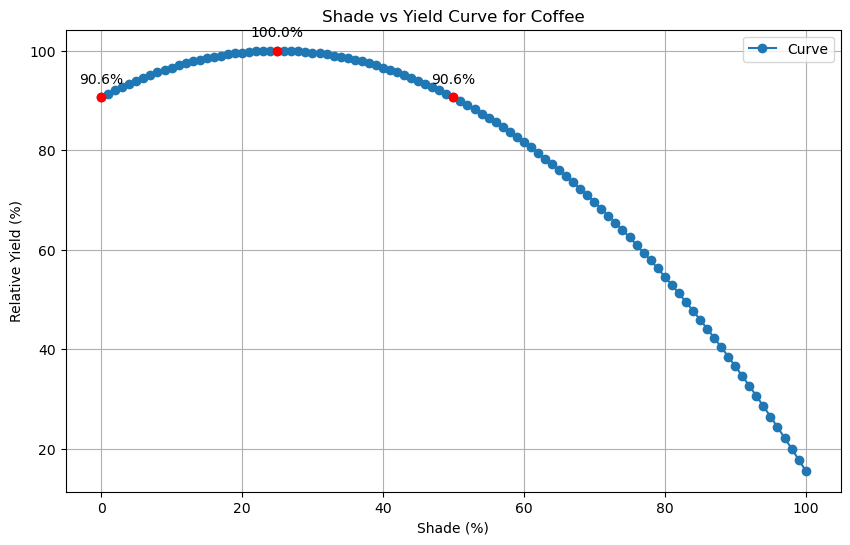

Peak Shade: 25.0%
Peak Yield: 100.0%


In [12]:
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Load curve
shade_vs_yield_curve_file = INPUT_DIR / "Shade_vs_Yield_Curve_coffee.csv"
shade_vs_yield_curve_COFFE = pd.read_csv(shade_vs_yield_curve_file)

#mu_new = 10   # you could replace this with your random draw
#shade_vs_yield_curve_COFFE = shift_peak_by_interpolation(shade_vs_yield_curve_COFFE, mu_new)

# Interpolator
f_interp = interp1d(
    shade_vs_yield_curve_COFFE['Shade (%)'],
    shade_vs_yield_curve_COFFE['Yield (%)'],
    kind='linear',
    fill_value='extrapolate'
)

# Points of interest
shade_points = [0, shade_vs_yield_curve_COFFE.loc[shade_vs_yield_curve_COFFE['Yield (%)'].idxmax(), 'Shade (%)'], 50]
yield_points = [float(f_interp(s)) for s in shade_points]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(shade_vs_yield_curve_COFFE['Shade (%)'], shade_vs_yield_curve_COFFE['Yield (%)'], marker='o', label='Curve')

# Annotate points
for s, y in zip(shade_points, yield_points):
    plt.scatter(s, y, color='red', zorder=5)
    plt.annotate(f"{y:.1f}%", (s, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Shade vs Yield Curve for Coffee')
plt.xlabel('Shade (%)')
plt.ylabel('Relative Yield (%)')
plt.grid()
plt.legend()
plt.show()

# Print the peak shade and yield
peak_shade = shade_vs_yield_curve_COFFE.loc[shade_vs_yield_curve_COFFE['Yield (%)'].idxmax(), 'Shade (%)']
peak_yield = shade_vs_yield_curve_COFFE['Yield (%)'].max()

print(f"Peak Shade: {peak_shade:.1f}%")
print(f"Peak Yield: {peak_yield:.1f}%")


 🍫 Cacao Shade–Yield Curve Assumptions  

The cacao shade–yield function was parameterized based on literature evidence showing that cacao is **more shade-tolerant than coffee**.  

📚 Key References
- **Beer, J., Muschler, R., Kass, D., & Somarriba, E. (1998).** *Shade management in coffee and cacao plantations.* Agroforestry Systems, 38:139–164.  
  → Review showing cacao is more shade-tolerant than coffee; yields can be sustained under 30–80% shade with only modest penalties at very high shade.  

- **Abou Rajab, Y., et al. (2016).** *Effects of shade tree cover on cacao yield in Sulawesi, Indonesia.*  
  → Field study showing bean yields remained relatively stable across 50–93% canopy cover, suggesting a broad plateau response rather than a sharp optimum

- **Contreras Fleury, M. (2025).** *Balancing Act: Meta-analysis of ecological and economic outcomes in Latin American coffee agroforestry systems.* Master’s Thesis.  
  → Meta-analysis finding cacao yield responses to shade are flatter than coffee’s, with less clear trade-offs at high shade



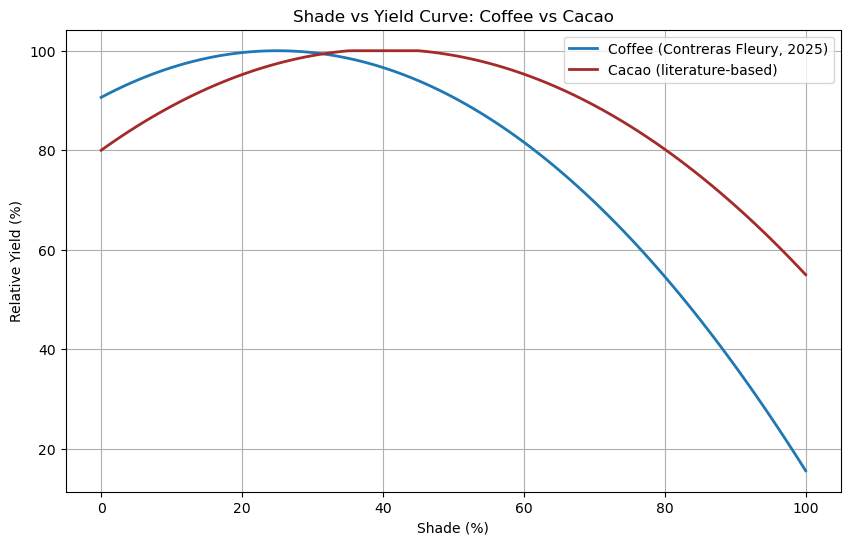

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def make_cacao_shade_curve(n_points=101,
                           peak_shade=45,    # literature: optimal ~25–45%
                           peak_yield=100,   # normalized
                           yield_at_0=80,    # reduced yield without shade
                           yield_at_100=55   # stronger penalty at full shade
                          ):
    """
    Construct a simple quadratic shade–yield curve for cacao.
    
    Anchors:
    - Yield at 0% shade ~70%
    - Maximum yield (100%) around 40% shade
    - Yield declines to ~45% at 100% shade
    
    Returns:
        DataFrame with columns: Shade (%) and Yield (%)
    """
    shade = np.linspace(0, 100, n_points)
    
    # Fit quadratic through anchor points
    X = np.array([
        [0**2, 0, 1],
        [peak_shade**2, peak_shade, 1],
        [100**2, 100, 1]
    ])
    y = np.array([yield_at_0, peak_yield, yield_at_100])
    a, b, c = np.linalg.solve(X, y)

    yield_vals = a*shade**2 + b*shade + c
    yield_vals = np.clip(yield_vals, 0, peak_yield)

    return pd.DataFrame({'Shade (%)': shade, 'Yield (%)': yield_vals})

# --- Example usage ---
cacao_curve = make_cacao_shade_curve()

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(shade_vs_yield_curve_COFFE['Shade (%)'], shade_vs_yield_curve_COFFE['Yield (%)'],
        label="Coffee (Contreras Fleury, 2025)", lw=2)
ax.plot(cacao_curve['Shade (%)'], cacao_curve['Yield (%)'],
        label="Cacao (literature-based)", lw=2, color="brown")

ax.set_xlabel("Shade (%)")
ax.set_ylabel("Relative Yield (%)")
ax.set_title("Shade vs Yield Curve: Coffee vs Cacao")
ax.legend()
ax.grid(True)

fig.savefig(f"{OUTPUT_DIR}/shade_vs_yield_curve_coffee_vs_cacao.png",
            dpi=300, bbox_inches='tight')
plt.show()


Derive a function to adjust crop yield based on canopy cover percentage.

In [14]:
from scipy.interpolate import interp1d

def estimate_new_yield(
    current_shade: float,
    current_yield: float,
    new_shade: float,
    shade_yield_df: pd.DataFrame
) -> float:
    """
    Estimate new yield based on change in shade, using relative scaling
    from the provided empirical shade–yield curve DataFrame.

    Args:
        current_shade (float): Current shade (%) [0–100]
        current_yield (float): Current observed yield (any unit)
        new_shade (float): Target new shade (%)
        shade_yield_df (pd.DataFrame): DataFrame with columns 'Shade (%)' and 'Yield (%)'

    Returns:
        float: Estimated new yield
    """
    interpolate_yield = interp1d(
        shade_yield_df["Shade (%)"],
        shade_yield_df["Yield (%)"],
        kind='linear',
        fill_value="extrapolate"
    )
    current_yield_pct = interpolate_yield(current_shade)
    new_yield_pct = interpolate_yield(new_shade)
    
    return current_yield * (new_yield_pct / current_yield_pct)


Try the function out

In [15]:
# Defeine a partial function to estimate new yield for coffee
from functools import partial
estimate_new_yield_coffe = partial(estimate_new_yield, 
                                    shade_yield_df = shade_vs_yield_curve_COFFE)
estimate_new_yield_cacao = partial(estimate_new_yield, 
                                    shade_yield_df = cacao_curve)

# Example usage
current_shade = 40.0  # Current shade in %
current_yield = 1  # Current yield in kg/ha
new_shade = 20.0  # New target shade in %
new_yield = estimate_new_yield_cacao(current_shade, current_yield, new_shade)
print(f"Previous yield: {current_yield:.2f} kg/ha with {current_shade}% shade")
print(f"Estimated new yield: {new_yield:.2f} kg/ha with {new_shade}% shade")

Previous yield: 1.00 kg/ha with 40.0% shade
Estimated new yield: 0.95 kg/ha with 20.0% shade


Derive a function that adjusts the new yield given the canopy change across the canopy DataFrame.

In [16]:
def adjust_yield_based_on_new_canopy_cover(
    prev_crop_df: pd.DataFrame,
    new_crop_df: pd.DataFrame,
    spec_to_fcn: dict  # {str or list[str]: function}
) -> pd.DataFrame:
    """
    Adjust yield in new_crop_df based on canopy cover and scientific name-specific rules.

    Args:
        prev_crop_df (pd.DataFrame): DataFrame with previous canopy cover and yield.
        new_crop_df (pd.DataFrame): DataFrame to adjust.
        spec_to_fcn (dict): Dictionary where keys are scientific name(s) (str or list),
                            and values are functions that estimate new yield.

    Returns:
        pd.DataFrame: DataFrame with adjusted yield values.
    """
    df = new_crop_df.copy()

    # Merge previous yield and canopy cover
    matching_cols = ['site_id', 'Scientific name']
    df = df.merge(
        prev_crop_df[matching_cols + ['canopy_cover', 
                                      'Tonnes/plant',
                                      'Price/tonnes (USD)']],
        on=matching_cols,
        how='left',
        suffixes=('', '_previous')
    )

    df['Tonnes/plant_previous'] = df['Tonnes/plant']

    # Flatten the dictionary to {individual name: function}
    name_to_function = {}
    for names, func in spec_to_fcn.items():
        if isinstance(names, str):
            names = [names]
        for name in names:
            name_to_function[name] = func

    # Apply yield adjustment row-wise
    def compute_new_yield(row):
        name = row['Scientific name']
        func = name_to_function.get(name)
        if func and pd.notna(row['canopy_cover_previous']) and pd.notna(row['canopy_cover']) and pd.notna(row['Tonnes/plant_previous']):
            return func(
                current_shade=row['canopy_cover_previous'],
                current_yield=row['Tonnes/plant_previous'],
                new_shade=row['canopy_cover']
            )
        return row['Tonnes/plant_previous']

    df['Tonnes/plant'] = df.apply(compute_new_yield, axis=1)

    return df


Try the function out

In [17]:
# Example usage of the adjust_yield_based_on_new_canopy_cover function with multiple species
from matplotlib.pylab import f


prev_crop_df = canopy_crop_dict['present']  # Assuming 'present' is the previous crop DataFrame
new_crop_df = canopy_crop_dict[list(canopy_crop_dict.keys())[1]]  # Using the second sheet as the new crop DataFrame
spec_to_fcn = {
    'Coffea arabica': estimate_new_yield_coffe,
    'Theobroma cacao': estimate_new_yield_cacao  # Assuming the same function for cacao
}
updated_df = adjust_yield_based_on_new_canopy_cover(
    prev_crop_df=prev_crop_df,
    new_crop_df=new_crop_df,
    spec_to_fcn=spec_to_fcn
)

print(f"Previous crop DataFrame:")
print(tabulate(prev_crop_df, headers='keys', tablefmt='psql'))

print(f"Updated new crop DataFrame with adjusted yields for multiple species:")
print(tabulate(updated_df, headers='keys', tablefmt='psql'))

Previous crop DataFrame:
+----+-----------+---------------------+------------+-------------+----------+------------------+---------------------------+--------------------+-----------+-------------+------------+----------------+---------------------+----------------------+------------------------+----------------------------+-------------------------------+-----------+-------------------------------+--------------------------+------------------+----------------+----------------------+-------------------+----------------------+
|    |   Plot ID | Region              |   latitude |   longitude | System   |   Plot size (ha) | Species                   | Scientific name    | Role      |   Plants/ha |   Kg/plant |   Tonnes/plant |   Yield (t/ha/year) |   Price/tonnes (USD) |   Per-tree shading (%) |   Planting cost (per tree) |   Maintenance cost (per tree) |   site_id |   Per-tree shading (%) scaled |   Shade contribution (%) |   Tree Shade (%) |   canopy_cover |   Plants/ha_baseline |   Ad

Update the `make_exposure` function so that it uses the `canopy_df` from the given alternative scenario and applies the baseline exposure as a reference to adjust yield levels accordingly.


In [18]:
def make_exposures(canopy_df, exposure_present=None, spec_to_fcn=spec_to_fcn, value_unit="USD"):
    """
    Create an Exposures object from a canopy DataFrame.

    Args:
        canopy_df (pd.DataFrame): DataFrame containing canopy data.
        base_exposures (Exposures): Base exposures to use for the new exposures.
        value_unit (str): Unit of value for the exposures.

    Returns:
        Exposures: An Exposures object with the provided data.
    """
    
    if exposure_present is None:
        # If no base exposures are provided, create a new Exposures object
        exp = make_exposure_from_canopy_df(canopy_df, value_unit=value_unit)
    else:
        # Use the base exposures and update the DataFrame
        new_canopy_df = canopy_df.copy()
        prev_canopy_df = exposure_present.gdf.copy()
        updated_df = adjust_yield_based_on_new_canopy_cover(
            prev_crop_df=prev_canopy_df,
            new_crop_df=new_canopy_df,
            spec_to_fcn=spec_to_fcn
        )
        exp = make_exposure_from_canopy_df(updated_df, value_unit=value_unit)
            
    return exp


**Try out:** Show how to create the current and alternative exposures based on `canopy_df`, using the baseline scenario as a reference for adjusting yields.

In [19]:
# Make the exposures for the 'present' condition
exp_present = make_exposures(canopy_df=canopy_crop_dict['present'],
                         exposure_present= None,
                         spec_to_fcn=spec_to_fcn, 
                         value_unit="USD")

# Print the Exposures object to verify
print("Exposures object for 'present' condition:")
#print(tabulate(exp_present.gdf, headers='keys', tablefmt='psql'))

# Make the exposures for the second condition (e.g., 'future' or 'alternative')
alternative_name = list(canopy_crop_dict.keys())[-4]  # Use the second condition
exp_new = make_exposures(canopy_df=canopy_crop_dict[alternative_name],
                         exposure_present=exp_present,
                         spec_to_fcn=spec_to_fcn, 
                         value_unit="USD")
print(f"Exposures object for {alternative_name} condition:")
#print(tabulate(exp_new.gdf, headers='keys', tablefmt='psql'))


# Sum over the 'value' column for Role == 'Main'
total_main_value = exp_present.gdf.loc[exp_present.gdf['Role'] == 'Main', 'value'].sum()
print(f"Total value for Role='Main': {total_main_value:.2f} {exp_present.value_unit}")

# Print the total value of the exposures with role equal to Main 
print(f"Total value for Role= '{alternative_name}': {exp_new.gdf.loc[exp_new.gdf['Role'] == 'Main', 'value'].sum():.2f} {exp_new.value_unit}")

2025-08-28 01:46:06,392 - climada.entity.exposures.base - WARNING - There are no impact functions assigned to the exposures
Exposures object for 'present' condition:
2025-08-28 01:46:06,406 - climada.entity.exposures.base - WARNING - There are no impact functions assigned to the exposures
Exposures object for shade_+25 condition:
Total value for Role='Main': 18808.20 USD
Total value for Role= 'shade_+25': 17682.33 USD


### *2.3 – Extra: Shift the peak of the optimal canopy level*

As an additional option, we allow the **optimal canopy peak** (where yield is maximized) to be shifted.  
This adjustment can later be used for **sensitivity analysis**, e.g. testing how results change if the yield–canopy curve is assumed to peak at a higher or lower shade level.

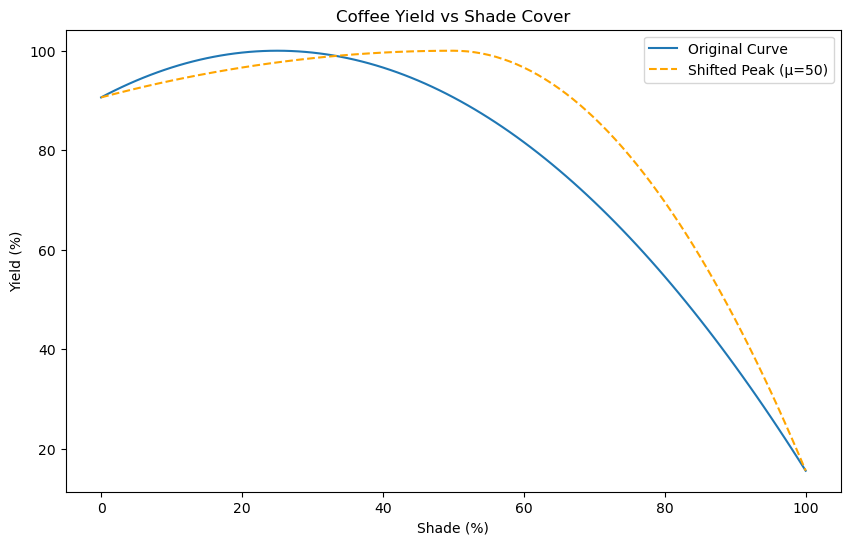

In [20]:
import numpy as np
import pandas as pd

import numpy as np
import pandas as pd

def shift_peak_by_interpolation(df, mu_new):
    # Original x, y
    x = df["Shade (%)"].to_numpy(dtype=float)
    y = df["Yield (%)"].to_numpy(dtype=float)

    # Detect old peak location
    mu_old = x[np.argmax(y)]

    # Split original curve at old peak
    left_mask  = x <= mu_old
    right_mask = x >= mu_old

    # Progress variables on each side (0→1 toward the peak)
    p_left  = (x[left_mask] / mu_old)
    p_right = (x[right_mask] - mu_old) / (100.0 - mu_old)

    # Interpolation functions
    def y_left_of(p):
        return np.interp(p, p_left, y[left_mask])
    def y_right_of(p):
        return np.interp(p, p_right, y[right_mask])

    # Build new curve
    y_new = np.empty_like(x, dtype=float)

    # Left of new peak
    left_new = x <= mu_new
    pL = np.divide(x[left_new], mu_new, out=np.zeros_like(x[left_new]), where=mu_new>0)
    y_new[left_new] = y_left_of(np.clip(pL, 0, 1))

    # Right of new peak
    right_new = ~left_new
    denom = (100.0 - mu_new) if mu_new < 100 else np.inf
    pR = np.divide(x[right_new] - mu_new, denom, out=np.zeros_like(x[right_new]), where=denom>0)
    y_new[right_new] = y_right_of(np.clip(pR, 0, 1))

    out = df.copy()
    out["Yield (%)"] = y_new
    return out

# Example usage:
# df_shifted = shift_peak_by_interpolation(df, mu_new=50)

# Example usage:
mu_new = 50   # you could replace this with your random draw
df = shade_vs_yield_curve_COFFE
df_new = shift_peak_by_interpolation(df, mu_new)
# Plotting the original and shifted curves
fig, ax = plt.subplots(figsize=(10, 6))
# Plot both curves on the same axes
shade_vs_yield_curve_COFFE.plot(
    x="Shade (%)", y="Yield (%)", ax=ax, label="Original Curve"
)
df_new.plot(
    x="Shade (%)", y="Yield (%)", ax=ax, label=f"Shifted Peak (μ={mu_new})", linestyle='--', color='orange'
)
# Style
ax.set_title("Coffee Yield vs Shade Cover")
ax.set_ylabel("Yield (%)")
ax.set_xlabel("Shade (%)")
ax.legend()
plt.show()


# 3 – Hazard 

☁️ Climate Hazards (VPD & Tmax) — based on Kath et al. 2022

**Data source**  
We use **TerraClimate** monthly grids for:
- `vpd` (kPa) – vapour pressure deficit  
- `tmax` (°C) – mean monthly maximum temperature  
and aggregate them over the **crop-specific growing season** for each year.

Download the data 

https://www.climatologylab.org/terraclimate.html



## 3.1 - Make the Hazards

In [21]:
import numpy as np
import xarray as xr
from scipy import sparse
from scipy.stats import genextreme
from climada.hazard import Hazard, Centroids
import pandas as pd

def _bootstrap_annual_fields(annual_da: xr.DataArray, n_years=100, start_year=2101, seed=None):
    """Resample annual FIELDS with replacement (preserves spatial patterns)."""
    rng = np.random.default_rng(seed)
    idx = rng.integers(0, annual_da.sizes["year"], size=n_years)
    out = annual_da.isel(year=idx)
    return out.assign_coords(year=np.arange(start_year, start_year + n_years))

def _gev_sample_field(annual_da: xr.DataArray, n_years=100, start_year=2101,
                      invert=False, coupled=False, seed=None):
    """
    Fit GEV per grid and sample n_years (use for annual MAX, or MIN with invert=True).
    coupled=True uses the same quantile across all grid cells per synthetic year (adds coherence).
    """
    rng = np.random.default_rng(seed)
    Y = annual_da
    stacked = Y.stack(grid=("lat","lon"))
    lat, lon = Y["lat"], Y["lon"]

    # Fit params per grid cell
    params = []
    for i in range(stacked.sizes["grid"]):
        ts = stacked.isel(grid=i).values
        ts = ts[~np.isnan(ts)]
        if len(ts) < 10:
            params.append((np.nan, np.nan, np.nan))
            continue
        if invert: ts = -ts
        c, loc, scale = genextreme.fit(ts)
        params.append((c, loc, scale))
    params = np.array(params)

    ngrid = stacked.sizes["grid"]
    # Draw quantiles
    U = rng.random((n_years, 1 if coupled else ngrid))
    U = np.clip(U, 1e-10, 1-1e-10)
    if coupled:
        U = np.repeat(U, ngrid, axis=1)

    samples = np.full((n_years, ngrid), np.nan)
    valid = ~np.isnan(params[:,0])
    if np.any(valid):
        c, loc, scale = params[valid,0], params[valid,1], params[valid,2]
        samples[:, valid] = genextreme.ppf(U[:, valid], c, loc=loc, scale=scale)
    if invert: samples = -samples

    out = samples.reshape(n_years, len(lat), len(lon))
    return xr.DataArray(out,
                        coords={"year": np.arange(start_year, start_year+n_years),
                                "lat": lat, "lon": lon},
                        dims=["year","lat","lon"])



def create_hazard_from_nc_files(
    nc_files,
    varname,
    haz_type="HAZARD",
    units="unit",
    agg="max",
    months=None,                 # e.g. [5,6,7,8,9,10,11]
    nan_replacement=None,        # e.g. 0.0 to fill; None keeps NaNs (then convert later)
    # --- NEW: synthetic options ---
    synth=None,                  # None | "bootstrap" | "gev"
    synth_kwargs=None            # dict, e.g. {"n_years":200,"start_year":2101,"invert":False,"coupled":True,"seed":42}
):
    """
    Build a CLIMADA Hazard from NetCDFs, with optional longer synthetic annual series.
    - months is honored (subset BEFORE annual aggregation).
    - agg in {'max','sum','mean'}.
    - synth:
        * None: use observed annual series
        * 'bootstrap': resample annual fields (best for means; preserves spatial patterns)
        * 'gev': fit per-cell GEV and sample (best for block MAX/MIN)
    """
    if synth_kwargs is None:
        synth_kwargs = {}

    print(f"📂 Loading {len(nc_files)} files for '{varname}'...")
    ds_list = [xr.open_dataset(str(f))[varname] for f in nc_files]
    data = xr.concat(ds_list, dim="time")

    if months:
        print(f"📆 Filtering to months: {months}")
        data = data.sel(time=data['time.month'].isin(months))

    print(f"🧮 Aggregating by year: '{agg}'")
    grouped = data.groupby("time.year")
    if agg == "max":
        data_yr = grouped.max("time")
    elif agg == "sum":
        data_yr = grouped.sum("time")
    elif agg == "mean":
        data_yr = grouped.mean("time")
    else:
        raise ValueError(f"Unsupported aggregation: {agg}")

    # Synthetic extension (optional)
    if synth is None:
        annual_da = data_yr
    elif synth == "bootstrap":
        print("🔁 Synthetic years via BOOTSTRAP of annual fields.")
        annual_da = _bootstrap_annual_fields(data_yr, **synth_kwargs)
    elif synth == "gev":
        if agg != "max":
            print("⚠️ GEV is typically for block maxima/minima; agg!='max' used.")
        print("📈 Synthetic years via GEV sampling (per grid).")
        annual_da = _gev_sample_field(data_yr, **synth_kwargs)
    else:
        raise ValueError("synth must be None, 'bootstrap', or 'gev'.")

    print("📌 Reshaping to [year, lat*lon] ...")
    data_flat = annual_da.stack(site=("lat","lon")).transpose("year","site")
    data_arr = data_flat.values

    if nan_replacement is not None:
        print(f"🔄 Replacing NaNs with {nan_replacement}...")
        data_arr = np.nan_to_num(data_arr, nan=nan_replacement)

    print("🧱 Building sparse intensity ...")
    intensity = sparse.csr_matrix(data_arr)

    print("🗺️ Centroids ...")
    latlon = data_flat.site.to_index().to_frame(index=False)
    cents = Centroids(lat=latlon["lat"].values, lon=latlon["lon"].values)

    years = annual_da["year"].values
    hazard = Hazard(
        haz_type=haz_type,
        intensity=intensity,
        fraction=intensity.copy().astype(bool),
        centroids=cents,
        units=units,
        event_id=np.arange(len(years)),
        frequency=np.ones(len(years))/len(years),
        date=np.array([pd.Timestamp(f"{y}-01-01").toordinal() for y in years]),
        event_name=[f"year_{y}" for y in years]
    )
    return hazard


**Step X – Derive Hazard Set (Mean Seasonal VPD or Tmax)**

We derive the hazard set by **aggregating monthly climate data** into a single value representing the **average hazard intensity during the growing season**.  
This ensures the hazard matches the crop’s phenology (months when yield is determined).

- **Inputs**: Monthly gridded climate data (NetCDF) for VPD or Tmax.  
- **Process**:
  1. Select the relevant variable (`vpd` or `tmax`).  
  2. Subset to the growing season months (e.g., April–November).  
  3. Average across the selected months for each year and grid cell.  
  4. Store results in a hazard object (CLIMADA `Hazard`) with annual time steps.  

- **Outputs**: Hazard set where each event = one season’s average hazard (per year, per location).

In [22]:
# from pathlib import Path
# from climada.hazard import Hazard

# def get_or_build_hazards(
#     hazard_type: str,
#     future_climate_scenario: str,
#     nc_root: Path,                 # where TerraClimate *.nc live
#     output_dir_hazard: Path,       # where to cache/write the built hazards (*.h5)
#     *,
#     force: bool = False,
#     synth: str = "bootstrap",
#     synth_kwargs: dict = {"n_years": 200, "start_year": 2101, "seed": 42},
#     nan_replacement: float = 0.0,
# ):
#     """
#     Load hazards from output_dir_hazard if present; otherwise build from TerraClimate
#     NetCDFs under nc_root and cache them to output_dir_hazard.

#     Returns: dict {'today': Hazard, 'future': Hazard}
#     """
#     output_dir_hazard.mkdir(parents=True, exist_ok=True)

#     # ---- choose parameters by hazard type ----
#     if hazard_type == "VPD":
#         agg, varname, units = "mean", "vpd", "kPa"
#         months = [5, 6, 7, 8, 9, 10, 11]
#         patt_today  = "terra_climate/TerraClimate_vpd_*_CA.nc"
#         patt_future = f"terra_climate/TerraClimate_{future_climate_scenario}_vpd_*_CA.nc"
#     elif hazard_type == "Tmax":
#         agg, varname, units = "mean", "tmax", "C"   # use 'max' if you want block maxima + GEV
#         months = [5, 6, 7, 8, 9, 10, 11]
#         patt_today  = "terra_climate/TerraClimate_tmax_*_CA.nc"
#         patt_future = f"terra_climate/TerraClimate_{future_climate_scenario}_tmax_*_CA.nc"
#     else:
#         raise ValueError(f"Unsupported hazard_type: {hazard_type}")

#     nc_files = {
#         "today":  sorted(nc_root.glob(patt_today)),
#         "future": sorted(nc_root.glob(patt_future)),
#     }

#     hazards = {}
#     for key in ("today", "future"):
#         # include 'key' in the filename so they don't overwrite each other
#         h5_path = output_dir_hazard / f"{hazard_type}__{future_climate_scenario}.h5"

#         if h5_path.exists() and not force:
#             print(f"✅ Using cached hazard: {h5_path}")
#             haz = Hazard()
#             haz.from_hdf5(str(h5_path))
#         else:
#             files = nc_files[key]
#             if not files:
#                 patt = patt_today if key == "today" else patt_future
#                 raise FileNotFoundError(f"No NetCDF files for '{key}' under {nc_root} (pattern: {patt})")
#             print(f"🛠️ Building hazard '{key}' from {len(files)} NetCDF files...")
#             haz = create_hazard_from_nc_files(
#                 files,
#                 varname=varname,
#                 haz_type=hazard_type,
#                 units=units,
#                 agg=agg,
#                 months=months,
#                 nan_replacement=nan_replacement,
#                 synth=synth,
#                 synth_kwargs=synth_kwargs,
#                 # or: synth="gev", synth_kwargs={"n_years": 200, "start_year": 2101, "invert": False, "coupled": True, "seed": 42}
#             )
#             print(f"💾 Saving hazard to {h5_path}")
#             haz.write_hdf5(str(h5_path))

#         hazards[key] = haz

#     return hazards


# # Build or load hazards
# haz_dict = get_or_build_hazards(
#     hazard_type=hazard_type,
#     future_climate_scenario=future_climate_scenario,
#     nc_root= Path("/Users/viggo/Documents/Programming/Consult/UNU/data"),
#     output_dir_hazard= INPUT_DIR / "hazards", # where to cache/write the built hazards (*.h5)
#     force=False,
#     synth="bootstrap",
#     synth_kwargs={"n_years": 200, "start_year": 2101, "seed": 42},
# )

# # Plot a sample of the hazard
# for key, haz in haz_dict.items():
#     print(f"Hazard for '{key}':")
#     haz.plot_intensity(0)


📂 Loading 37 files for 'tmax'...
📆 Filtering to months: [5, 6, 7, 8, 9, 10, 11]
🧮 Aggregating by year: 'mean'
🔁 Synthetic years via BOOTSTRAP of annual fields.
📌 Reshaping to [year, lat*lon] ...
🔄 Replacing NaNs with 0.0...
🧱 Building sparse intensity ...
🗺️ Centroids ...
📂 Loading 30 files for 'tmax'...
📆 Filtering to months: [5, 6, 7, 8, 9, 10, 11]
🧮 Aggregating by year: 'mean'
🔁 Synthetic years via BOOTSTRAP of annual fields.
📌 Reshaping to [year, lat*lon] ...
🔄 Replacing NaNs with 0.0...
🧱 Building sparse intensity ...
🗺️ Centroids ...


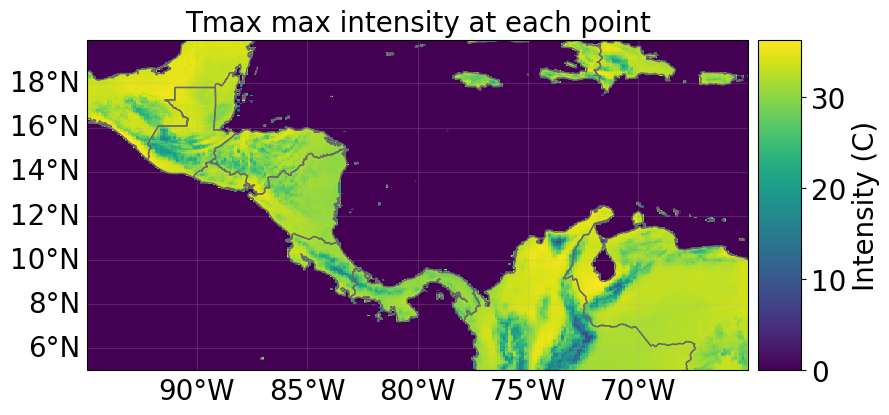

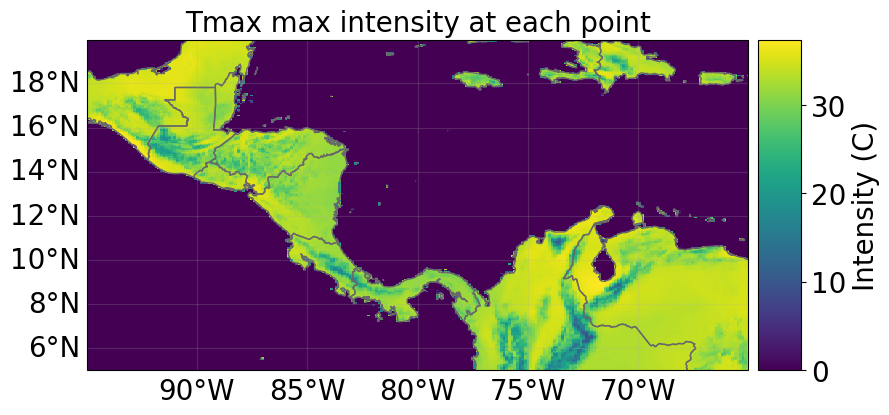

In [23]:
# Determine the corresponding parameters for the hazard type
nc_files = {'today': [], 'future': []}
haz_dict  = {'today': Hazard, 'future': Hazard}
nc_files_root = Path("/Users/viggo/Documents/Programming/Consult/UNU/data")


if hazard_type == 'VPD':
    agg    = 'mean'
    varname = 'vpd'
    units   = 'kPa'
    months  = [5,6,7,8,9,10,11]
    nc_files['today']  = sorted(nc_files_root.glob("terra_climate/TerraClimate_vpd_*_CA.nc"))
    nc_files['future'] = sorted(nc_files_root.glob(f"terra_climate/TerraClimate_{future_climate_scenario}_vpd_*_CA.nc"))

elif hazard_type == 'Tmax':
    agg    = 'mean'  # use 'max' if you want block maxima + GEV
    varname = 'tmax'
    units   = 'C'
    months  = [5,6,7,8,9,10,11]
    nc_files['today']  = sorted(nc_files_root.glob("terra_climate/TerraClimate_tmax_*_CA.nc"))
    nc_files['future'] = sorted(nc_files_root.glob(f"terra_climate/TerraClimate_{future_climate_scenario}_tmax_*_CA.nc"))

# Build hazards
for key in nc_files:
    haz_dict[key] = create_hazard_from_nc_files(
        nc_files[key],
        varname=varname,
        haz_type=hazard_type,
        units=units,
        agg=agg,
        months=months,
        nan_replacement=0.0,              # or None if you prefer to keep NaNs pre-sparse
        # --- turn on one of these when you want a longer series ---
        synth="bootstrap", synth_kwargs={"n_years": 200, "start_year": 2101, "seed": 42}
        # synth="gev",       synth_kwargs={"n_years": 200, "start_year": 2101, "invert": False, "coupled": True, "seed": 42}
    )
    haz_dict[key].plot_intensity(0)

    # # Store the hazards in map to not repeat the loading process
    # # Make a directory for the hazard maps
    # INPUT_DIR_HAZARD = INPUT_DIR / "hazards"
    # # Use the hazard type and future climate scenario in the file name
    # INPUT_DIR_HAZARD.mkdir(parents=True, exist_ok=True)
    # # Save the hazards to NetCDF files
    # for key in haz_dict:
    #     haz_file = INPUT_DIR_HAZARD / f"{key}__{hazard_type}__{future_climate_scenario}"
    #     print(f"💾 Saving hazard '{key}' to {haz_file} ...")
    #     haz_dict[key].write_hdf5(str(haz_file))


# 4 – Impact Function (Vulnerability)

We begin by creating a basic default impact function, which we later adjust based on canopy cover. Canopy cover provides a cooling effect that can reduce vulnerability to heat-related losses.

---

**Coffee and Cacao**

Based on our literature review:

- **Coffee**  
  - Highly sensitive to heat above **25 °C**, with yield collapse at extremes (**>42 °C sustained**, ~**49 °C short bursts**).    

- **Cacao**  
  - Tolerates higher average temperatures (up to **27 °C**, absolute maximum ~**38 °C**).  
  - Begins losing photosynthetic function near **37–38 °C**.  

---

As mentioned in *Step 3*, the vulnerability curve for coffee is sourced from:  
[Kath et al. (2022), *Nature Food*](https://www.nature.com/articles/s43016-022-00614-8).


In [24]:
from climada.entity import ImpactFunc

def impact_func_from_kath(
    file_path: str,
    intensity_col: str,
    yield_col: str,
    only_yield_losses: bool = True,
    haz_type: str = "VPD",
    unit: str = "kPa",
    if_id: int = 1,
    name: str = "Impact Function from CSV"
) -> ImpactFunc:
    """
    Create a CLIMADA ImpactFunc directly from a CSV file with intensity and yield(-log) data.

    Parameters:
    - file_path: path to CSV
    - intensity_col: column name for hazard intensity (e.g. 'Mean_VPD_kPa')
    - yield_col: column name for yield or log-yield (e.g. 'Effect_Central')
    - is_log: True if yield_col is in log scale
    - only_yield_losses: whether to filter for only negative yield impacts
    - haz_type: CLIMADA hazard type string (e.g. "VPD")
    - unit: unit for intensity (e.g. "kPa", "°C")
    - if_id: Impact function ID
    - name: Name for the impact function

    Returns:
    - ImpactFunc
    """
    df = pd.read_csv(file_path)

    if yield_col not in df.columns or intensity_col not in df.columns:
        raise ValueError("Specified columns not found in the CSV.")

    x = df[intensity_col].values
    y = df[yield_col].values

    # Optional filtering
    if only_yield_losses:
        mask = y < 0
        x, y = x[mask], y[mask]

    # Convert to linear scale if needed
    yield_vals = np.exp(y)

    # Normalize to max yield (best-case baseline)
    baseline = np.max(yield_vals)
    mdd = 1 - (yield_vals / baseline)
    mdd = np.clip(mdd, 0, 1)

    paa = np.ones_like(mdd)

    # Build and return
    impf = ImpactFunc(
        id=if_id,
        name=name,
        haz_type=haz_type,
        intensity=x,
        mdd=mdd,
        paa=paa,
        intensity_unit=unit
    )
    impf.check()
    return impf

# Apply a a function to extra polate the impact function to full damage
def extend_to_full_damage(impf: ImpactFunc, x_full: float | None = None) -> ImpactFunc:
    """
    Extend any ImpactFunc so that MDD reaches 1.0 (100% damage).
    
    Parameters
    ----------
    impf : ImpactFunc
        The impact function to extend (not modified in-place).
    x_full : float or None
        Intensity at which to set MDD=1.
        If None, extrapolate linearly using the slope of the last segment.
    
    Returns
    -------
    ImpactFunc
        A new ImpactFunc with extended arrays.
    """
    impf_new = copy.deepcopy(impf)

    x = np.array(impf_new.intensity, dtype=float)
    mdd = np.array(impf_new.mdd, dtype=float)
    paa = np.array(impf_new.paa, dtype=float)

    # If already reaches full damage, nothing to do
    if np.isclose(mdd[-1], 1.0):
        return impf_new

    # Decide endpoint
    if x_full is None:
        # Linear slope from last two points
        dx = max(x[-1] - x[-2], 1e-9)
        slope = (mdd[-1] - mdd[-2]) / dx
        if slope <= 0:
            slope = 1e-6  # tiny slope to allow reaching 1
        x_full = x[-1] + (1.0 - mdd[-1]) / slope

    # Append endpoint
    x_ext = np.append(x, x_full)
    mdd_ext = np.append(mdd, 1.0)
    paa_ext = np.append(paa, 1.0)

    impf_new.intensity = x_ext
    impf_new.mdd = mdd_ext
    impf_new.paa = paa_ext
    impf_new.check()
    return impf_new

🍫 Cacao — Impact functions

In [25]:
import numpy as np
from climada.entity import ImpactFunc

# Create an impact function for Cacao based on Tmax
def cacao_impf_tmax(
    T: np.ndarray = np.linspace(20, 45, 100),               # intensity grid (°C), e.g. seasonal mean/max during flowering
    T_opt: float = 32.0,        # optimum photosynthesis (literature: 31–33 °C)
    T50: float = 36.0,          # ~50% relative yield around 36 °C
    T_maxloss: float = 38.0,    # near-total loss beyond 37–38 °C
    if_id: int = 2, name="Cacao | Tmax", unit="°C"
) -> ImpactFunc:
    T = np.asarray(T, float)
    mdd = np.zeros_like(T, float)
    # No damage up to T_opt
    mdd[T <= T_opt] = 0.0
    # Linear ramp T_opt -> T50
    sel = (T > T_opt) & (T <= T50)
    mdd[sel] = (T[sel]-T_opt)/(T50-T_opt) * 0.5
    # Ramp T50 -> T_maxloss
    sel = (T > T50) & (T <= T_maxloss)
    mdd[sel] = 0.5 + (T[sel]-T50)/(T_maxloss-T50) * 0.5
    mdd[T > T_maxloss] = 1.0
    order = np.argsort(T)
    return ImpactFunc(
        id=if_id, name=name, haz_type="Tmax",
        intensity=T[order],
        mdd=np.maximum.accumulate(mdd[order]),
        paa=np.ones_like(T), intensity_unit=unit
    )


# Create an impact function for Cacao based on VPD
def cacao_impf_vpd(
    V: np.ndarray = np.linspace(0.5, 3.0, 100),             # intensity grid (kPa) for the relevant season
    V50: float = 1.8,           # ~50% relative yield (slightly higher, cacao tolerates some stress)
    k: float = 3.0,             # slope/steepness
    vpd_floor: float = 0.8,     # below this, no damage (typical under shade, canopy cooling)
    if_id: int = 3, name="Cacao | VPD", unit="kPa"
) -> ImpactFunc:
    V = np.asarray(V, float)
    # Relative yield r(V) = 1 / (1 + exp(k*(V - V50)))
    r = 1.0 / (1.0 + np.exp(k*(V - V50)))
    # Flatten pre-stress range (capped at r=1)
    r[V <= vpd_floor] = 1.0
    mdd = np.clip(1.0 - r, 0.0, 1.0)
    order = np.argsort(V)
    return ImpactFunc(
        id=if_id, name=name, haz_type="VPD",
        intensity=V[order],
        mdd=np.maximum.accumulate(mdd[order]),
        paa=np.ones_like(V), intensity_unit=unit
    )


### 4.1 – Get the default impact functions

2025-08-28 01:46:49,471 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.


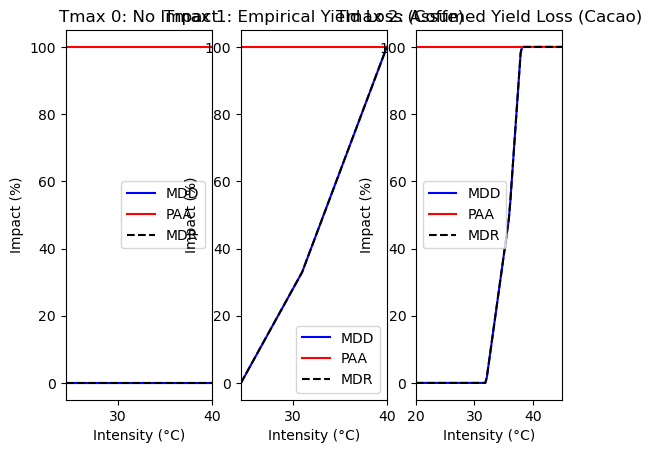

In [26]:
#from utils_cb import impact_func_from_kath

import pandas as pd
import numpy as np
from climada.entity import ImpactFuncSet


# Create an ImpactFuncSet with the VPD impact function
imp_fun_set_base = ImpactFuncSet()

## Make the impact function for coffee with id 1 
# Coffe has id # 1, Banana has id 2, Cacao has id 3
if hazard_type.upper() == 'TMAX':
    # Coffee impact function based on Tmax
    impf_coffe = impact_func_from_kath(
        file_path= "Data/tasmax_effect_approximation_coffe.csv",
        intensity_col="Mean_Tasmax_C", 
        yield_col="Upper_Bound", # Upper_Bound, Effect_Central or Lower_Bound – Represnting the confidence intervals of the yield loss –You can choose based on your preference of vulnerability
        haz_type="Tmax",
        unit="°C",
        if_id= 1,
        name="Empirical Yield Loss (Coffe)"
    )
    # Extend the coffee impact function to full damage
    impf_coffe = extend_to_full_damage(impf_coffe, x_full=40.0) 
    # Cacao impact function based on Tmax
    impf_cacao = cacao_impf_tmax(
        T=impf_coffe.intensity,
        if_id=2,
        name="Assumed/Prior Yield Loss (Cacao)"
    )
elif hazard_type.upper() == 'VPD':
    # Coffee impact function based on VPD
    impf_coffe = impact_func_from_kath(
        file_path= "Data/vpd_effect_approximation.csv",
        intensity_col="Mean_VPD_kPa",
        yield_col="Upper_Bound", # Upper_Bound, Effect_Central or Lower_Bound – Represnting the confidence intervals of the yield loss –You can choose based on your preference of vulnerability
        haz_type="VPD",
        unit="kPa",
        if_id= 1,
        name="Empirical Yield Loss (Coffe)"
    )
    # Extend the coffee impact function to full damage
    impf_coffe = extend_to_full_damage(impf_coffe, x_full=3.0)
    # Cacao impact function based on VPD
    impf_cacao = cacao_impf_vpd(
        V=impf_coffe.intensity,
        if_id=2,
        name="Assumed/Prior Yield Loss (Cacao)"
    )

#impf_coffe.plot()

# Adjust the impact function intensity to be zero before the increasing values to only account for negative impacts to account for heat stress
for idx, value in enumerate(impf_coffe.mdd):
   # print(f"Index: {idx}, Value: {value}")
    #print(f"Intensity: {impf_coffe.mdd}")
    if value > 0:
        impf_coffe.mdd[idx] = 0.0
    else:
        break

#impf_coffe.plot()

## Make the non impact function for coffee with id 0
impf_zero = copy.deepcopy(impf_coffe)
impf_zero.id = 0  # Set the ID to 0 for no impact
impf_zero.name = "No Impact"
impf_zero.mdd = np.zeros_like(impf_coffe.mdd)  # Set all values to zero
#impf_zero.plot()

# Make the cacao impact function based on the assumption that it is the same as coffee
# This is a prior assumption, not based on empirical data
# Adjust the intensity to be zero before the increasing values to only account for negative impacts
impf_cacao = cacao_impf_tmax() if hazard_type.upper() == 'TMAX' else cacao_impf_vpd()
#copy.deepcopy(impf_coffe)
impf_cacao.id = 2
impf_cacao.name = "Assumed Yield Loss (Cacao)"


# Add the impact function to the ImpactFuncSet
imp_fun_set_base.append(impf_zero)
imp_fun_set_base.append(impf_coffe)
imp_fun_set_base.append(impf_cacao)

# Plot the impact function set
ax = imp_fun_set_base.plot()
plt.show()

# ax is the ndarray of Axes you showed
fig = ax.ravel()[0].get_figure()   # or ax[0].get_figure()

fig.tight_layout()
fig.savefig(OUTPUT_DIR / "impact_functions_VPD.png",
            dpi=300, bbox_inches="tight")
plt.close(fig)  # optional: free memory

In [27]:
# impf_coffe.plot()

# import numpy as np
# import copy
# from climada.entity import ImpactFunc

# def extend_to_full_damage(impf: ImpactFunc, x_full: float | None = None) -> ImpactFunc:
#     """
#     Extend any ImpactFunc so that MDD reaches 1.0 (100% damage).
    
#     Parameters
#     ----------
#     impf : ImpactFunc
#         The impact function to extend (not modified in-place).
#     x_full : float or None
#         Intensity at which to set MDD=1.
#         If None, extrapolate linearly using the slope of the last segment.
    
#     Returns
#     -------
#     ImpactFunc
#         A new ImpactFunc with extended arrays.
#     """
#     impf_new = copy.deepcopy(impf)

#     x = np.array(impf_new.intensity, dtype=float)
#     mdd = np.array(impf_new.mdd, dtype=float)
#     paa = np.array(impf_new.paa, dtype=float)

#     # If already reaches full damage, nothing to do
#     if np.isclose(mdd[-1], 1.0):
#         return impf_new

#     # Decide endpoint
#     if x_full is None:
#         # Linear slope from last two points
#         dx = max(x[-1] - x[-2], 1e-9)
#         slope = (mdd[-1] - mdd[-2]) / dx
#         if slope <= 0:
#             slope = 1e-6  # tiny slope to allow reaching 1
#         x_full = x[-1] + (1.0 - mdd[-1]) / slope

#     # Append endpoint
#     x_ext = np.append(x, x_full)
#     mdd_ext = np.append(mdd, 1.0)
#     paa_ext = np.append(paa, 1.0)

#     impf_new.intensity = x_ext
#     impf_new.mdd = mdd_ext
#     impf_new.paa = paa_ext
#     impf_new.check()
#     return impf_new


# # Extend coffee curve to full damage automatically
# impf_coffee_ext = extend_to_full_damage(impf_coffe)

# # Or force collapse at 35 °C
# impf_coffee_ext = extend_to_full_damage(impf_coffe, x_full=35)

# # Plot
# impf_coffee_ext.plot()



**Create a DataFrame** to store the default impact function IDs, where:

- `0` → No impact (unknown imapct function)
- `1` → Coffee  
- `2` → Cacao


In [28]:
import pandas as pd

# Species categories
coffee_species = ['Coffea arabica']
cacao_species  = ['Theobroma cacao']

# Get all species in exposure
all_species = exp_present.gdf['Scientific name'].unique().tolist()

# Build mapping: 0 = default, 1 = coffee, 2 = cacao
default_impact_function_id = {
    1: coffee_species,
    2: cacao_species,
    0: [s for s in all_species if s not in coffee_species + cacao_species]
}

# Flatten to DataFrame
records = [
    {'Scientific name': species, 'impf_id_default': impf_id}
    for impf_id, species_list in default_impact_function_id.items()
    for species in species_list
]
impf_default_df = pd.DataFrame(records)

print("Default Impact Function DataFrame:")
print(tabulate(impf_default_df, headers='keys', tablefmt='psql'))


Default Impact Function DataFrame:
+----+--------------------+-------------------+
|    | Scientific name    |   impf_id_default |
|----+--------------------+-------------------|
|  0 | Coffea arabica     |                 1 |
|  1 | Theobroma cacao    |                 2 |
|  2 | Persea americana   |                 0 |
|  3 | Musa spp.          |                 0 |
|  4 | Citrus aurantium   |                 0 |
|  5 | Artocarpus altilis |                 0 |
|  6 | Gliricidia sepium  |                 0 |
|  7 | Inga spp.          |                 0 |
|  8 | Pouteria sapota    |                 0 |
|  9 | Citrus sinensis    |                 0 |
+----+--------------------+-------------------+


### 4.2 Add mapped impact function IDs to the exposure, based on site and canopy level


In [29]:
import copy
import numpy as np
import pandas as pd
from tabulate import tabulate

def generate_custom_impact_function_IDs_by_canopy_df(
    impf_default_df: pd.DataFrame,
    canopy_df: pd.DataFrame,
    hazard_type: str,
    ignore_impf_ids: list = [0] # Default to ignoring ID 0 (no impact) if not specified
):
    """
    Generate custom impact function IDs based on canopy cover and assign new IDs.

    Args:
        impf_default_df (pd.DataFrame): Columns ['Scientific name', 'impf_id_default']
        canopy_df (pd.DataFrame): Columns ['site_id', 'Scientific name', 'canopy_cover']
        imp_fun_set (ImpactFuncSet): Base impact function set to copy and expand.
        adjust_fcn (function): Function to adjust the base impact function using canopy_cover.
        hazard_type (str): Hazard type (e.g. "TR").
        ignore_impf_ids (list): List of impf IDs to skip (default: [0] = no impact)

    Returns:
        Tuple[pd.DataFrame, ImpactFuncSet]: 
            - Updated DataFrame with new impact function column `impf_{hazard_type}`
            - Modified ImpactFuncSet with newly added functions
    """

    # get the site_id and scientific name from the canopy_df
    df_site_canopy = canopy_df[['site_id', 'Scientific name']].drop_duplicates()

    # Merge canopy and default impact function assignments
    df_impf_id_map = df_site_canopy.merge(impf_default_df, on='Scientific name', how='left')

    # Copy the impact function set
    #imp_fun_set_new = copy.deepcopy(imp_fun_set)

    # Get next available ID
    next_id = impf_default_df['impf_id_default'].max() + 1

    # For caching and reuse
    species_func_cache = {}

    # Store new IDs
    new_impf_ids = []

    for _, row in df_impf_id_map.iterrows():
        site_id = row['site_id']
        species_name = row['Scientific name']
        base_impf_id = row['impf_id_default']

        if pd.isna(base_impf_id) or base_impf_id in ignore_impf_ids:
            # Use original base ID (e.g. 0 = no impact)
            new_impf_ids.append(base_impf_id)
            continue

        # Use a cache key (species, base ID) to avoid duplication
        key = (site_id, species_name, base_impf_id)

        if key in species_func_cache:
            new_impf_ids.append(species_func_cache[key])
            continue

        # Get base function and generate adjusted one
        species_func_cache[key] = next_id
        new_impf_ids.append(next_id)
        next_id += 1

    # Assign new column to the DataFrame
    df_impf_id_map = df_impf_id_map.copy()
    impf_col_name = f"impf_{hazard_type}"
    df_impf_id_map[impf_col_name] = new_impf_ids


    return df_impf_id_map

Test the function

In [30]:
# Example usage
df_impf_id_map = generate_custom_impact_function_IDs_by_canopy_df(
    impf_default_df=impf_default_df,
    canopy_df= canopy_crop_dict['present'],
    hazard_type=hazard_type
)

# Print the DataFrame with new impact function IDs
print("DataFrame with new impact function IDs:")
print(tabulate(df_impf_id_map, headers='keys', tablefmt='psql'))

DataFrame with new impact function IDs:
+----+-----------+--------------------+-------------------+-------------+
|    |   site_id | Scientific name    |   impf_id_default |   impf_Tmax |
|----+-----------+--------------------+-------------------+-------------|
|  0 |         0 | Persea americana   |                 0 |           0 |
|  1 |         0 | Musa spp.          |                 0 |           0 |
|  2 |         0 | Citrus aurantium   |                 0 |           0 |
|  3 |         0 | Artocarpus altilis |                 0 |           0 |
|  4 |         0 | Theobroma cacao    |                 2 |           3 |
|  5 |         0 | Coffea arabica     |                 1 |           4 |
|  6 |         0 | Gliricidia sepium  |                 0 |           0 |
|  7 |         0 | Inga spp.          |                 0 |           0 |
|  8 |         0 | Pouteria sapota    |                 0 |           0 |
|  9 |         0 | Citrus sinensis    |                 0 |           0 

Add the impf_Tmax to the exposure id for each canopy

In [31]:
def make_exposures_from_canopy_df(
    canopy_df: pd.DataFrame,
    exposure_present: Exposures = None,
    spec_to_fcn: dict = None,
    value_unit: str = "USD",
    impf_default_df=impf_default_df,
    ignore_impf_ids=[0],
    hazard_type: str = hazard_type
) -> Exposures:
    """
    Create an Exposures object from a canopy DataFrame.

    Args:
        canopy_df (pd.DataFrame): DataFrame containing canopy data.
        exposure_present (Exposures): Base exposures to use for the new exposures.
        spec_to_fcn (dict): Dictionary where keys are scientific name(s) (str or list),
                            and values are functions that estimate new yield.
        value_unit (str): Unit of value for the exposures.

    Returns:
        Exposures: An Exposures object with the provided data.
    """

    # Get the custom impact function IDs from the canopy DataFrame
    df_impf_id_map = generate_custom_impact_function_IDs_by_canopy_df(
        impf_default_df=impf_default_df,
        canopy_df=canopy_df,
        hazard_type=hazard_type,
        ignore_impf_ids= ignore_impf_ids
    )
    
    # Add to the canopy DataFrame
    canopy_df = canopy_df.merge(df_impf_id_map[['site_id', 'Scientific name', f'impf_{hazard_type}']],
                                on=['site_id', 'Scientific name'],
                                how='left')
   
    # make the exposures
    exp = make_exposures(
        canopy_df=canopy_df,
        exposure_present=exposure_present,
        spec_to_fcn=spec_to_fcn,
        value_unit=value_unit
    )

    return exp


**Try the function** and verify that the generated exposure also includes an assigned impact function ID.

In [32]:
# Example usage 
exp_present = make_exposures_from_canopy_df(canopy_df = canopy_crop_dict['present'],
                                            exposure_present= None,
                                            spec_to_fcn = spec_to_fcn)

# Print the Exposures object to verify
print("Exposures object for 'present' condition:")
print(tabulate(exp_present.gdf, headers='keys', tablefmt='psql'))

Exposures object for 'present' condition:
+----+-----------+---------------------+----------+------------------+---------------------------+--------------------+-----------+-------------+------------+----------------+---------------------+----------------------+------------------------+----------------------------+-------------------------------+-----------+-------------------------------+--------------------------+------------------+----------------+----------------------+-------------------+----------------------+-------------+------------------+---------+----------------------------------------------+
|    |   Plot ID | Region              | System   |   Plot size (ha) | Species                   | Scientific name    | Role      |   Plants/ha |   Kg/plant |   Tonnes/plant |   Yield (t/ha/year) |   Price/tonnes (USD) |   Per-tree shading (%) |   Planting cost (per tree) |   Maintenance cost (per tree) |   site_id |   Per-tree shading (%) scaled |   Shade contribution (%) |   Tree Sha

### 4.3 Adjust the impact function for cooling effects and create unique impact function sets for each compositions

**Create an adjustment function** that modifies the hazard intensity based on canopy cover, reflecting the cooling and protective effects of increased shade.

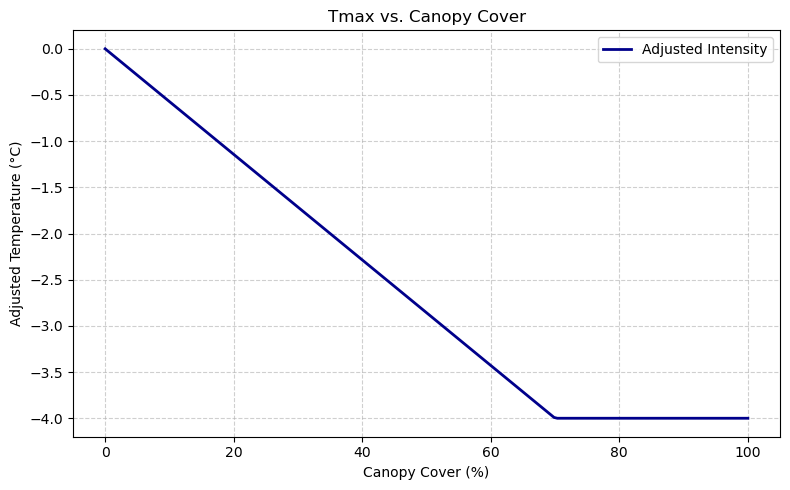

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Updated function definition
def helper_create_adj_func(max_cooling=4, plateau_at=70, sensitivity=None):
    """
    Creates an adjustment function for canopy cover effects on the intensity of a hazard.
    Args:
        max_cooling (float): Maximum cooling effect (°C or kPa).
        plateau_at (float): Canopy cover percentage at which the cooling effect plateaus.
        sensitivity (float, optional): Sensitivity factor for VPD reduction. If None, no
            sensitivity adjustment is applied.
    Returns:
        function: A function that takes a hazard intensity and canopy cover array
                  and returns the adjusted hazard intensity.
    """
    slope = -max_cooling / plateau_at

    def adjustment(intensity, canopy_cover):
        """Applies adjustment to hazard intensity based on canopy cover."""
        if not isinstance(canopy_cover, np.ndarray):
            canopy_cover = np.array(canopy_cover)
        canopy = np.clip(canopy_cover, 0, 100)
        temp_reduction = np.where(
            canopy <= plateau_at,
            slope * canopy,
            -max_cooling
        )
        if sensitivity is not None:
            reduction = -sensitivity * temp_reduction
        else:
            reduction = temp_reduction
        return intensity + reduction

    return adjustment

# Example for plotting
canopy = np.linspace(0, 100, 200)
if hazard_type.upper() == 'TMAX':
    base_intensity = 0  # °C
    adjust_fcn = helper_create_adj_func()
    ylabel = "Adjusted Temperature (°C)"
    title = "Tmax vs. Canopy Cover"
elif hazard_type.upper() == 'VPD':
    base_intensity = 0  # kPa
    adjust_fcn = helper_create_adj_func(sensitivity=-0.15)
    ylabel = "Adjusted VPD (kPa)"
    title = "VPD vs. Canopy Cover"
else:
    raise ValueError("Unsupported hazard type")

# Calculate adjusted values
adj_intensity = adjust_fcn(base_intensity, canopy)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(canopy, adj_intensity, label="Adjusted Intensity", color="darkblue", linewidth=2)
plt.title(title)
plt.xlabel("Canopy Cover (%)")
plt.ylabel(ylabel)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
fig = plt.gcf()  # <-- get current figure
fig.savefig(f"{OUTPUT_DIR}/canopy_cooling_curve.png", dpi=300, bbox_inches='tight')
plt.show()


**Create a function** that adjusts the impact function using the previously defined hazard intensity adjustment function, updating vulnerability curves accordingly.

In [34]:
def adjust_impf_by_canopy(impf, adjust_fcn, new_id, current_canopy=50, new_name=None):
    """
    Adjust an impact function based on a canopy adjustment function.

    Parameters:
    -----------
    impf : ImpactFuncSet or compatible object
        Original impact function to be adjusted.
    adjust_fcn : function
        Function that modifies intensity based on canopy cover: f(intensity, canopy).
    new_id : int
        ID for the new adjusted impact function.
    current_canopy : float
        Canopy cover percentage to apply (default is 50).

    Returns:
    --------
    adj_impf : ImpactFunc object
        A copy of the original impact function with adjusted intensity and MDR.
    """
    # Copy the original impact function
    adj_impf = copy.deepcopy(impf)

    # Full original intensity range
    orig_intensity = impf.intensity
    orig_min, orig_max = orig_intensity.min(), orig_intensity.max()

    # Use fine spacing to assess max shift
    test_intensity = np.linspace(orig_min, orig_max, 500)
    adjusted = adjust_fcn(test_intensity, current_canopy)
    shift = adjusted - test_intensity
    max_shift = np.abs(shift).max()

    # Extend range to ensure coverage
    n_points = 50
    intensity_range = np.linspace(orig_min - max_shift, orig_max + max_shift, n_points)


    # Check paa logic
    if np.all(impf.paa == 1):
        adj_intensity = adjust_fcn(intensity_range, current_canopy)
        adjusted_mdr = impf.calc_mdr(adj_intensity)

        # Update impact function
        adj_impf.intensity = intensity_range
        adj_impf.mdd = adjusted_mdr
        adj_impf.paa = np.ones_like(intensity_range)
        adj_impf.id = new_id
        if new_name is not None:
            adj_impf.name = new_name

    else:
        print('⚠️ Warning: impf.paa is not all ones, adjustment skipped.')

    return adj_impf


Demonstrate the adjusted imapct function

<Axes: title={'center': 'Tmax 1: Adjusted Impact Function (Coffe)'}, xlabel='Intensity (°C)', ylabel='Impact (%)'>

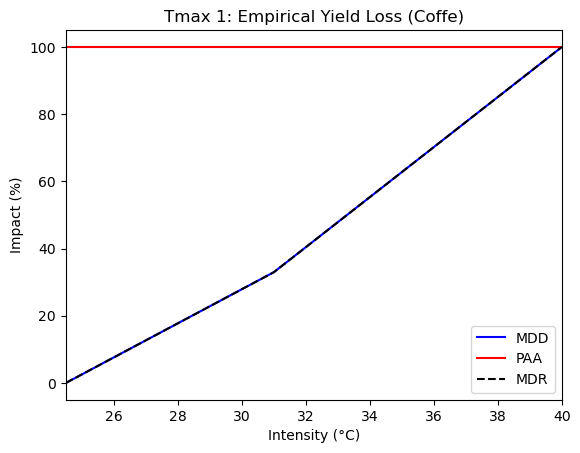

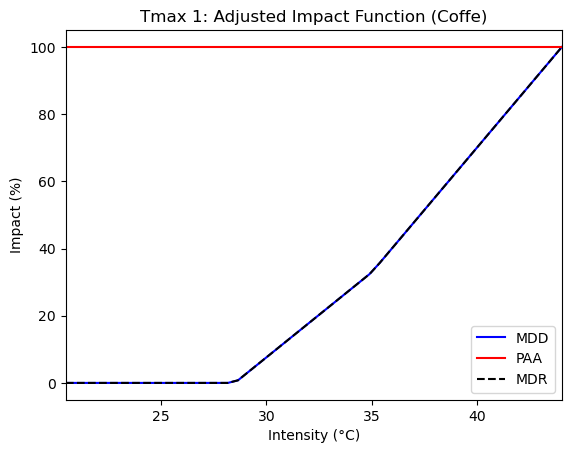

In [35]:
new_id = 1
adj_impf = adjust_impf_by_canopy(impf_coffe, adjust_fcn, new_id, current_canopy=70, new_name="Adjusted Impact Function (Coffe)")

impf_coffe.plot()
adj_impf.plot()

**Create a function** that generates a unique impact function set for each canopy composition, incorporating canopy-based adjustments to hazard intensity and vulnerability.

In [36]:
def create_adjusted_impact_function_set(
    canopy_df: pd.DataFrame,
    adjust_fcn,
    imp_fun_set_base: ImpactFuncSet = imp_fun_set_base,
    df_impf_id_map: pd.DataFrame = df_impf_id_map,
    hazard_type: str = hazard_type,
    ignore_impf_ids: list = [0]  # Default to ignoring ID 0 (no impact) if not specified
):
    """
    Create adjusted impact functions using pre-assigned IDs and canopy cover.

    Args:
        df_impf_id_map (pd.DataFrame): Must contain ['site_id', 'Scientific name', 'impf_id_default', 'impf_{hazard_type}']
        df_site_canopy (pd.DataFrame): Must contain ['site_id', 'Scientific name', 'canopy_cover']
        imp_fun_set_base (ImpactFuncSet): Original function set.
        adjust_fcn (function): Canopy adjustment function.
        hazard_type (str): Hazard type (e.g., "TMAX")

    Returns:
        ImpactFuncSet: New ImpactFuncSet with adjusted functions added.
    """
    # get the site_id and scientific name from the canopy_df
    df_site_canopy = canopy_df[['site_id', 'Scientific name', 'canopy_cover']].drop_duplicates()


    # Merge canopy cover into the ID mapping DataFrame
    df_merged = df_impf_id_map.merge(
        df_site_canopy,
        on=['site_id', 'Scientific name'],
        how='left'
    )

    # Copy original function set
    imp_fun_set_new = copy.deepcopy(imp_fun_set_base)
    seen_ids = set()

    # Iterate through the merged DataFrame to create adjusted functions
    for _, row in df_merged.iterrows():
        site_id = row['site_id']
        base_id = row['impf_id_default']
        new_id = row[f'impf_{hazard_type}']
        canopy = row['canopy_cover']


        if pd.isna(new_id) or new_id in ignore_impf_ids or new_id in seen_ids:
            # Skip if no new ID or already seen
            continue

        base_impf = imp_fun_set_base.get_func(hazard_type, base_id) # Get the base impact function by hazard type and ID
        adjusted_func = adjust_impf_by_canopy(
            base_impf,
            adjust_fcn=adjust_fcn,
            new_id=new_id,
            current_canopy=canopy, 
            new_name=f"{row['Scientific name']} site {site_id}"
        )

        imp_fun_set_new.append(adjusted_func)
        seen_ids.add(new_id)

    return imp_fun_set_new

Try out the function

array([[<Axes: title={'center': 'Tmax 0: No Impact'}, xlabel='Intensity (°C)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'Tmax 1: Empirical Yield Loss (Coffe)'}, xlabel='Intensity (°C)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'Tmax 2: Assumed Yield Loss (Cacao)'}, xlabel='Intensity (°C)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'Tmax 3: Theobroma cacao site 0'}, xlabel='Intensity (°C)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'Tmax 4: Coffea arabica site 0'}, xlabel='Intensity (°C)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'Tmax 5: Theobroma cacao site 1'}, xlabel='Intensity (°C)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'Tmax 6: Coffea arabica site 1'}, xlabel='Intensity (°C)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'Tmax 7: Theobroma cacao site 2'}, xlabel='Intensity (°C)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'Tmax 8: Coffea arabica site 2'}, xlabel='Intensity (°C)'

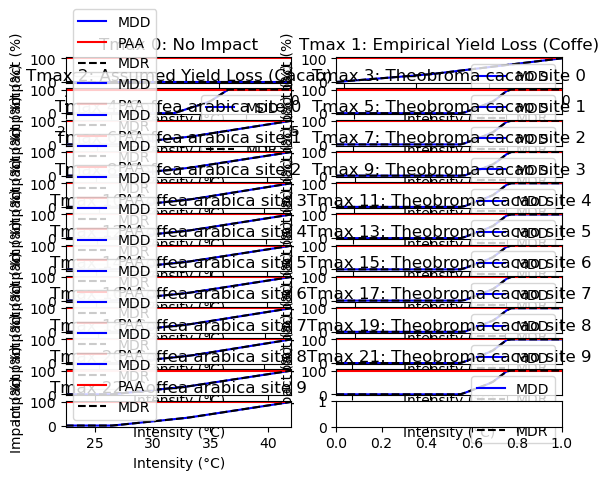

In [37]:
adjusted_impf_set = create_adjusted_impact_function_set(
    canopy_df=canopy_crop_dict[list(canopy_crop_dict.keys())[0]],  # Use the first sheet as the base
    adjust_fcn=adjust_fcn
)

adjusted_impf_set.plot()

# 5 – Cost and Income

In CLIMADA there is a new Cost–Income object that supports cost–benefit analysis
by combining revenue streams and cost structures, making it easier to evaluate
adaptation measures in a consistent way.

In this notebook we take a simplified approach:
 - In the `canopy_df` we have already attributed planting and maintenance costs
   to the added (new) and reduced (removed) trees.
 - These costs are then treated separately as planting and maintenance,
   linked to canopy composition changes.

*Disclosure*: For simplicity, we do not use the full Cost–Income object here.
Instead, we apply discounting via the `DiscountRate` object to obtain the
net present value (NPV) of costs and revenues.


In [38]:
def make_cashflows_costs(canopy_df: pd.DataFrame,
                         costs_df: pd.DataFrame,
                         start_year: int = present_year,
                         future_year: int = future_year,
                         disc_rate=None):
    """
    Build yearly cost cashflows (USD) with columns: year | Previous | Added | total.
    If `disc_rate` (object with .net_present_value(start_year, end_year, cashflows)) is given,
    returns (df, npv). Otherwise returns df.
    """

    # Calculate the number of years
    years = future_year - start_year + 1

    need_canopy = {"Scientific name", "Previous Plants/ha", "Added Plants/ha"}
    if not need_canopy.issubset(canopy_df.columns):
        raise ValueError(f"canopy_df must contain columns {need_canopy}")

    need_costs = {"Scientific name", "Planting cost (per tree)", "Maintenance cost (per tree)"}
    if not need_costs.issubset(costs_df.columns):
        raise ValueError(f"costs_df must contain columns {need_costs}")

    # Aggregate counts per scientific name
    counts = (canopy_df
              .groupby("Scientific name", as_index=False)[["Previous Plants/ha", "Added Plants/ha"]]
              .sum())

    # Ensure numeric + clip negatives for 'Added'
    counts["Previous Plants/ha"] = pd.to_numeric(counts["Previous Plants/ha"], errors="coerce").fillna(0.0)
    counts["Added Plants/ha"]    = pd.to_numeric(counts["Added Plants/ha"], errors="coerce").fillna(0.0).clip(lower=0)

    # Join costs
    df = counts.merge(costs_df, on="Scientific name", how="left")
    for c in ["Planting cost (per tree)", "Maintenance cost (per tree)"]:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0.0)

    # Per-year totals
    previous_per_year     = float((df["Previous Plants/ha"] * df["Maintenance cost (per tree)"]).sum())
    added_maint_per_year  = float((df["Added Plants/ha"]    * df["Maintenance cost (per tree)"]).sum())
    added_oneoff_year1    = float((df["Added Plants/ha"]    * df["Planting cost (per tree)"]).sum())

    years_idx = np.arange(start_year, start_year + years)

    previous = np.full(years, round(previous_per_year, 2))
    added    = np.full(years, round(added_maint_per_year, 2))
    if years > 0:
        added[0] = round(added[0] + added_oneoff_year1, 2)

    out = pd.DataFrame({
        "year": years_idx,
        "Previous": previous,
        "Added": added,
    })
    out["total"] = (out["Previous"] + out["Added"]).round(2)

    # Calculate NPV
    npv_dict = {}
    for col in ["Previous", "Added", "total"]:
        if disc_rate is None:
                npv_dict[col] = out[col].sum()
        else:
            npv_dict[col] = disc_rate.net_present_value(int(out["year"].min()),
                                            int(out["year"].max()),
                                            out[col].to_numpy())
    return out, npv_dict

Read the costs from the canopy data frame

In [39]:
# Import the canopy price data
costs_df = canopy_crop_dict['present'][['Scientific name', 'Planting cost (per tree)', 'Maintenance cost (per tree)']].drop_duplicates()

for comp, df in canopy_crop_dict.items():
    cost_cashflows_df, npv_dict = make_cashflows_costs(df, costs_df)
    print(f"Cashflows for '{comp}':")
    print(tabulate(cost_cashflows_df, headers='keys', tablefmt='psql'))
    print(f"Net Present Value (NPV) for '{comp}':")
    print(tabulate(pd.DataFrame([npv_dict]), headers='keys', tablefmt='psql'))
    print("\n")

Cashflows for 'present':
+----+--------+------------+---------+---------+
|    |   year |   Previous |   Added |   total |
|----+--------+------------+---------+---------|
|  0 |   2025 |     754.82 |       0 |  754.82 |
|  1 |   2026 |     754.82 |       0 |  754.82 |
|  2 |   2027 |     754.82 |       0 |  754.82 |
|  3 |   2028 |     754.82 |       0 |  754.82 |
|  4 |   2029 |     754.82 |       0 |  754.82 |
|  5 |   2030 |     754.82 |       0 |  754.82 |
|  6 |   2031 |     754.82 |       0 |  754.82 |
|  7 |   2032 |     754.82 |       0 |  754.82 |
|  8 |   2033 |     754.82 |       0 |  754.82 |
|  9 |   2034 |     754.82 |       0 |  754.82 |
| 10 |   2035 |     754.82 |       0 |  754.82 |
| 11 |   2036 |     754.82 |       0 |  754.82 |
| 12 |   2037 |     754.82 |       0 |  754.82 |
| 13 |   2038 |     754.82 |       0 |  754.82 |
| 14 |   2039 |     754.82 |       0 |  754.82 |
| 15 |   2040 |     754.82 |       0 |  754.82 |
| 16 |   2041 |     754.82 |       0 |  754.

Calculate the cost income object

In [40]:
# from cost_cashflows_df get the initial and periodic costs
from tracemalloc import start
from turtle import st
from climada.entity.measures.cost_income import CostIncome

# make a function to create the cashflows from the canopy_df and costs_df
def make_cost_income_from_canopy_df(
    canopy_df: pd.DataFrame,
    costs_df: pd.DataFrame,
    column: str = 'Added', # 'Added' or 'total'
) -> pd.DataFrame:
    """
    Create cashflows DataFrame from canopy and costs DataFrames.
    Args:
        canopy_df (pd.DataFrame): DataFrame with canopy data.
        costs_df (pd.DataFrame): DataFrame with costs data.
        years (int): Number of years for cashflows.
        start_year (int): Starting year for cashflows.

    Returns:
        pd.DataFrame: DataFrame with cashflows.
    """
    cashflows_df, _ = make_cashflows_costs(
        canopy_df=canopy_df,
        costs_df=costs_df
    )

    # Extract initial and periodic costs
    init_cost = cashflows_df[column].iloc[0] if not cashflows_df.empty else 0.0
    periodic_cost = cashflows_df[column].iloc[1:].mean() if len(cashflows_df) > 1 else 0.0

    # Create a CostIncome object
    cost_income = CostIncome(
        init_cost=init_cost,  # Initial cost from the first row
        periodic_cost=periodic_cost,  # Periodic cost from the mean of subsequent rows
    )
    return cost_income

# Example usage
cost_income = make_cost_income_from_canopy_df(
    canopy_df=canopy_crop_dict['present'],  # Use the 'present' condition
    costs_df=costs_df,  # Costs DataFrame
    column='Added'  # Column to use for cashflows ('Added' or 'total')
)

# 6 – Discount Rates

Used for discounting future costs and revenues in the cost–benefit analysis.

<Axes: title={'center': 'Discount rates'}, xlabel='Year', ylabel='discount rate (%)'>

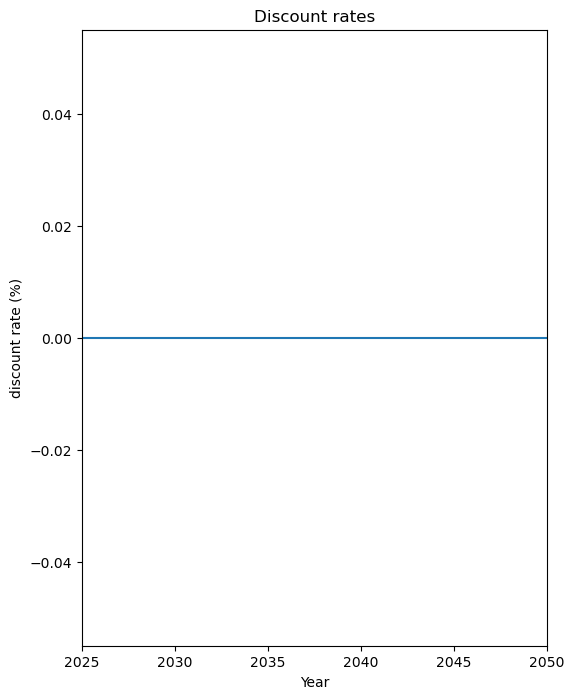

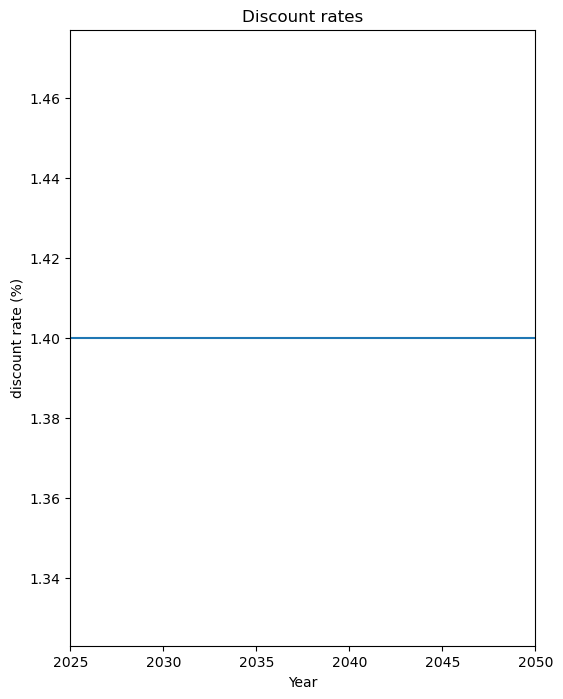

In [41]:
from climada.entity import DiscRates

year_range = np.arange( present_year, future_year + 1)
n_years = len(year_range)
annual_discount_zero = np.zeros(n_years)
annual_discount_stern = np.ones(n_years) * 0.014

# Create discount rates with zero and Stern's discount rates
discount_zero = DiscRates(year_range, annual_discount_zero)
discount_stern = DiscRates(year_range, annual_discount_stern)
# Plot the discount rates
discount_zero.plot(label='Zero Discount Rate')
discount_stern.plot(label='Stern Discount Rate')

Decide on a discount rate

In [42]:
# Create the entity for the present climate scenario
disc_rate = discount_zero  # discount_zero or discount_stern

## 7 – Measures

In the new CLIMADA update, measures can now makes use of *mapper functions* that transform a CLIMADA object (Exposure, Hazard, or Impact Function Set) into a modified version of the same type.

In our case, the `canopy_df` – which encodes the canopy composition of an  
alternative scenario – acts as the driver of the measure:

- It modifies the **Exposure** object by changing crop values and areas according to yield–shade relationships.  
- It modifies the **Impact Function Set** by adjusting vulnerability curves (e.g. reduced Tmax/VPD sensitivity under higher shade).  
- The **Hazard** object itself is unchanged, but the effective hazard intensity is perceived differently due to the adjusted vulnerability.  

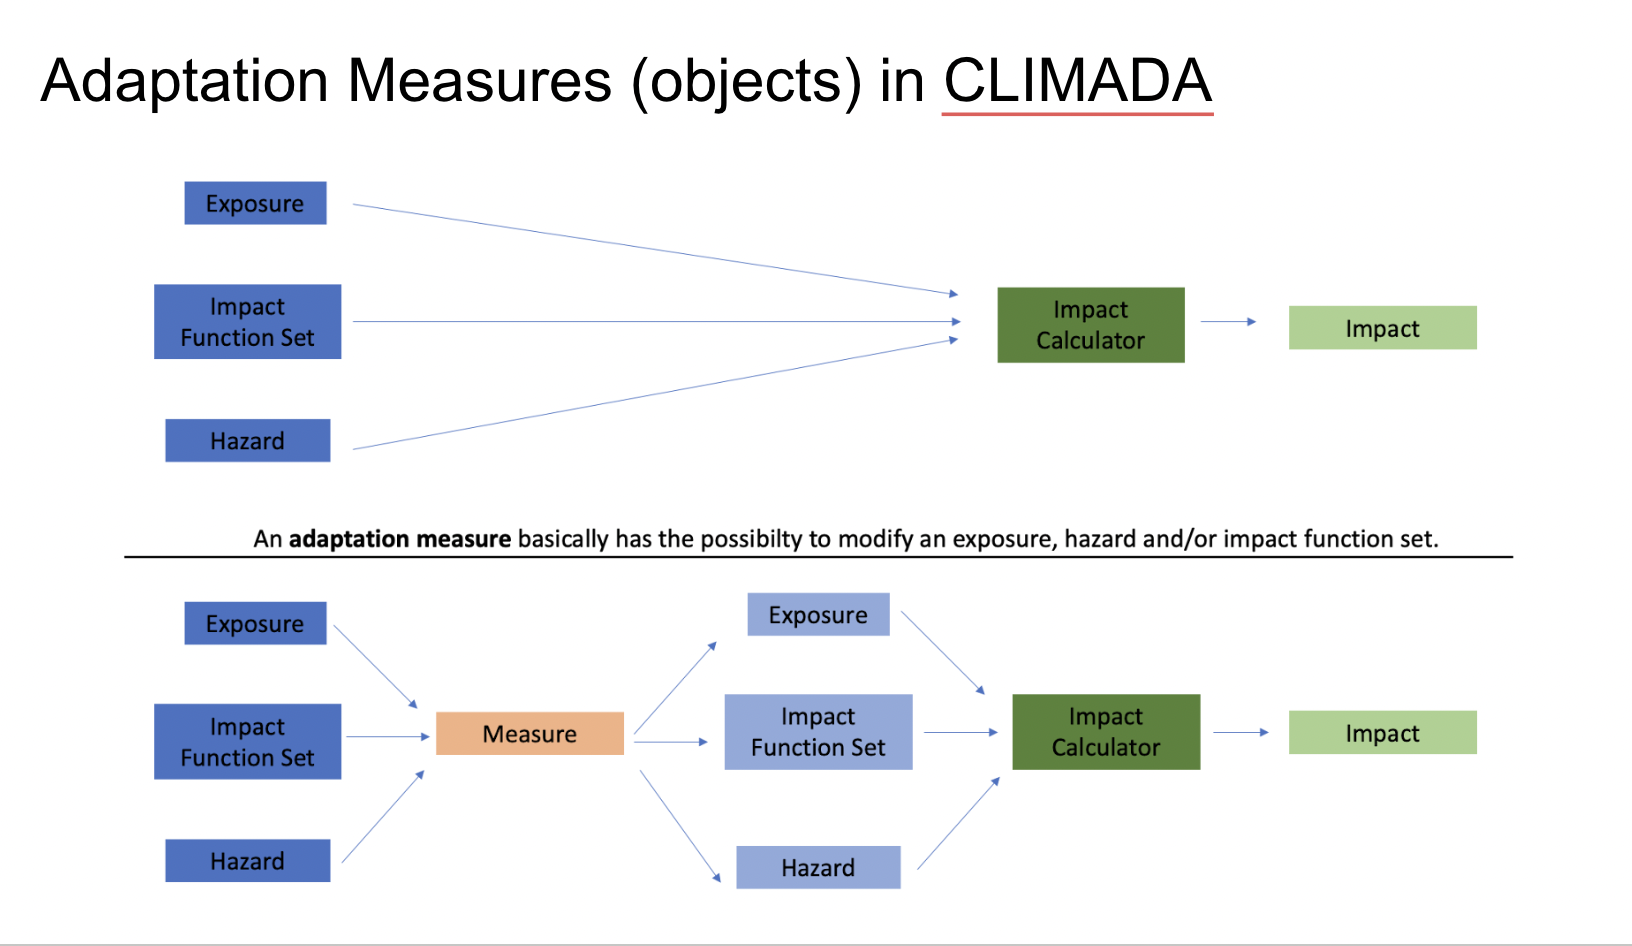

### 7.1 Make the mappers

#### 7.1.1 Make the exposure mapper

In [43]:
from typing import Optional
# from climada.entity import Exposures

def make_exposure_mapper(
    canopy_df: pd.DataFrame,
    spec_to_fcn: dict,
):
    """
    Returns a function exp_mapper(exposure_present_, year) -> Exposures
    with all other arguments fixed from this scope.
    """

    def exp_mapper( exposure_present: Optional["Exposures"] = None,
                    year: Optional[int] = None
                    ):
        return make_exposures_from_canopy_df(
            canopy_df=canopy_df,
            exposure_present=exposure_present,
            spec_to_fcn=spec_to_fcn,
        )

    return exp_mapper


Try the mapper

In [44]:
# present exposures (baseline)
exp_present = make_exposures_from_canopy_df(
    canopy_df=canopy_crop_dict['present'],
    spec_to_fcn=spec_to_fcn
)
# Print the Exposures object to verify
print("Exposures object for 'present' condition:")
print(tabulate(exp_present.gdf, headers='keys', tablefmt='psql'))

# mapper that will (for now) ignore `year` but keeps a compatible signature
# Make the exposures for the second condition (e.g., 'future' or 'alternative')
alternative_name = list(canopy_crop_dict.keys())[2]  # Use the second condition
exp_mapper = make_exposure_mapper(
    canopy_df=canopy_crop_dict[alternative_name],
    spec_to_fcn=spec_to_fcn
)

# later in your code
exp_new = exp_mapper(exposure_present=exp_present)  # year ignored
# Print the Exposures object to verify
print(f"Exposures object for {alternative_name}") 
print(tabulate(exp_new.gdf, headers='keys', tablefmt='psql'))



Exposures object for 'present' condition:
+----+-----------+---------------------+----------+------------------+---------------------------+--------------------+-----------+-------------+------------+----------------+---------------------+----------------------+------------------------+----------------------------+-------------------------------+-----------+-------------------------------+--------------------------+------------------+----------------+----------------------+-------------------+----------------------+-------------+------------------+---------+----------------------------------------------+
|    |   Plot ID | Region              | System   |   Plot size (ha) | Species                   | Scientific name    | Role      |   Plants/ha |   Kg/plant |   Tonnes/plant |   Yield (t/ha/year) |   Price/tonnes (USD) |   Per-tree shading (%) |   Planting cost (per tree) |   Maintenance cost (per tree) |   site_id |   Per-tree shading (%) scaled |   Shade contribution (%) |   Tree Sha

In [45]:

# Comapre the average yield fo the two exposures for cacao filter out 'Theobroma cacao'
exxp_Theobroma_cacao_pres = exp_present.gdf[exp_present.gdf['Scientific name'] == 'Theobroma cacao']
exxp_Theobroma_cacao_new = exp_new.gdf[exp_new.gdf['Scientific name'] == 'Theobroma cacao']

avg_yield_pres = exxp_Theobroma_cacao_pres['Yield (t/ha/year)'].mean()
avg_yield_new = exxp_Theobroma_cacao_new['Yield (t/ha/year)'].mean()

# Print the two data frames columns Yield (t/ha/year) adn canopy_cover
print("Exposure for 'Theobroma cacao' in present condition:")
print(tabulate(exxp_Theobroma_cacao_pres[['Scientific name', 'Yield (t/ha/year)', 'canopy_cover']], headers='keys', tablefmt='psql'))
print("Exposure for 'Theobroma cacao' in new condition:")
print(tabulate(exxp_Theobroma_cacao_new[['Scientific name', 'Yield (t/ha/year)', 'canopy_cover']], headers='keys', tablefmt='psql'))

print(f"Average yield for 'Theobroma cacao' in present condition: {avg_yield_pres} kg/ha")
print(f"Average yield for 'Theobroma cacao' in new condition: {avg_yield_new} kg/ha")
print(f"Yield change: {avg_yield_new - avg_yield_pres} kg/ha")


Exposure for 'Theobroma cacao' in present condition:
+----+-------------------+---------------------+----------------+
|    | Scientific name   |   Yield (t/ha/year) |   canopy_cover |
|----+-------------------+---------------------+----------------|
|  4 | Theobroma cacao   |                   0 |        40.0118 |
| 14 | Theobroma cacao   |                   0 |        37.5167 |
| 24 | Theobroma cacao   |                   0 |        43.9417 |
| 34 | Theobroma cacao   |                   0 |        40.1181 |
| 44 | Theobroma cacao   |                   0 |        37.6201 |
| 54 | Theobroma cacao   |                   0 |        37.5569 |
| 64 | Theobroma cacao   |                   0 |        42.0167 |
| 74 | Theobroma cacao   |                   0 |        44.2938 |
| 84 | Theobroma cacao   |                   0 |        34.8472 |
| 94 | Theobroma cacao   |                   0 |        35.4743 |
+----+-------------------+---------------------+----------------+
Exposure for 'Theobroma

Check how the production changes with the different alterantives

In [46]:
from tabulate import tabulate

func = make_exposures # or make_exposures_from_canopy_df
# Loop through each canopy_df in the dictionary
for comp_name, canopy_df in canopy_crop_dict.items():
    # Make exposures
    if comp_name == 'present':
        exp = func(
            canopy_df=canopy_df,
            spec_to_fcn=spec_to_fcn
        )
    else:
        exp = func(
            canopy_df=canopy_df,
            exposure_present=exp_present,  # Use the previous exposures as base
            spec_to_fcn=spec_to_fcn
        )
    
    # Calculate sums
    total_value = exp.gdf['value'].sum()
    total_main_value = exp.gdf.loc[exp.gdf['Role'] == 'Main', 'value'].sum()
    
    # Print results
    print(f"=== {comp_name} ===")
    print(f"Total value: {total_value:.2f} {exp.value_unit}")
    print(f"Total value (Role='Main'): {total_main_value:.2f} {exp.value_unit}")
    print()


2025-08-28 01:46:51,192 - climada.entity.exposures.base - WARNING - There are no impact functions assigned to the exposures
=== present ===
Total value: 58000.20 USD
Total value (Role='Main'): 18808.20 USD

2025-08-28 01:46:51,213 - climada.entity.exposures.base - WARNING - There are no impact functions assigned to the exposures
=== shade_-50 ===
Total value: 38919.45 USD
Total value (Role='Main'): 19353.45 USD

2025-08-28 01:46:51,220 - climada.entity.exposures.base - WARNING - There are no impact functions assigned to the exposures
=== shade_-30 ===
Total value: 47060.65 USD
Total value (Role='Main'): 19404.65 USD

2025-08-28 01:46:51,226 - climada.entity.exposures.base - WARNING - There are no impact functions assigned to the exposures
=== shade_-25 ===
Total value: 48733.75 USD
Total value (Role='Main'): 19363.75 USD

2025-08-28 01:46:51,230 - climada.entity.exposures.base - WARNING - There are no impact functions assigned to the exposures
=== shade_-20 ===
Total value: 50589.39 US

#### 7.1.2 Make the impact function set mapper

array([[<Axes: title={'center': 'Tmax 0: No Impact'}, xlabel='Intensity (°C)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'Tmax 1: Empirical Yield Loss (Coffe)'}, xlabel='Intensity (°C)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'Tmax 2: Assumed Yield Loss (Cacao)'}, xlabel='Intensity (°C)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'Tmax 3: Theobroma cacao site 0'}, xlabel='Intensity (°C)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'Tmax 4: Coffea arabica site 0'}, xlabel='Intensity (°C)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'Tmax 5: Theobroma cacao site 1'}, xlabel='Intensity (°C)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'Tmax 6: Coffea arabica site 1'}, xlabel='Intensity (°C)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'Tmax 7: Theobroma cacao site 2'}, xlabel='Intensity (°C)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'Tmax 8: Coffea arabica site 2'}, xlabel='Intensity (°C)'

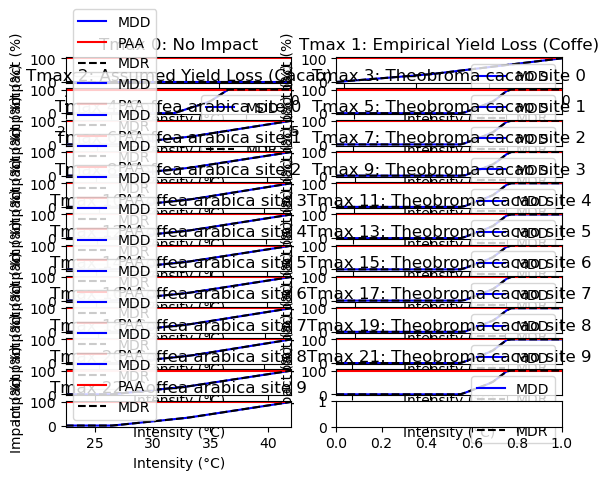

In [47]:
from typing import Optional
import pandas as pd
from climada.entity import ImpactFuncSet

def make_impf_set_mapper(
    canopy_df: pd.DataFrame,
    adjust_fcn,
    imp_fun_set_base: ImpactFuncSet
):
    """
    Returns a function impf_set_mapper(imp_fun_set_base, year) -> ImpactFuncSet
    with all other arguments fixed from this scope.
    """

    def impf_set_mapper(
        imp_fun_set: ImpactFuncSet,
        year: Optional[int] = None
    ) -> ImpactFuncSet:
        return create_adjusted_impact_function_set(
            canopy_df=canopy_df,
            imp_fun_set_base=imp_fun_set_base,
            adjust_fcn=adjust_fcn,
        )

    return impf_set_mapper


adjusted_impf_set = create_adjusted_impact_function_set(
    canopy_df=canopy_crop_dict[list(canopy_crop_dict.keys())[0]],  # Use the first sheet as the base
    imp_fun_set_base=imp_fun_set_base,
    adjust_fcn=adjust_fcn
)

adjusted_impf_set.plot()

array([[<Axes: title={'center': 'Tmax 0: No Impact'}, xlabel='Intensity (°C)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'Tmax 1: Empirical Yield Loss (Coffe)'}, xlabel='Intensity (°C)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'Tmax 2: Assumed Yield Loss (Cacao)'}, xlabel='Intensity (°C)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'Tmax 3: Theobroma cacao site 0'}, xlabel='Intensity (°C)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'Tmax 4: Coffea arabica site 0'}, xlabel='Intensity (°C)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'Tmax 5: Theobroma cacao site 1'}, xlabel='Intensity (°C)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'Tmax 6: Coffea arabica site 1'}, xlabel='Intensity (°C)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'Tmax 7: Theobroma cacao site 2'}, xlabel='Intensity (°C)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'Tmax 8: Coffea arabica site 2'}, xlabel='Intensity (°C)'

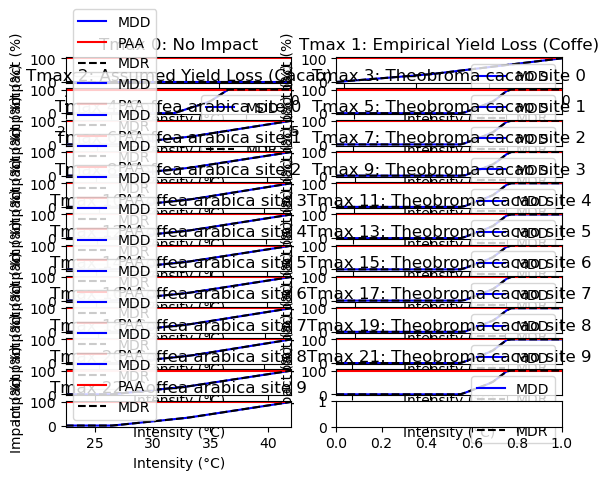

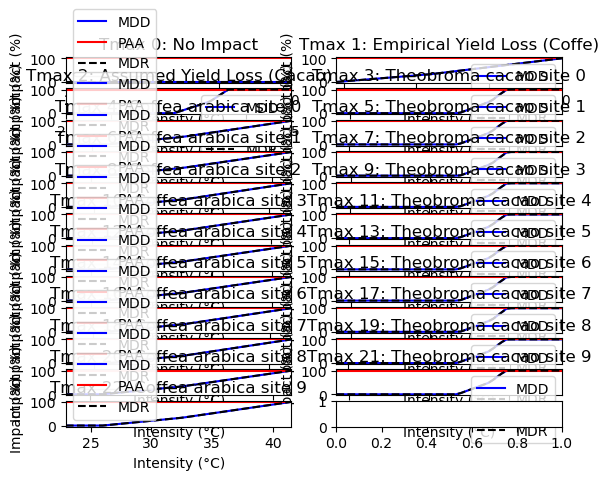

In [48]:
# Get the impact fucntion set for the present compostition
impf_set_present =  create_adjusted_impact_function_set(
    canopy_df=canopy_crop_dict['present'],  # Use the first sheet as the base
    adjust_fcn=adjust_fcn
)

# Get the impact fucntion set for the alternatvie
alternative_name = list(canopy_crop_dict.keys())[3]  # Use the second condition
impf_set_mapper = make_impf_set_mapper(canopy_df= canopy_crop_dict[alternative_name],
                                       adjust_fcn = adjust_fcn,
                                       imp_fun_set_base = imp_fun_set_base
)


new_impf_set = impf_set_mapper(impf_set_present)

impf_set_present.plot()
new_impf_set.plot()

### 7.2 Define the measures

In [49]:
from climada.engine.option_appraisal.appraiser import MeasuresAppraiser

# Define the measure
from climada.entity.measures.base import Measure
from climada.entity.measures import MeasureSet
from climada.entity.measures.cost_income import CostIncome

In [50]:
# Define a measure list
meas_list = []

# Make the measures for each composition in the canopy_crop_dict except 'present'
for comp in canopy_crop_dict.keys():
    if comp == 'present':
        continue
    else:
        # Get the canopy DataFrame for the composition
        canopy_df = canopy_crop_dict[comp]
        # Define the measure
        meas = Measure( haz_type= hazard_type,  # Use the hazard type defined earlier
                        name = comp,
                        # Make the exposures mapper
                        exposures_change = make_exposure_mapper(canopy_df=canopy_df,
                                                                spec_to_fcn=spec_to_fcn
                                                                ),
                        # Make the impact function set mapper
                        impfset_change = make_impf_set_mapper(canopy_df= canopy_df,
                                                                adjust_fcn = adjust_fcn,
                                                                imp_fun_set_base=imp_fun_set_base
                                                                ),
                        # Make the cost income from the canopy_df and costs_df
                        #cost_cashflows_df, _ = make_cashflows_costs(canopy_df, costs_df, years=10)
                        cost_income = make_cost_income_from_canopy_df(canopy_df=canopy_crop_dict[comp],
                                                                        costs_df=costs_df,
                                                                        column='Added'  # 'Added' or 'total'
                                                                    )
                        )
        # Add to the measure list
        meas_list.append(meas)


Try the measures

Exposures object for 'present' condition:
+----+-----------+---------------------+----------+------------------+---------------------------+--------------------+-----------+-------------+------------+----------------+---------------------+----------------------+------------------------+----------------------------+-------------------------------+-----------+-------------------------------+--------------------------+------------------+----------------+----------------------+-------------------+----------------------+-------------+------------------+---------+----------------------------------------------+
|    |   Plot ID | Region              | System   |   Plot size (ha) | Species                   | Scientific name    | Role      |   Plants/ha |   Kg/plant |   Tonnes/plant |   Yield (t/ha/year) |   Price/tonnes (USD) |   Per-tree shading (%) |   Planting cost (per tree) |   Maintenance cost (per tree) |   site_id |   Per-tree shading (%) scaled |   Shade contribution (%) |   Tree Sha

array([[<Axes: title={'center': 'Tmax 0: No Impact'}, xlabel='Intensity (°C)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'Tmax 1: Empirical Yield Loss (Coffe)'}, xlabel='Intensity (°C)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'Tmax 2: Assumed Yield Loss (Cacao)'}, xlabel='Intensity (°C)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'Tmax 3: Theobroma cacao site 0'}, xlabel='Intensity (°C)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'Tmax 4: Coffea arabica site 0'}, xlabel='Intensity (°C)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'Tmax 5: Theobroma cacao site 1'}, xlabel='Intensity (°C)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'Tmax 6: Coffea arabica site 1'}, xlabel='Intensity (°C)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'Tmax 7: Theobroma cacao site 2'}, xlabel='Intensity (°C)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'Tmax 8: Coffea arabica site 2'}, xlabel='Intensity (°C)'

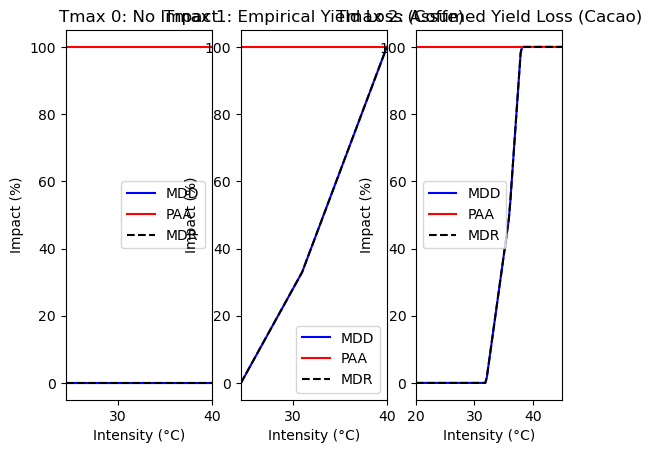

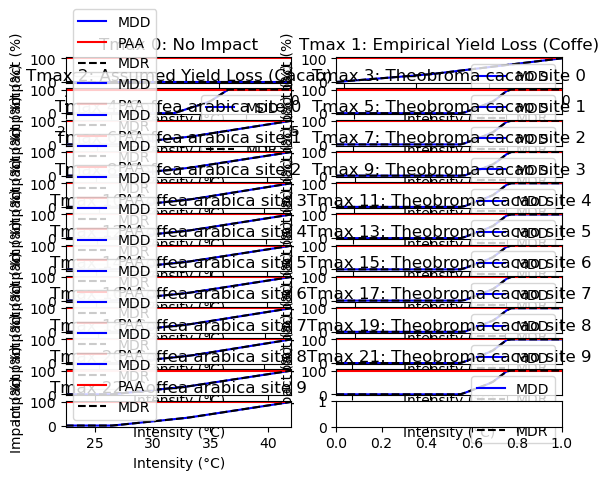

In [51]:
exp_new, impf_set_new, haz_new = meas.apply(exposures = exp_present,
                                            impfset = imp_fun_set_base,
                                            hazard = haz_dict['today']  # Use the hazard for today (or 'present' condition
)


# Print the Exposures object to verify
print("Exposures object for 'present' condition:")
print(tabulate(exp_present.gdf, headers='keys', tablefmt='psql'))

# Print the Exposures object to verify
print(f"Exposures object for {alternative_name}") 
print(tabulate(exp_new.gdf, headers='keys', tablefmt='psql'))

imp_fun_set_base.plot()
impf_set_new.plot()

In [52]:
# Gather all measures in a measure set
meas_set = MeasureSet(measures=meas_list)

# 8 – Cost and Revenue Estimates (Add Average Canopy)

In this stage, we manually calculate the costs and benefits by estimating yield for both the present and the future under different canopy scenarios.  
To calculate the future yield, we account for the risk difference between scenarios, adjusting for changes in canopy cover.


### 8.1 – Calculate Impacts

- Compute the **Annual Average Loss (AAL)** to estimate the expected NPV.  
- Calculate the **return period (RP)** losses to reflect revenue in a bad year.

In [53]:
from calendar import c
from climada.engine import ImpactCalc

# Initialize dictionaries to store results:
# - impacts_dict will hold Impact objects for each scenario and composition
# - exp_dict will hold Exposure objects for each scenario and composition
impacts_dict = {
    'today': {},   # Impacts for present-day baseline and measures
    'future': {}   # Impacts for future climate conditions
}
exp_dict = copy.deepcopy(impacts_dict)

# --- Create baseline (present) exposure and impact function set ---

# Create an adjusted impact function set for the present condition
# This modifies the base impact functions according to canopy cover (cooling effect)
impf_set_present = create_adjusted_impact_function_set(
    canopy_df=canopy_crop_dict['present'],
    adjust_fcn=adjust_fcn,                     # Function to adjust impact curve by canopy
    imp_fun_set_base=imp_fun_set_base          # Base impact function set (unadjusted)
)

# Create the exposure object for the present condition
# This assigns asset values and metadata to each site based on the present canopy composition
exp_present = make_exposures_from_canopy_df(
    canopy_df=canopy_crop_dict['present'],
    spec_to_fcn=spec_to_fcn                     # Mapping from species to impact function ID
)

# --- Loop over climate scenarios ('today' and 'future') ---
for climate_scenario in ['today', 'future']:
    haz = haz_dict[climate_scenario]  # Select hazard object for this scenario

    # Loop over all canopy compositions (baseline + adaptation measures)
    for comp in canopy_crop_dict.keys():

        # If this is the baseline 'present' composition, use the already prepared exposure and IFS
        if comp == 'present':
            exp = exp_present
            ifs = impf_set_present

        # If this is an alternative composition (adaptation measure)
        else:
            meas = meas_set.measures()[comp]     # Retrieve the measure object by name
            # Apply the measure to the present exposure & impact functions
            # This can modify exposure (e.g., yield, value), impact functions, and hazards
            exp, ifs, _ = meas.apply(exp_present, impf_set_present, haz)

        # --- Calculate and store results ---
        # Compute the impact for this exposure, impact function set, and hazard
        impacts_dict[climate_scenario][comp] = ImpactCalc(exp, ifs, haz).impact(save_mat=False)

        # Store the exposure (only for 'today' scenario to avoid duplication)
        if climate_scenario == 'today':
            exp_dict[climate_scenario][comp] = exp


### 8.2 – Calculate the Cost and Revenue Metrics

In this step, compute the key financial metrics for each canopy composition and climate scenario, including:  
- **Total Costs** – Planting, maintenance, and replacement over the analysis period.  
- **Total Revenues** – Estimated from yield–canopy relationships and adjusted for hazard impacts.  
- **Net Present Value (NPV)** – Discounted costs and revenues over time.  
- **Benefit–Cost Ratio (BCR)** – Ratio of total benefits to total costs.  
- **Net Benefits** – Revenues minus costs after discounting.

We perform this step-wise, as the future revenue is estimated based on the change in climate risk.  
We begin by retrieving the **Annual Average Loss (AAL)** and **return period losses** for each scenario to quantify  
expected revenue reductions in both normal and bad years.

In [54]:
import pandas as pd
from numpy import interp

rows = []

return_period = 100  # Example return period in years (used for bad-year loss calculation)

# Loop over all canopy compositions for the 'today' scenario
for comp in impacts_dict['today'].keys():

    # --- COSTS ---
    # Calculate the net present value (NPV) of total costs for this composition
    # make_cashflows_costs() returns a tuple, where index [1]['total'] is the NPV of total costs
    npv_total = make_cashflows_costs(
        canopy_df=canopy_crop_dict[comp],  # canopy composition DataFrame
        costs_df=costs_df,                 # cost data
        disc_rate=disc_rate                 # discount rate
    )[1]['total']

    # --- REVENUES (Present Scenario) ---
    # Get the exposure GeoDataFrame for 'today' and this composition
    exp_today = exp_dict['today'][comp].gdf

    # Total average annual revenue (sum of all site values)
    total_today = exp_today['value'].sum()

    # Average revenue for main crop only
    total_main = exp_today.loc[exp_today['Role'] == 'Main', 'value'].sum()

    # Average revenue for secondary crops
    total_secondary = exp_today.loc[exp_today['Role'] == 'Secondary', 'value'].sum()

    # --- AAL (Annual Average Loss) ---
    # Aggregate AAL (total) for today and future
    aal_today_total = impacts_dict['today'][comp].aai_agg
    aal_future_total = impacts_dict['future'][comp].aai_agg

    # AAL for main crop only
    idx_main = exp_today['Role'] == 'Main'
    aal_today_main = impacts_dict['today'][comp].eai_exp[idx_main].sum()
    aal_future_main = impacts_dict['future'][comp].eai_exp[idx_main].sum()

    # AAL for secondary crops
    idx_secondary = exp_today['Role'] == 'Secondary'
    aal_today_secondary = impacts_dict['today'][comp].eai_exp[idx_secondary].sum()
    aal_future_secondary = impacts_dict['future'][comp].eai_exp[idx_secondary].sum()

    # --- BAD-YEAR IMPACTS (Return Period Losses) ---
    # Calculate the impact frequency curve (IFC) for today
    ifc_today = impacts_dict['today'][comp].calc_freq_curve()
    # Interpolate the loss at the chosen return period (e.g., 1-in-30 year event)
    bad_year_today_total = interp(return_period, ifc_today.return_per, ifc_today.impact)

    # Do the same for the future scenario
    ifc_future = impacts_dict['future'][comp].calc_freq_curve()
    bad_year_future_total = interp(return_period, ifc_future.return_per, ifc_future.impact)

    # --- STORE RESULTS ---
    rows.append({
        "Composition": comp,
        "Avg. canopy cover": exp_today['canopy_cover'].mean(),  # average canopy % for this comp
        "Costs (NPV)": npv_total,

        # Revenue metrics (today)
        "Avg. Revenue – Total (today)": total_today,
        "Avg. Revenue – Main (today)": total_main,
        "Avg. Revenue – Secondary (today)": total_secondary,

        # AAL metrics
        "_AAL – Total (today)": aal_today_total,
        "_AAL – Main (today)": aal_today_main,
        "_AAL – Secondary (today)": aal_today_secondary,
        "_AAL – Total (future)": aal_future_total,
        "_AAL – Main (future)": aal_future_main,
        "_AAL – Secondary (future)": aal_future_secondary,

        # Bad-year impacts (total only here, but could split by crop type)
        "_Bad year impact – Total (today)": bad_year_today_total,
        "_Bad year impact – Total (future)": bad_year_future_total
    })

# Create DataFrame from collected rows
df_abs = pd.DataFrame(rows)  # Preserves insertion order for columns
print(tabulate(df_abs, headers='keys', tablefmt='psql'))


+----+-----------------+---------------------+---------------+--------------------------------+-------------------------------+------------------------------------+------------------------+-----------------------+----------------------------+-------------------------+------------------------+-----------------------------+------------------------------------+-------------------------------------+
|    | Composition     |   Avg. canopy cover |   Costs (NPV) |   Avg. Revenue – Total (today) |   Avg. Revenue – Main (today) |   Avg. Revenue – Secondary (today) |   _AAL – Total (today) |   _AAL – Main (today) |   _AAL – Secondary (today) |   _AAL – Total (future) |   _AAL – Main (future) |   _AAL – Secondary (future) |   _Bad year impact – Total (today) |   _Bad year impact – Total (future) |
|----+-----------------+---------------------+---------------+--------------------------------+-------------------------------+------------------------------------+------------------------+-------------

Calcualte the estimated future revenue

**📋 Column Descriptions (est_df)**

| Column name                                | Description                                                                 |
|--------------------------------------------|-----------------------------------------------------------------------------|
| Composition                                | Scenario / canopy composition (e.g., `present`, `shade_-20`, `cacao_to_coffee`) |
| Avg. canopy cover                          | Average canopy cover (%) under this composition                             |
| Costs (NPV)                                | Net Present Value (NPV) of planting and maintenance costs                   |
| Avg. Revenue – Total (today)               | Expected average annual total revenue under historical climate              |
| AAL % – Total (today)                      | Average Annual Loss (AAL) fraction of total revenue under historical hazards |
| AAL % – Total (future)                     | Average Annual Loss (AAL) fraction of total revenue under future hazards     |
| Avg. Revenue - Bad Year – Total (today)    | Expected total revenue in a hazard “bad year” (historical climate)           |
| Avg. Revenue – Total (future)              | Expected average annual total revenue under future climate                   |
| Avg. Revenue - Bad Year – Total (future)   | Expected total revenue in a hazard “bad year” (future climate)               |
| Avg. Revenue – Main (today)                | Expected average revenue from the main crop under historical climate         |
| AAL % – Main (today)                       | Average Annual Loss (AAL) fraction of main crop revenue (historical)         |
| AAL % – Main (future)                      | Average Annual Loss (AAL) fraction of main crop revenue (future)             |
| Avg. Revenue – Main (future)               | Expected average revenue from the main crop under future climate             |
| Avg. Revenue – Secondary (today)           | Expected average revenue from secondary crops under historical climate       |
| AAL % – Secondary (today)                  | Average Annual Loss (AAL) fraction of secondary crop revenue (historical)    |
| AAL % – Secondary (future)                 | Average Annual Loss (AAL) fraction of secondary crop revenue (future)        |
| Avg. Revenue – Secondary (future)          | Expected average revenue from secondary crops under future climate           |


In [55]:
import pandas as pd

est_values_rows = []

for _, row in df_abs.iterrows():
    npv_total = row["Costs (NPV)"]

    # ==== TOTAL ====
    total_today = row["Avg. Revenue – Total (today)"]
    aal_today_total_pct = (row["_AAL – Total (today)"] / total_today) * 100
    aal_future_total_pct = (row["_AAL – Total (future)"] / total_today) * 100

    bad_year_today_total = total_today - (
        row["_Bad year impact – Total (today)"] - row["_AAL – Total (today)"]
    )
    total_future_total = (total_today / (1 - aal_today_total_pct / 100)) * (1 - aal_future_total_pct / 100)
    bad_year_future_total = total_future_total - (
        (row["_Bad year impact – Total (future)"] - row["_AAL – Total (future)"]) / total_today * total_future_total
    )

    # ==== MAIN ====
    main_today = row["Avg. Revenue – Main (today)"]
    aal_today_main_pct = (row["_AAL – Main (today)"] / main_today) * 100 if main_today > 0 else np.nan
    aal_future_main_pct = (row["_AAL – Main (future)"] / main_today) * 100 if main_today > 0 else np.nan
    main_future = (main_today / (1 - aal_today_main_pct / 100)) * (1 - aal_future_main_pct / 100) 

    # ==== SECONDARY ====
    secondary_today = row["Avg. Revenue – Secondary (today)"]
    aal_today_secondary_pct = (row["_AAL – Secondary (today)"] / secondary_today) * 100 if secondary_today > 0 else np.nan
    aal_future_secondary_pct = (row["_AAL – Secondary (future)"] / secondary_today) * 100 if secondary_today > 0 else  np.nan
    secondary_future = (secondary_today / (1 - aal_today_secondary_pct / 100)) * (1 - aal_future_secondary_pct / 100)

    est_values_rows.append({
        "Composition": row["Composition"],
        "Avg. canopy cover": row["Avg. canopy cover"],
        "Costs (NPV)": npv_total,

        # Total
        "Avg. Revenue – Total (today)": total_today,
        "AAL % – Total (today)": aal_today_total_pct,
        "AAL % – Total (future)": aal_future_total_pct,
        "Avg. Revenue - Bad Year – Total (today)": bad_year_today_total,
        "Avg. Revenue – Total (future)": total_future_total,
        "Avg. Revenue - Bad Year – Total (future)": bad_year_future_total,

        # Main
        "Avg. Revenue – Main (today)": main_today,
        "AAL % – Main (today)": aal_today_main_pct,
        "AAL % – Main (future)": aal_future_main_pct,
        "Avg. Revenue – Main (future)": main_future,

        # Secondary
        "Avg. Revenue – Secondary (today)": secondary_today,
        "AAL % – Secondary (today)": aal_today_secondary_pct,
        "AAL % – Secondary (future)": aal_future_secondary_pct,
        "Avg. Revenue – Secondary (future)": secondary_future
    })

# Create DataFrame
est_values_df = pd.DataFrame(est_values_rows)
print(tabulate(est_values_df, headers="keys", tablefmt="psql"))

# # Print the average revenu for the main for today and future for eahc composition
print("Average Revenue for Main (today):")
print(tabulate(est_values_df[["Composition", "Avg. Revenue – Main (today)", "Avg. Revenue – Main (future)"]], headers="keys", tablefmt="psql"))

+----+-----------------+---------------------+---------------+--------------------------------+-------------------------+--------------------------+-------------------------------------------+---------------------------------+--------------------------------------------+-------------------------------+------------------------+-------------------------+--------------------------------+------------------------------------+-----------------------------+------------------------------+-------------------------------------+
|    | Composition     |   Avg. canopy cover |   Costs (NPV) |   Avg. Revenue – Total (today) |   AAL % – Total (today) |   AAL % – Total (future) |   Avg. Revenue - Bad Year – Total (today) |   Avg. Revenue – Total (future) |   Avg. Revenue - Bad Year – Total (future) |   Avg. Revenue – Main (today) |   AAL % – Main (today) |   AAL % – Main (future) |   Avg. Revenue – Main (future) |   Avg. Revenue – Secondary (today) |   AAL % – Secondary (today) |   AAL % – Secondary (

### 8.3 – Ad-hoc Analyses and Risk Attribution

In the following subsections, we make use of the `est_values_df` results to perform **analytical derivations** that complement the main cost–benefit analysis.  
These additional explorations provide insight into how changes in canopy composition and climate hazards affect revenues.

Specifically, we look at:

- **Risk attribution** – separating the contribution of **climate hazard risk** (e.g., VPD/Tmax impacts) from other factors (management, yield potential).  
- **Gain attribution** – identifying the compensating effects (e.g., increased shade, secondary crop revenues) that offset risk losses.  
- **Relative shifts** – expressing results as percentage changes relative to the baseline system to highlight trade-offs in farmer decision-making.  

These exploratory analyses are not calibrated models on their own, but rather serve as **diagnostic tools** to help interpret the drivers of net changes in revenues across scenarios.


#### 8.3.1 – Analyze the yield to canopy

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# --- same helper as before ---
def _resolve_col(df, name):
    """Match column allowing for hyphen/en-dash/em-dash and thin spaces."""
    want = name.replace("—", "-").replace("–", "-").replace("\u2009", " ").strip()
    for col in df.columns:
        norm = col.replace("—", "-").replace("–", "-").replace("\u2009", " ").strip()
        if norm == want:
            return col
    raise ValueError(f"Column '{name}' not found. Available: {list(df.columns)}")

def plot_normalized_annual_revenue(
    df,
    role='Main',                 # 'Total' | 'Main' | 'Secondary'
    baseline_comp='present',     # composition to normalize against
    show_labels=False,
    normalize_to='today',        # 'today' | 'future' | 'separate'
):
    # --- Colors to match the attribution plot ---
    LINE_TODAY  = "dimgray"   # present = dark grey
    LINE_FUTURE = "black"     # future  = black

    # Columns (robust to dash variants)
    col_today  = _resolve_col(df, f"Avg. Revenue – {role} (today)")
    col_future = _resolve_col(df, f"Avg. Revenue – {role} (future)")
    col_comp   = _resolve_col(df, "Composition")
    col_canopy = _resolve_col(df, "Avg. canopy cover")

    # Baseline row
    base = df.loc[df[col_comp] == baseline_comp]
    if base.empty:
        raise ValueError(f"Baseline composition '{baseline_comp}' not found.")
    base = base.iloc[0]
    base_today   = float(base[col_today])
    base_future  = float(base[col_future])
    base_canopy  = float(base[col_canopy])

    # Denominators / tags (for legend text)
    if normalize_to == 'today':
        denom_today  = base_today
        denom_future = base_today
        tag_today, tag_future = "today", "today"
    elif normalize_to == 'future':
        denom_today  = base_future
        denom_future = base_future
        tag_today, tag_future = "future", "future"
    elif normalize_to == 'separate':
        denom_today  = base_today
        denom_future = base_future
        tag_today, tag_future = "today", "future"
    else:
        raise ValueError("normalize_to must be 'today', 'future', or 'separate'.")

    if denom_today == 0 or denom_future == 0:
        raise ValueError("Baseline denominator is zero; cannot normalize.")

    # Prepare & normalize (% change wrt denominators)
    d = df.copy().sort_values(col_canopy)
    d["norm_today"]  = (d[col_today]  / denom_today  - 1.0) * 100.0
    d["norm_future"] = (d[col_future] / denom_future - 1.0) * 100.0

    # Baseline markers (what each series equals at the baseline composition)
    y_base_today  = (base_today  / denom_today  - 1.0) * 100.0
    y_base_future = (base_future / denom_future - 1.0) * 100.0

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Short, clear legend labels
    lbl_today  = f"Today (norm: {baseline_comp} @ {tag_today})"
    lbl_future = f"Future (norm: {baseline_comp} @ {tag_future})"

    ax.plot(d[col_canopy], d["norm_today"],  marker="o", label=lbl_today,  color=LINE_TODAY)
    ax.plot(d[col_canopy], d["norm_future"], marker="o", label=lbl_future, color=LINE_FUTURE)

    if show_labels:
        for _, r in d.iterrows():
            ax.text(r[col_canopy], r["norm_today"],  r[col_comp],
                    fontsize=8, ha="right", va="bottom", color=LINE_TODAY)
            ax.text(r[col_canopy], r["norm_future"], r[col_comp],
                    fontsize=8, ha="left",  va="bottom", color=LINE_FUTURE)

    # Baseline composition rings (same style; two points may differ in y)
    ax.scatter([base_canopy], [y_base_today],  s=160, facecolors="none",
               edgecolors="grey", linewidths=2, zorder=5)
    ax.scatter([base_canopy], [y_base_future], s=160, facecolors="none",
               edgecolors="grey", linewidths=2, zorder=5)

    # Baseline horizontal line at 0%
    ax.axhline(0.0, color="grey", linestyle="--", linewidth=1)

    # Axes & title (more pedagogical)
    ax.set_xlabel("Average canopy cover (%)")
    ax.set_ylabel(f"Change in average annual revenue vs baseline ({role}) [%]")
    baseline_tag = f"{tag_today}" if normalize_to != 'separate' else "today & future"
    ax.set_title(
        f"Normalized Annual Revenue vs Canopy Cover — {role}\n"
        f"Baseline: '{baseline_comp}' (normalization reference: {baseline_tag})"
    )
    ax.grid(True, axis="y", linestyle=":", alpha=0.9)

    # Legend helpers (boxed, below plot — like the other function)
    zero_line = Line2D([0], [0], color='grey', linestyle='--', linewidth=1,
                       label="No change vs baseline (0%)")
    base_ring = Line2D([0], [0], marker='o', linestyle='None',
                       markerfacecolor='none', markeredgecolor='grey',
                       markersize=10, label=f"Baseline composition: {baseline_comp}")

    handles, labels = ax.get_legend_handles_labels()
    handles += [zero_line, base_ring]
    labels  += ["No change vs baseline (0%)", f"Baseline composition: {baseline_comp}"]

    leg = fig.legend(
        handles, labels,
        loc="lower center", ncol=2,
        bbox_to_anchor=(0.5, -0.02),
        frameon=True, fancybox=True, framealpha=0.95,
        edgecolor="0.5", facecolor="white",
        borderpad=0.8, handlelength=2
    )
    leg.get_frame().set_linewidth(1.2)

    # leave room for the legend box
    fig.tight_layout(rect=[0, 0.18, 1, 1])
    return fig, ax


In [57]:
print(tabulate(est_values_df, headers="keys", tablefmt="psql"))

+----+-----------------+---------------------+---------------+--------------------------------+-------------------------+--------------------------+-------------------------------------------+---------------------------------+--------------------------------------------+-------------------------------+------------------------+-------------------------+--------------------------------+------------------------------------+-----------------------------+------------------------------+-------------------------------------+
|    | Composition     |   Avg. canopy cover |   Costs (NPV) |   Avg. Revenue – Total (today) |   AAL % – Total (today) |   AAL % – Total (future) |   Avg. Revenue - Bad Year – Total (today) |   Avg. Revenue – Total (future) |   Avg. Revenue - Bad Year – Total (future) |   Avg. Revenue – Main (today) |   AAL % – Main (today) |   AAL % – Main (future) |   Avg. Revenue – Main (future) |   Avg. Revenue – Secondary (today) |   AAL % – Secondary (today) |   AAL % – Secondary (

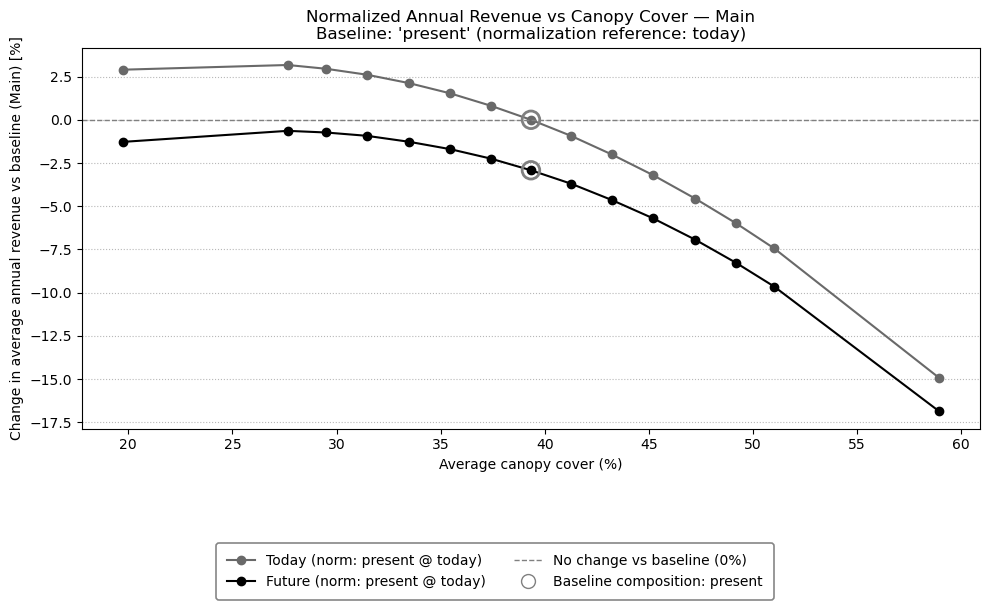

In [58]:
# Remove both 'cacao_to_coffee' and 'coffee_to_cacao' to only focus in the canopy cover to yield trade-off
plot_df = est_values_df[
    (est_values_df["Composition"] != "cacao_to_coffee") &
    (est_values_df["Composition"] != "coffee_to_cacao")
].copy()

fig, ax = plot_normalized_annual_revenue(plot_df, role='Main', baseline_comp='present', show_labels=False, normalize_to='today')

# SAve teh figure in the results folder OUTPUT_DIR
fig.savefig(f"{OUTPUT_DIR}/annual_revenue_normalized_main_today.png", dpi=300, bbox_inches='tight')



#### 8.3.2 – Future Revenue & Risk Attribution (relative to baseline **c**)

We treat $Y_p(\cdot)$ as the **present, realized (risk-affected) expected revenue**.  
To separate canopy (biophysical) effects from hazard effects, we introduce the **hazard-less potential** $ Y_0(\cdot) $.

##### Modeling basis – Losses due to Hazard

The **observed baseline revenues** $Y_p(x)$ are already *realized outcomes* — they include the effects of present hazards (in the same way that historical agricultural yield data reflect climate variability and losses).  

To separate canopy (biophysical) potential from hazard impacts, we introduce a notional **hazard-less potential** $Y_0(x)$. This is not directly observable, but serves as a bookkeeping device: realized yield is obtained by scaling down $Y_0(x)$ according to hazard-induced losses.  

Let $L_p(x)$ and $L_f(x)$ be the random annual losses at canopy $x$ under **present** and **future** climates, respectively. The **Annual Average Loss (AAL)** is the expected **fraction** of the hazard-less potential:
$$
\mathrm{AAL}_p(x)=\frac{\mathbb{E}[L_p(x)]}{Y_0(x)},\qquad
\mathrm{AAL}_f(x)=\frac{\mathbb{E}[L_f(x)]}{Y_0(x)}.
$$

Realized (risk-affected) expected revenues are therefore:
$$
Y_p(x)=Y_0(x)\,[1-\mathrm{AAL}_p(x)],\qquad
Y_f(x)=Y_0(x)\,[1-\mathrm{AAL}_f(x)].
$$

From the table (which contains $Y_p$ and $\mathrm{AAL}_p$, you can back out the hazard-less potential:
$$
Y_0(x)=\frac{Y_p(x)}{1-\mathrm{AAL}_p(x)}.
$$

*All AAL inputs are fractions (e.g., $5\%\Rightarrow 0.05$ ).*


--- 

##### Notation
- Baseline canopy: $c$. Alternative: $c'$.
- Present raw revenue at canopy $x$: $Y_p(x)$.
- AAL fractions: $\mathrm{AAL}_p(x),\ \mathrm{AAL}_f(x)\in[0,1)$.
- **Retention (future vs present)**:
$$
R(x)=\frac{1-\mathrm{AAL}_f(x)}{1-\mathrm{AAL}_p(x)}.
$$
- **Gain ratio (present canopy effect)**:
$$
g(c',c)=\frac{Y_p(c')}{Y_p(c)}, \qquad \text{so } g(c,c)=1.
$$
- **Risk ratio (relative retention)**:
$$
r(c',c)=\frac{R(c')}{R(c)}.
$$

---

##### Core equations

**Future revenue if you keep vs. switch**
$$
Y_f(c')=Y_p(c')\,R(c')=Y_p(c)\,g(c',c)\,R(c').
$$

**Decision rule (is switching beneficial?)**
$$
\rho=\frac{Y_f(c')}{Y_f(c)} = g(c',c)\,r(c',c).
$$
Beneficial iff $\rho>1$.

---

##### Present-year attribution (using present AALs)

We calculate the risk and gain attributions such that their sum exactly equals the total present change, i.e. $\Delta Y_{\text{present}}(c',c) = \Delta\mathrm{risk}_{\text{present}}(c',c) + \Delta\mathrm{gain}_{\text{present}}(c',c)$.

**Total present change**
$$
\Delta Y_{\text{present}}(c',c)
= Y_p(c') - Y_p(c).
$$

**Risk attribution (present)**
$$
\Delta\mathrm{risk}_{\text{present}}(c',c)
= Y_p(c)\,\Big([1-\mathrm{AAL}_p(c')]-[1-\mathrm{AAL}_p(c)]\Big).
$$

**Gain attribution (present)**
$$
\Delta\mathrm{gain}_{\text{present}}(c',c)
=\Delta Y_{\text{present}}(c',c)-\Delta\mathrm{risk}_{\text{present}}(c',c).
$$

---

##### Risk-first attribution (future)

**Total future change**
$$
\Delta Y_{\text{future}}(c',c)=Y_f(c')-Y_f(c).
$$

**Risk attribution (future)**
$$
\Delta\mathrm{risk}_{\text{future}}(c',c)=Y_p(c)\,\big[R(c')-R(c)\big].
$$

**Gain attribution (future) — simplified**
$$
\Delta\mathrm{gain}_{\text{future}}(c',c)
=\Delta Y_{\text{future}}(c',c)-\Delta\mathrm{risk}_{\text{future}}(c',c).
$$

---

*All AAL inputs must be **fractions** (e.g., $5\%\Rightarrow 0.05$).*


Derive the gain and risk attribution

In [59]:
import numpy as np
import pandas as pd

def derive_gain_risk_from_est(
    est_values_df: pd.DataFrame,
    baseline: str = "present",
    segment: str = "Total",           # "Total" | "Main" | "Secondary"
) -> pd.DataFrame:
    """
    Derive:
      - g(c',c), r(c',c), decision ratios,
      - present & future risk-first attributions (with future risk via R by default).

    Notes:
      - ΔY_present uses raw Yp: Yp(c') - Yp(c)
      - Δrisk_future uses R: Yp(c) * (R(c') - R(c))
      - Δgain_* is always the residual: ΔY_* - Δrisk_*
    """

    seg_tok = {"total": "Total", "main": "Main", "secondary": "Secondary"}[
        segment.strip().lower()
    ]
    col_y_today  = f"Avg. Revenue – {seg_tok} (today)"   # Yp(x)
    col_y_future = f"Avg. Revenue – {seg_tok} (future)"  # Yf(x)
    col_aalp     = f"AAL % – {seg_tok} (today)"
    col_aalf     = f"AAL % – {seg_tok} (future)"

    df = est_values_df.copy()
    df["Segment"] = seg_tok

    # Inputs
    df["Yp"] = df[col_y_today]
    df["Yf"] = df[col_y_future]
    df["AALp_frac"] = df[col_aalp] / 100.0
    df["AALf_frac"] = df[col_aalf] / 100.0

    # Retention R(x) = (1 - AALf) / (1 - AALp)
    denom = (1 - df["AALp_frac"])
    df["R"] = np.where(denom > 0, (1 - df["AALf_frac"]) / denom, np.nan)

    # Baseline values (c)
    base = df.loc[df["Composition"] == baseline]
    if base.empty:
        raise ValueError(f"Baseline '{baseline}' not found.")
    base = base.iloc[0]
    Yp_c, Yf_c = base["Yp"], base["Yf"]
    AALp_c, AALf_c, R_c = base["AALp_frac"], base["AALf_frac"], base["R"]

    # Ratios and decisions
    df["g(c,c′)"] = df["Yp"] / Yp_c                     # gain ratio
    df["r(c,c′)"] = df["R"] / R_c                       # risk ratio
    df["ρ_future = Yf/Yf_baseline"] = df["Yf"] / Yf_c   # equals g*r if Yf=Yp*(1-AALf)
    df["Beneficial_vs_future_baseline"] = df["ρ_future = Yf/Yf_baseline"] > 1

    # --- Present attribution (using present AALs) ---
    df["ΔY_present"]    = df["Yp"] - Yp_c
    df["Δrisk_present"] = Yp_c * ((1 - df["AALp_frac"]) - (1 - AALp_c))
    df["Δgain_present"] = df["ΔY_present"] - df["Δrisk_present"]

    # --- Future attribution ---
    df["ΔY_future"] = df["Yf"] - Yf_c
    df["Δrisk_future"] = Yp_c * ((1 - df["AALf_frac"]) - (1 - AALf_c))
    df["Δgain_future"] = df["ΔY_future"] - df["Δrisk_future"]

    keep_cols = [
        "Composition","Segment",
        *(["Avg. canopy cover"] if "Avg. canopy cover" in df.columns else []),
        *(["Costs (NPV)"] if "Costs (NPV)" in df.columns else []),
        "Yp","Yf","AALp_frac","AALf_frac","R",
        "g(c,c′)","r(c,c′)",
        "ρ_future = Yf/Yf_baseline","Beneficial_vs_future_baseline",
        "ΔY_present","Δrisk_present","Δgain_present",
        "ΔY_future","Δrisk_future","Δgain_future",
    ]
    return df[keep_cols]

# Derive gain and risk from the estimated values DataFrame
df_gain_risk = derive_gain_risk_from_est(
    est_values_df=est_values_df,
    baseline='present',  # Use 'present' as the baseline composition
    segment='Main',     # Analyze total segment
)
print(tabulate(df_gain_risk, headers='keys', tablefmt='psql'))

+----+-----------------+-----------+---------------------+---------------+---------+---------+-------------+-------------+----------+-----------+-----------+-----------------------------+---------------------------------+--------------+-----------------+-----------------+-------------+----------------+----------------+
|    | Composition     | Segment   |   Avg. canopy cover |   Costs (NPV) |      Yp |      Yf |   AALp_frac |   AALf_frac |        R |   g(c,c′) |   r(c,c′) |   ρ_future = Yf/Yf_baseline | Beneficial_vs_future_baseline   |   ΔY_present |   Δrisk_present |   Δgain_present |   ΔY_future |   Δrisk_future |   Δgain_future |
|----+-----------------+-----------+---------------------+---------------+---------+---------+-------------+-------------+----------+-----------+-----------+-----------------------------+---------------------------------+--------------+-----------------+-----------------+-------------+----------------+----------------|
|  0 | present         | Main      | 

📊 Revenue Attribution Plots

The following figures show the **change in annual revenue** (relative to the *present* baseline)  
for different canopy alternatives. The attribution is split into:  

- **Δgain (orange bars):** changes due to canopy–yield function (biophysical gains/losses from shade).  
- **Δrisk (blue bars):** changes due to hazard impact attribution (heat and VPD risk adjustments).  
- **ΔY total (black line):** net effect (sum of Δgain and Δrisk).  

We look at different segments:  
- **Main crop** (coffee/cacao)  
- **Secondary crop** (banana, fruits)  
- **Total** (system-wide)  

---

❓ Reflection Questions
- Do you see cases where **yield–canopy gains (Δgain)** dominate over risk effects?  
  (e.g. does the curve shift upwards with more shade for the main crop?)  
- Conversely, are there scenarios where **risk attribution (Δrisk)** is the main driver of losses or gains?  
- How does this differ between the **Main** and **Secondary** segments?  
- For the **Total system**, which factor seems to dominate the net outcome:  
  yield–shade function or climate risk reduction?  


In [60]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_yield_attribution_grouped(
    est_values_df,
    baseline="present",
    segment="Main",        # "Total" | "Main" | "Secondary"
    view="future",         # "present" | "future"  (used in mode="attribution")
    sort_by=None,          # None | "delta" | "risk" | "gain" (ignored in mode="aal")
    relative=False,        # False -> absolute deltas; True -> % of baseline (only for mode="attribution")
    mode="attribution",    # "attribution" (risk/gain bars + total line) | "aal" (ΔYield% lines + ΔAAL bars)
):
    df_all = est_values_df.copy()
    figsize = (10, 6)

    # Colors
    RISK_COLOR  = "#d62728"   # red
    GAIN_COLOR  = "#2ca02c"   # green
    LINE_TODAY  = "dimgray"   # dark grey
    LINE_FUTURE = "black"

    def _resolve_col(df, name):
        want = name.replace("—", "-").replace("–", "-").replace("\u2009", " ").strip()
        for col in df.columns:
            norm = col.replace("—", "-").replace("–", "-").replace("\u2009", " ").strip()
            if norm == want:
                return col
        raise ValueError(f"Column '{name}' not found. Available: {list(df.columns)}")

    if mode == "attribution":
        df = derive_gain_risk_from_est(df_all, baseline=baseline, segment=segment)

        if view.lower() == "future":
            d_total, d_risk, d_gain = "ΔY_future", "Δrisk_future", "Δgain_future"
            base_den_col = "Yf"
            title_tag = "Future"
            baseline_expl = "evaluated under future climate"
            total_line_color = LINE_FUTURE
        else:
            d_total, d_risk, d_gain = "ΔY_present", "Δrisk_present", "Δgain_present"
            base_den_col = "Yp"
            title_tag = "Present"
            baseline_expl = "evaluated under today’s climate"
            total_line_color = LINE_TODAY

        if sort_by == "delta":
            df = df.sort_values(d_total)
        elif sort_by == "risk":
            df = df.sort_values(d_risk)
        elif sort_by == "gain":
            df = df.sort_values(d_gain)

        if relative:
            base_row = df.loc[df["Composition"] == baseline]
            if base_row.empty:
                raise ValueError(f"Baseline '{baseline}' not found in results.")
            denom = float(base_row.iloc[0][base_den_col])
            if denom == 0 or np.isnan(denom):
                raise ValueError(f"Baseline denominator for '{base_den_col}' is zero/NaN.")

            df["_risk_plot"]  = (df[d_risk]  / denom) * 100.0
            df["_gain_plot"]  = (df[d_gain]  / denom) * 100.0
            df["_total_plot"] = (df[d_total] / denom) * 100.0

            ylab  = f"Revenue change vs baseline ({segment}) [%]"
            risk_lbl  = "Attribution: change in vulnerability (hazard risk)"
            gain_lbl  = "Attribution: change due to other factors (incl. canopy-to-yield, increased # of plants etc.)"
            total_lbl = "Annual revenue change (relative, %)"
        else:
            df["_risk_plot"]  = df[d_risk]
            df["_gain_plot"]  = df[d_gain]
            df["_total_plot"] = df[d_total]

            ylab  = f"Revenue change vs baseline ({segment}) [currency]"
            risk_lbl  = "Attribution: change in climate hazard risk"
            gain_lbl  = "Attribution: other factors"
            total_lbl = "Annual revenue change (absolute)"

        x = np.arange(len(df))
        width = 0.35
        off   = width / 2

        fig, ax = plt.subplots(figsize=figsize)
        ax.bar(x - off, df["_risk_plot"].fillna(0).values, width,
               label=risk_lbl, color=RISK_COLOR)
        ax.bar(x + off, df["_gain_plot"].fillna(0).values, width,
               label=gain_lbl, color=GAIN_COLOR)
        ax.plot(x, df["_total_plot"].values, marker="o", linewidth=2,
                color=total_line_color, label=total_lbl)

        ax.axhline(0, linestyle="--", linewidth=1, color="0.4")
        ax.set_xticks(x)
        ax.set_xticklabels(df["Composition"].tolist(), rotation=45, ha="right")
        ax.set_ylabel(ylab)
        ax.set_title(f"Annual Revenue Change and Attribution — (Crop: {segment}, Scenario: {title_tag})")
        ax.grid(axis='y', linestyle=':', alpha=0.9)

        baseline_label  = f"Baseline: {baseline} ({baseline_expl})"
        baseline_handle = Line2D([0], [0], marker='o', linestyle='None',
                                 markerfacecolor='none', markeredgecolor='grey',
                                 markersize=10, label=baseline_label)

        handles, labels = ax.get_legend_handles_labels()
        handles += [baseline_handle]
        labels  += [baseline_label]
        leg = fig.legend(
            handles, labels,
            loc="lower center", ncol=2,
            bbox_to_anchor=(0.5, -0.00),
            frameon=True, fancybox=True, framealpha=0.95,
            edgecolor="0.5", facecolor="white",
            borderpad=0.8, handlelength=2
        )
        leg.get_frame().set_linewidth(1.2)
        fig.tight_layout(rect=[0, 0.18, 1, 1])
        return fig, ax

    elif mode == "aal":
        df = df_all.copy()

        col_comp   = _resolve_col(df, "Composition")
        col_y_t    = _resolve_col(df, f"Avg. Revenue – {segment} (today)")
        col_y_f    = _resolve_col(df, f"Avg. Revenue – {segment} (future)")
        col_a_t    = _resolve_col(df, f"AAL % – {segment} (today)")
        col_a_f    = _resolve_col(df, f"AAL % – {segment} (future)")

        base = df.loc[df[col_comp] == baseline]
        if base.empty:
            raise ValueError(f"Baseline composition '{baseline}' not found.")
        base = base.iloc[0]

        base_y_t = float(base[col_y_t])
        base_y_f = float(base[col_y_f])
        base_a_t = float(base[col_a_t])
        base_a_f = float(base[col_a_f])
        if base_y_t == 0 or base_y_f == 0:
            raise ValueError("Baseline revenue denominator is zero; cannot normalize.")

        df["_yield_today_pct"]  = (df[col_y_t] / base_y_t - 1.0) * 100.0
        df["_yield_future_pct"] = (df[col_y_f] / base_y_f - 1.0) * 100.0
        df["_aal_today_pp"]     = df[col_a_t] - base_a_t
        df["_aal_future_pp"]    = df[col_a_f] - base_a_f

        fig, ax = plt.subplots(figsize=figsize)
        x = np.arange(len(df))
        w = 0.35

        # Risk as bars (red for today, green for future)
        ax.bar(x - w/2, df["_aal_today_pp"].values,  width=w,
               label="ΔAAL (pp) today",  color=RISK_COLOR, alpha=0.95)
        ax.bar(x + w/2, df["_aal_future_pp"].values, width=w,
               label="ΔAAL (pp) future", color=GAIN_COLOR, alpha=0.95)

        # Yield change as lines (dark grey today, black future)
        ax.plot(x, df["_yield_today_pct"].values,  marker="o", linewidth=2,
                color=LINE_TODAY,  label="ΔYield % (today)")
        ax.plot(x, df["_yield_future_pct"].values, marker="o", linewidth=2,
                color=LINE_FUTURE, label="ΔYield % (future)")

        ax.axhline(0, linestyle="--", linewidth=1, color="0.4")
        ax.set_xticks(x)
        ax.set_xticklabels(df[col_comp].tolist(), rotation=45, ha="right")
        ax.set_ylabel("ΔYield (%) and ΔAAL (pp) vs baseline")
        ax.set_title(f"Yield & Risk Changes vs Baseline — Role: {segment}")
        ax.grid(axis='y', linestyle=':', alpha=0.9)

        baseline_label  = f"Baseline reference — {baseline}"
        baseline_handle = Line2D([0], [0], marker='o', linestyle='None',
                                 markerfacecolor='none', markeredgecolor='grey',
                                 markersize=10, label=baseline_label)

        handles, labels = ax.get_legend_handles_labels()
        handles += [baseline_handle]
        labels  += [baseline_label]
        leg = fig.legend(
            handles, labels,
            loc="lower center", ncol=2,
            bbox_to_anchor=(0.5, -0.02),
            frameon=True, fancybox=True, framealpha=0.95,
            edgecolor="0.5", facecolor="white",
            borderpad=0.8, handlelength=2
        )
        leg.get_frame().set_linewidth(1.2)
        fig.tight_layout(rect=[0, 0.2, 1, 1])
        return fig, ax

    else:
        raise ValueError("mode must be 'attribution' or 'aal'")


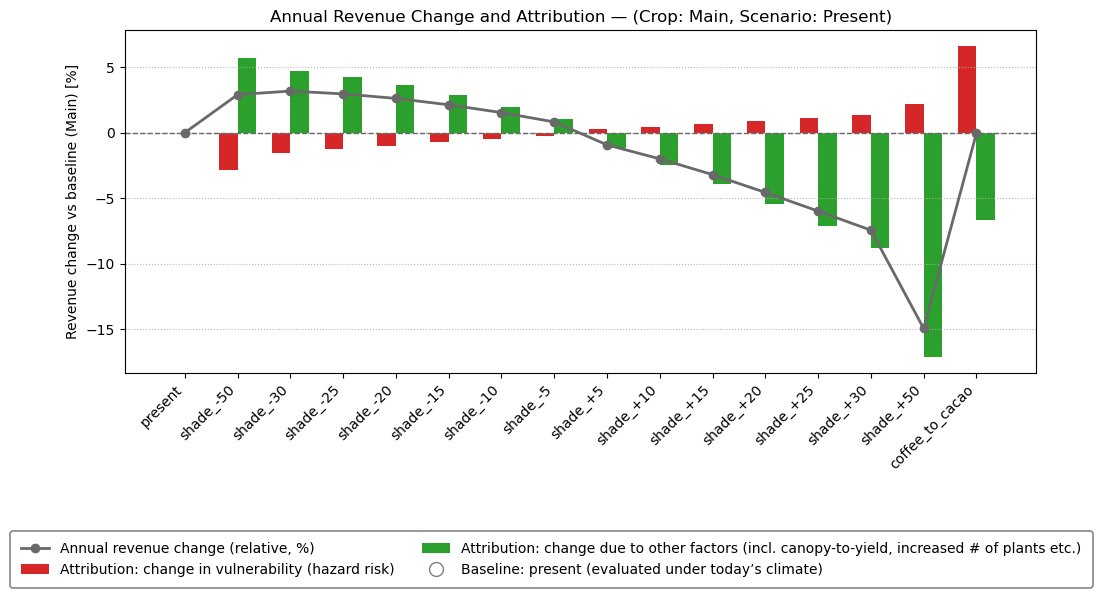

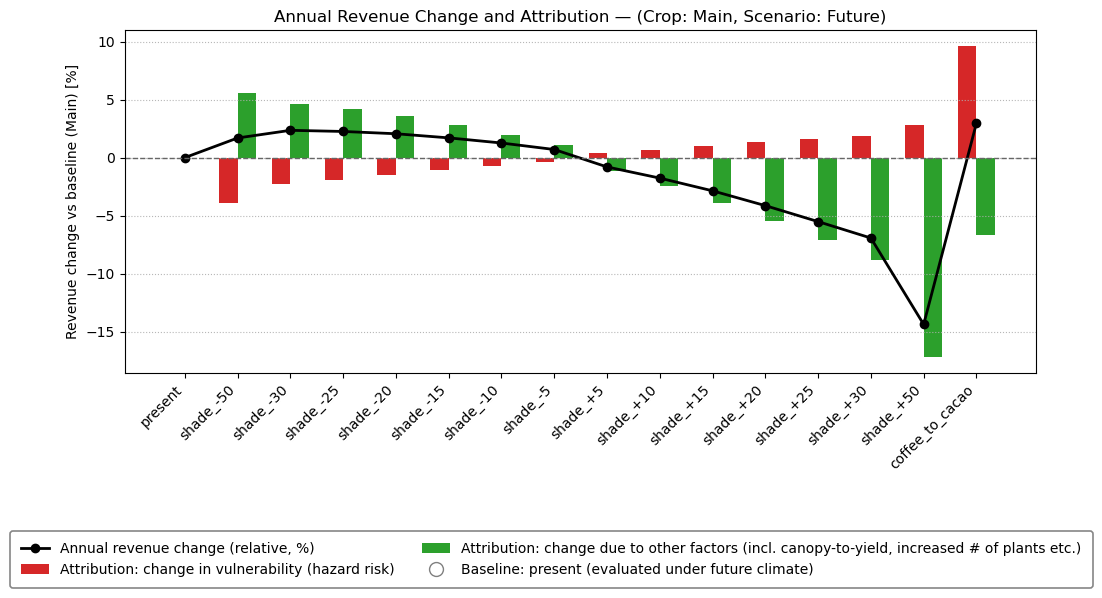

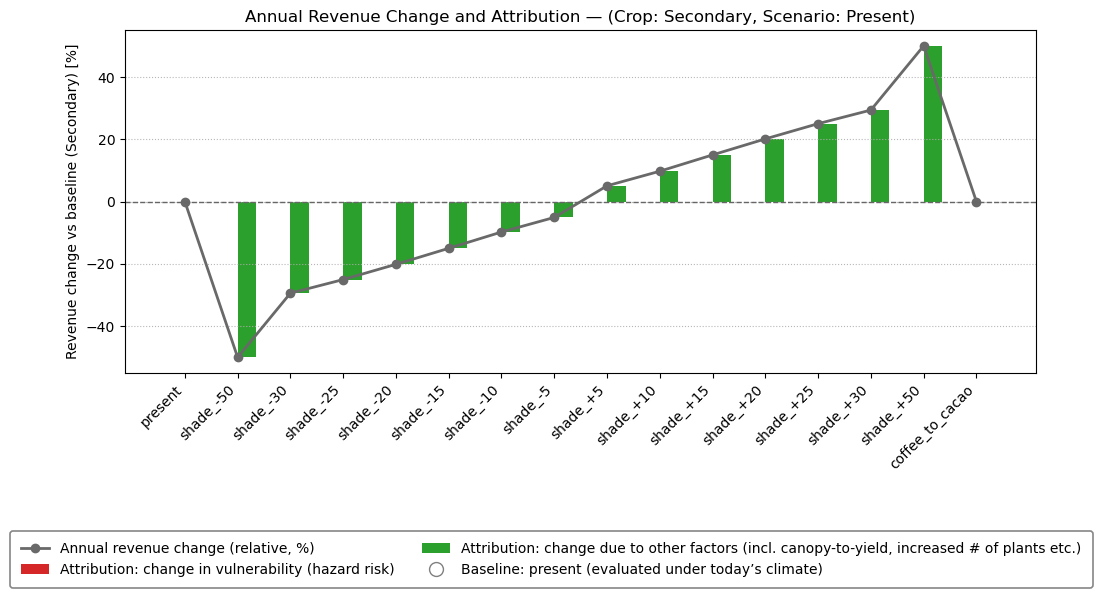

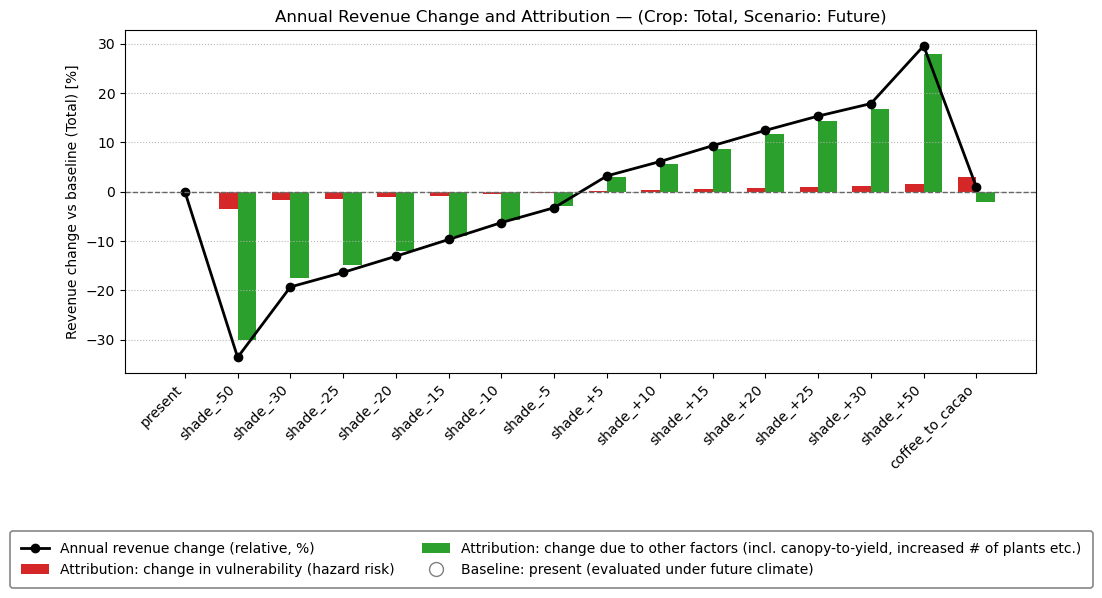

In [61]:
# Show the risk attribution for the change in annual revenue for the 'Main' segment for the 'present' baseline
fig, ax = plot_yield_attribution_grouped(est_values_df,
                                            baseline="present",
                                            segment="Main",
                                            view="today",
                                            sort_by=None,
                                            relative=True,
                                            mode="attribution")
plt.show()
# Save the figure in the results folder OUTPUT_DIR
fig.savefig(f"{OUTPUT_DIR}/annual_revenue_attribution_main_present.png", dpi=300, bbox_inches='tight')

fig, ax = plot_yield_attribution_grouped(est_values_df,
                                            baseline="present",
                                            segment="Main",
                                            view="future",
                                            sort_by=None,
                                            relative=True)
plt.show()
# Save the figure in the results folder OUTPUT_DIR
fig.savefig(f"{OUTPUT_DIR}/annual_revenue_attribution_main_future.png", dpi=300, bbox_inches='tight')

# Show the risk attribution for the change in annual revenue for the 'Secondary' segment for the 'future' baseline
fig, ax = plot_yield_attribution_grouped(est_values_df,
                                            baseline="present",
                                            segment="Secondary",
                                            view="present",
                                            sort_by=None,
                                            relative=True)
plt.show()
# Save the figure in the results folder OUTPUT_DIR
fig.savefig(f"{OUTPUT_DIR}/annual_revenue_attribution_secondary_present.png", dpi=300, bbox_inches='tight')

# Show the risk attribution for the change in annual revenue for the 'Total' segment for the 'future' baseline
fig, ax = plot_yield_attribution_grouped(est_values_df,
                                            baseline="present",
                                            segment="Total",
                                            view="future",
                                            sort_by=None,
                                            relative=True)
plt.show()
# Save the figure in the results folder OUTPUT_DIR
fig.savefig(f"{OUTPUT_DIR}/annual_revenue_attribution_total_future.png", dpi=300, bbox_inches='tight')


📊 Exposure vs. Revenue Attribution (Today only)

We can now compare the two:
- **Exposure attribution** (composition of crop value by Role/Species)  
- **Revenue attribution** (annual revenue change vs. baseline, attributed to yield–canopy gains vs. risk adjustments)

⚠️ Note: Revenue attribution is only implemented for the *today* scenario in this workflow.


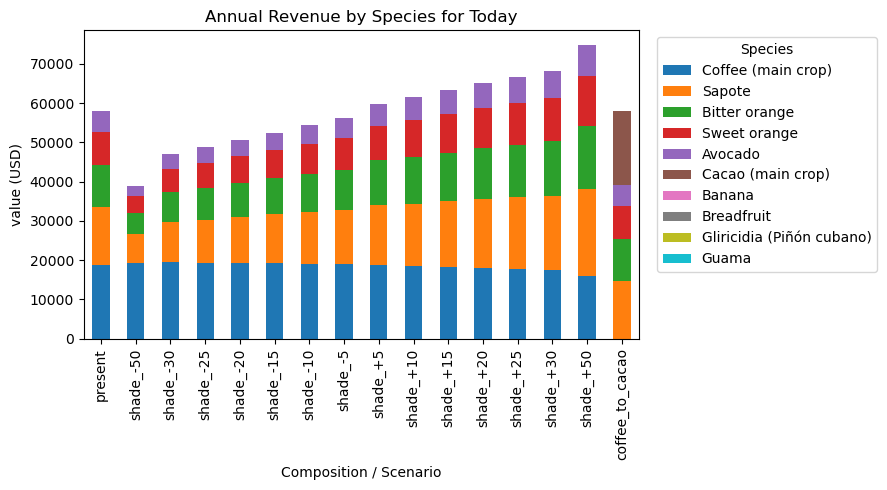

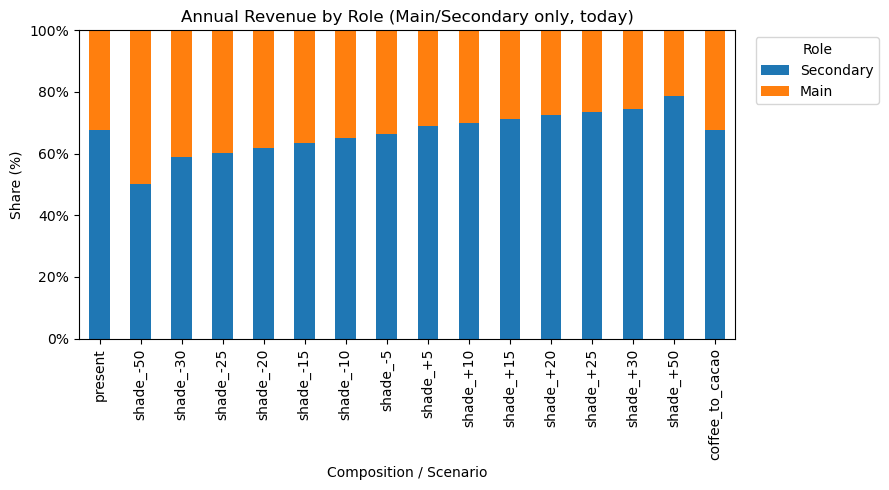

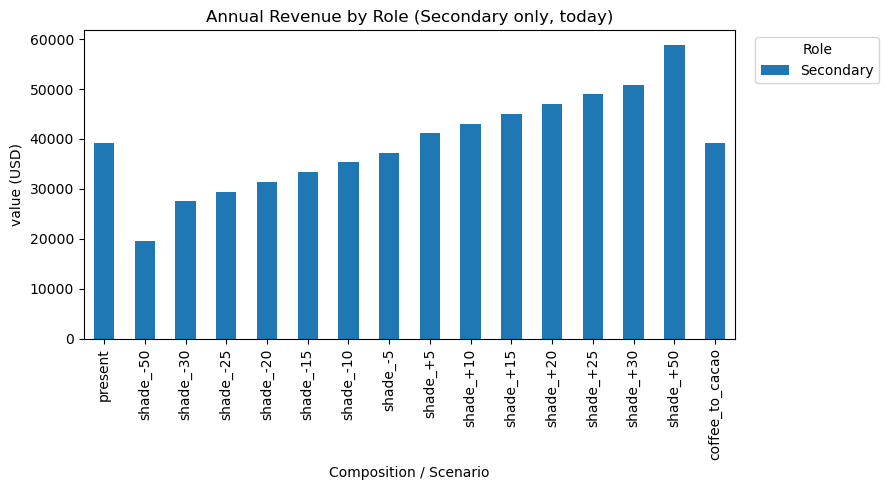

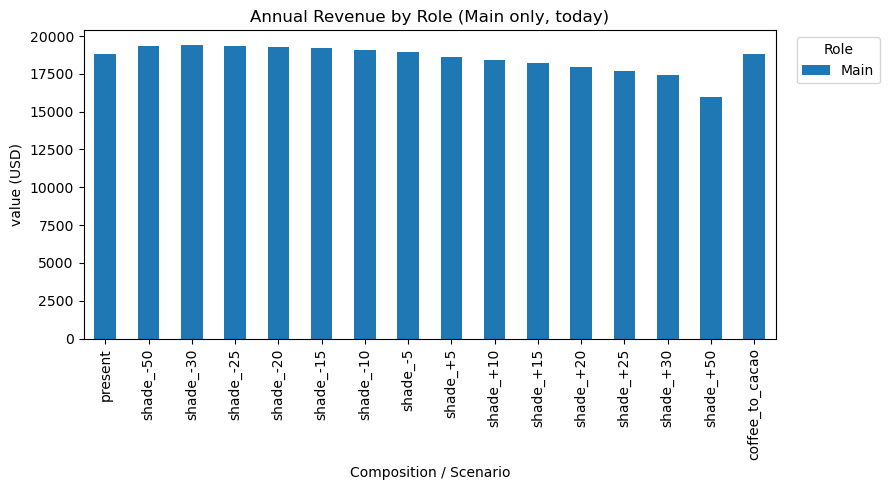

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

def plot_value_stacked_simple(
    exp_dict,
    group_col='Species',      # e.g. 'Role' or 'Species'
    day='today',
    subset=None,              # list of group_col values to show (others -> "Other" or dropped)
    include_other=True,       # if True, non-subset groups collapse to "Other"; if False, they’re dropped
    as_percent=False,         # if True, each bar sums to 100%
    title=None,
):
    """
    Stacked bars by `group_col` across compositions (exp_dict[day].keys()).
    Minimal API. Use `subset` to control which groups appear in the stack.

    Parameters
    ----------
    exp_dict : dict
        exp_dict[day][comp] must have a .gdf (or be a DataFrame) with columns:
        [group_col, 'value'].
    group_col : str
        Column to stack (e.g., 'Role', 'Species').
    day : str
        'today' or any key present in exp_dict.
    subset : list[str] | None
        Which values of `group_col` to display. If None, use all.
    include_other : bool
        If True and subset is provided, aggregate all non-subset groups under 'Other'.
        If False, drop non-subset groups entirely.
    as_percent : bool
        Plot each bar as shares (100%) if True, else absolute values.
    title : str | None
        Optional plot title.
    figsize : tuple
        Figure size.
    """
    comps = list(exp_dict[day].keys())
    frames = []

    for comp in comps:
        df = exp_dict[day][comp].gdf if hasattr(exp_dict[day][comp], "gdf") else exp_dict[day][comp]
        if group_col not in df.columns or 'value' not in df.columns:
            raise ValueError(f"Missing column(s) in '{comp}': need '{group_col}' and 'value'")

        tmp = df.groupby(group_col, as_index=False)['value'].sum()
        tmp['comp'] = comp
        frames.append(tmp)

    tall = pd.concat(frames, ignore_index=True)
    tall['comp'] = pd.Categorical(tall['comp'], categories=comps, ordered=True)

    # Apply subset logic
    if subset is not None:
        subset = set(subset)
        if include_other:
            tall.loc[~tall[group_col].isin(subset), group_col] = 'Other'
        else:
            tall = tall[tall[group_col].isin(subset)]

    # Pivot to wide
    wide = (tall.pivot_table(index='comp', columns=group_col, values='value', aggfunc='sum')
                 .fillna(0))

    # Order stacks by total height
    wide = wide[wide.sum(axis=0).sort_values(ascending=False).index]

    # Normalize to 100% if requested
    if as_percent:
        row_sums = wide.sum(axis=1).replace(0, np.nan)
        wide = (wide.div(row_sums, axis=0).fillna(0) * 100)

    ax = wide.plot(kind='bar', stacked=True, figsize=(9, 5))
    ax.set_xlabel('Composition / Scenario')
    # add exp_dict[day][comp].value_unit if available if not as_percent
    ax.set_ylabel(f"{'Share (%)' if as_percent else f'value ({exp_dict[day][comp].value_unit})'}")
    if as_percent:
        ax.yaxis.set_major_formatter(PercentFormatter(xmax=100))
        ax.set_ylim(0, 100)

    if title:
        ax.set_title(title)

    ax.legend(title=group_col, bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    # Return the axes and wide DataFrame and figure for further use
    return ax, wide, ax.figure

# 1) Absolute values stacked by Species (all groups)
_, _, fig = plot_value_stacked_simple(exp_dict, group_col='Species', day='today', title='Annual Revenue by Species for Today')
# Save the figure in the results folder OUTPUT_DIR
fig.savefig(f"{OUTPUT_DIR}/value_stacked_species_today.png", dpi=300, bbox_inches='tight')


# 2) Percentage shares by Role, only show Main/Secondary (others -> 'Other')
_, _, fig = plot_value_stacked_simple(
    exp_dict, group_col='Role', day='today',
    subset=['Main', 'Secondary'], include_other=True, as_percent=True,
    title='Annual Revenue by Role (Main/Secondary only, today)',
)
# Save the figure in the results folder OUTPUT_DIR
fig.savefig(f"{OUTPUT_DIR}/value_stacked_role_main_secondary_today.png", dpi=300, bbox_inches='tight')

# 3) Only show a chosen subset (drop everything else)
_, _, fig = plot_value_stacked_simple(
    exp_dict, group_col='Role', day='today',
    subset=['Secondary'], include_other=False, title='Annual Revenue by Role (Secondary only, today)',
)
# Save the figure in the results folder OUTPUT_DIR
fig.savefig(f"{OUTPUT_DIR}/value_stacked_role_secondary_today.png", dpi=300, bbox_inches='tight')

# 4) Absolute values stacked by Role (all groups)
_, _, fig = plot_value_stacked_simple(
    exp_dict, group_col='Role', day='today',
    subset=['Main'], include_other=False, title='Annual Revenue by Role (Main only, today)',
)
# Save the figure in the results folder OUTPUT_DIR
fig.savefig(f"{OUTPUT_DIR}/value_stacked_role_main_today.png", dpi=300, bbox_inches='tight')

## 8.4 – Calculate Net Present Value (NPV) and Cost–Benefit Analysis

In this final step we combine the **cost streams** (planting + maintenance) with the **revenue projections** (canopy-adjusted yields × prices, including hazard-adjusted risk losses). Both costs and revenues are discounted to present value using the **DiscountRate** object.  

This allows us to calculate:  
- **NPV of costs** (per composition)  
- **NPV of revenues** (per composition)  
- **Net Benefit = Revenues – Costs**  

We then plot the comparative results across canopy alternatives to identify which scenarios are **economically advantageous** when accounting for both production trade-offs and climate risk reduction benefits.


Estimate the net present value of the revenue streams

In [63]:
import numpy as np
import pandas as pd


inflation_rate = 0.02  # 2% annual inflation
npv_rows = []

# Calculate NPV for each role in each composition
for _, row in est_values_df.iterrows():
    role_data = {}
    role_data["Composition"] = row["Composition"]

    for role in ["Total", "Main", "Secondary"]:
        rev_today = row.get(f"Avg. Revenue – {role} (today)", 0)
        rev_future = row.get(f"Avg. Revenue – {role} (future)", 0)

        if pd.isna(rev_today) or pd.isna(rev_future) or rev_today == 0:
            role_data[f"Revenue (NPV) – {role}"] = 0
            continue

        # Linear interpolation between today and future over 'years'
        years = future_year - present_year + 1
        yearly_revenues = np.linspace(rev_today, rev_future, years)

        # Apply inflation rate (or other growth parameter)
        yearly_revenues = yearly_revenues * (1 + inflation_rate) ** np.arange(1, years + 1)

        # Discount to get NPV
        npv = disc_rate.net_present_value(present_year, future_year, yearly_revenues)
        role_data[f"Revenue (NPV) – {role}"] = npv

    npv_rows.append(role_data)

df_npv = pd.DataFrame(npv_rows)
print(tabulate(df_npv, headers='keys', tablefmt='psql'))

+----+-----------------+-------------------------+------------------------+-----------------------------+
|    | Composition     |   Revenue (NPV) – Total |   Revenue (NPV) – Main |   Revenue (NPV) – Secondary |
|----+-----------------+-------------------------+------------------------+-----------------------------|
|  0 | present         |             1.98218e+06 |                 635685 |                 1.34602e+06 |
|  1 | shade_-50       |             1.3227e+06  |                 649991 |            671981           |
|  2 | shade_-30       |             1.60353e+06 |                 653042 |            949827           |
|  3 | shade_-25       |             1.66139e+06 |                 652065 |                 1.00869e+06 |
|  4 | shade_-20       |             1.72562e+06 |                 650386 |                 1.07463e+06 |
|  5 | shade_-15       |             1.79225e+06 |                 647741 |                 1.14394e+06 |
|  6 | shade_-10       |             1.8595e+0

Calculate the net and the benefit of comparing the present 

In [64]:
# Define the baseline composition for NPV calculations
baseline = "present"

# 1) Keep the role NPVs in your metrics table
df_cb_metrics = est_values_df.merge(df_npv, on="Composition", how="left")

df_cb_metrics = df_cb_metrics[[
    "Composition",
    "Avg. canopy cover",
    "Costs (NPV)",
    "Revenue (NPV) – Total",
    "Revenue (NPV) – Main",
    "Revenue (NPV) – Secondary",
    "Avg. Revenue – Total (today)",
    "Avg. Revenue – Total (future)",
    "Avg. Revenue - Bad Year – Total (today)",
    "Avg. Revenue - Bad Year – Total (future)",
]]

# 2) Net, Benefit, BCR (Total)
df_cb_metrics["Net (NPV)"] = df_cb_metrics["Revenue (NPV) – Total"] - df_cb_metrics["Costs (NPV)"]

baseline_row = df_cb_metrics.loc[df_cb_metrics['Composition'] == baseline].iloc[0]
baseline_net   = baseline_row["Net (NPV)"]
baseline_main  = baseline_row["Revenue (NPV) – Main"]
baseline_sec   = baseline_row["Revenue (NPV) – Secondary"]
baseline_costs = baseline_row["Costs (NPV)"]

# Total benefit and BCR
df_cb_metrics['Benefit'] = df_cb_metrics['Net (NPV)'] - baseline_net
df_cb_metrics['BCR'] = df_cb_metrics['Benefit'] / df_cb_metrics['Costs (NPV)']

# 3) Role-specific benefits and BCRs
df_cb_metrics["Benefit (Main)"]      = df_cb_metrics["Revenue (NPV) – Main"]      - baseline_main
df_cb_metrics["Benefit (Secondary)"] = df_cb_metrics["Revenue (NPV) – Secondary"] - baseline_sec

df_cb_metrics["BCR (Main)"]      = df_cb_metrics["Benefit (Main)"]      / df_cb_metrics["Costs (NPV)"]
df_cb_metrics["BCR (Secondary)"] = df_cb_metrics["Benefit (Secondary)"] / df_cb_metrics["Costs (NPV)"]

# 4) Δ vs baseline components for the attribution plot
df_cb_metrics["ΔRev Main (NPV)"]      = df_cb_metrics["Revenue (NPV) – Main"]      - baseline_main
df_cb_metrics["ΔRev Secondary (NPV)"] = df_cb_metrics["Revenue (NPV) – Secondary"] - baseline_sec
df_cb_metrics["ΔCost (NPV)"]          = df_cb_metrics["Costs (NPV)"]               - baseline_costs

# Consistency check
df_cb_metrics["Benefit_check"] = (
    df_cb_metrics["ΔRev Main (NPV)"] + df_cb_metrics["ΔRev Secondary (NPV)"] - df_cb_metrics["ΔCost (NPV)"]
)

# Print the final metrics DataFrame
print(tabulate(df_cb_metrics, headers='keys', tablefmt='psql'))


+----+-----------------+---------------------+---------------+-------------------------+------------------------+-----------------------------+--------------------------------+---------------------------------+-------------------------------------------+--------------------------------------------+-------------+------------+------------+------------------+-----------------------+--------------+-------------------+-------------------+------------------------+---------------+-----------------+
|    | Composition     |   Avg. canopy cover |   Costs (NPV) |   Revenue (NPV) – Total |   Revenue (NPV) – Main |   Revenue (NPV) – Secondary |   Avg. Revenue – Total (today) |   Avg. Revenue – Total (future) |   Avg. Revenue - Bad Year – Total (today) |   Avg. Revenue - Bad Year – Total (future) |   Net (NPV) |    Benefit |        BCR |   Benefit (Main) |   Benefit (Secondary) |   BCR (Main) |   BCR (Secondary) |   ΔRev Main (NPV) |   ΔRev Secondary (NPV) |   ΔCost (NPV) |   Benefit_check |
|----+

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_cost_vs_benefit(
    df_cb_metrics,
    baseline="present",
    role="total",          # "total" (default), "main", or "secondary"
    label_points=True,
    iso_bcr=(0, 1),        # isolines: Benefit = k * Cost
    highlight_rule=None,   # custom highlight function
    figsize=(8, 5),
):
    d = df_cb_metrics.copy()

    # Map role → correct columns
    role = role.lower()
    if role == "total":
        benefit_col, bcr_col, ylabel, title_suffix = "Benefit", "BCR", "Benefit vs baseline (NPV)", ""
    elif role == "main":
        benefit_col, bcr_col, ylabel, title_suffix = "Benefit (Main)", "BCR (Main)", "Benefit (Main crop)", " — Main crop"
    elif role == "secondary":
        benefit_col, bcr_col, ylabel, title_suffix = "Benefit (Secondary)", "BCR (Secondary)", "Benefit (Secondary crops)", " — Secondary crops"
    else:
        raise ValueError("role must be one of: 'total', 'main', 'secondary'")

    # Extract x/y values
    x = d["Costs (NPV)"].values
    y = d[benefit_col].values
    bcr = d[bcr_col].values
    names = d["Composition"].astype(str).values

    fig, ax = plt.subplots(figsize=figsize)

    # Scatter all compositions
    ax.scatter(x, y, s=60, alpha=0.9, label="Compositions")

    # Highlight rule
    if highlight_rule is None:
        highlight_rule = lambda r: (r[bcr_col] >= 1) and (r[benefit_col] > 0)

    mask_eff = np.array([highlight_rule(r) for _, r in d.iterrows()])
    ax.scatter(
        x[mask_eff], y[mask_eff], s=90,
        facecolors='none', edgecolors='k', linewidths=1.5,
        label="Cost-efficient (BCR ≥ 1 & Benefit > 0)"
    )

    # Mark baseline
    if (d["Composition"] == baseline).any():
        i0 = int(d.index[d["Composition"] == baseline][0])
        ax.scatter([x[i0]], [y[i0]], s=160, marker="*",
                   edgecolors="k", facecolors="#FFD166", linewidths=0.8,
                   label=f"Baseline: {baseline}")

    # BCR isolines
    x_line = np.linspace(0, max(x)*1.05 if len(x) else 1, 200)
    iso_handles, iso_labels = [], []
    for k in iso_bcr:
        lbl = "No benefit (BCR = 0)" if k == 0 else ("Break-even (BCR = 1)" if k == 1 else f"BCR = {k:g}")
        h, = ax.plot(x_line, k * x_line, linestyle="--", linewidth=1, color="grey", label=lbl)
        iso_handles.append(h); iso_labels.append(lbl)

    # Labels
    if label_points:
        for xi, yi, nm in zip(x, y, names):
            ax.annotate(nm, (xi, yi), xytext=(5, 4), textcoords="offset points", fontsize=8)

    ax.set_xlabel("Total costs (NPV)")
    ax.set_ylabel(ylabel)
    ax.set_title("Cost–Benefit (NPV) with BCR isolines" + title_suffix)
    ax.grid(True, linestyle=":", linewidth=0.8)

    # Legend
    h_plot, l_plot = ax.get_legend_handles_labels()
    handles, labels = h_plot + iso_handles, l_plot + iso_labels
    leg = fig.legend(
        handles, labels,
        loc="lower center", ncol=2,
        bbox_to_anchor=(0.5, -0.08),
        frameon=True, fancybox=True, framealpha=0.95,
        edgecolor="0.5", facecolor="white", borderpad=0.8, handlelength=2
    )
    leg.get_frame().set_linewidth(1.2)
    fig.tight_layout(rect=[0, 0.18, 1, 1])

    return fig, ax



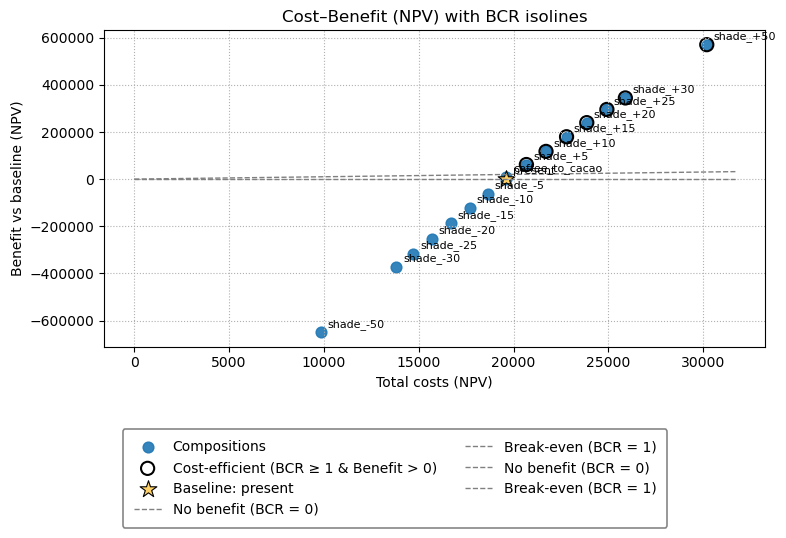

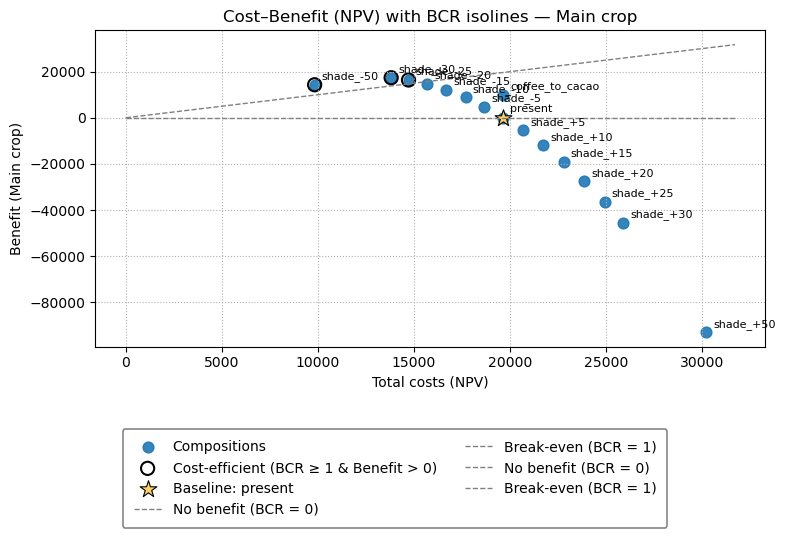

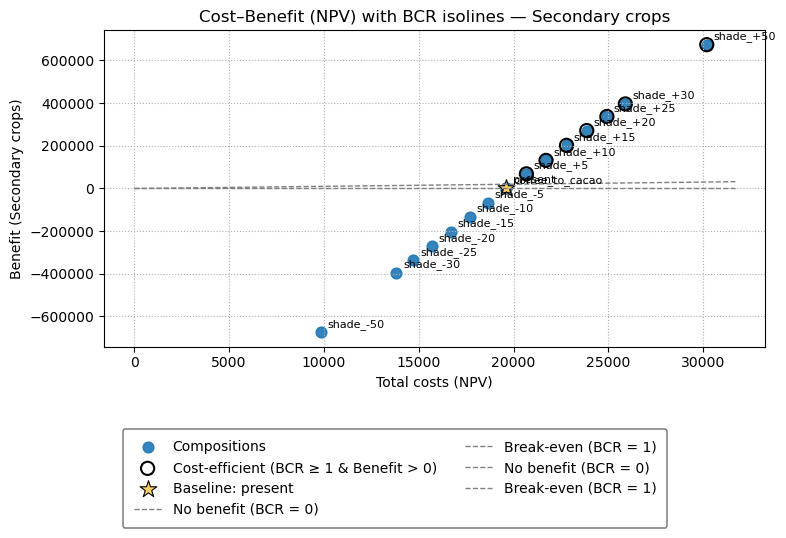

In [66]:
# Total (default)
fig, ax = plot_cost_vs_benefit(df_cb_metrics, role="total")
# Save the figure in the results folder OUTPUT_DIR
fig.savefig(f"{OUTPUT_DIR}/cost_vs_benefit_total.png", dpi=300, bbox_inches='tight')

# Main crop
fig, ax = plot_cost_vs_benefit(df_cb_metrics, role="main")
# Save the figure in the results folder OUTPUT_DIR
fig.savefig(f"{OUTPUT_DIR}/cost_vs_benefit_main.png", dpi=300, bbox_inches='tight')

# Secondary crops
fig, ax = plot_cost_vs_benefit(df_cb_metrics, role="secondary")
# Save the figure in the results folder OUTPUT_DIR
fig.savefig(f"{OUTPUT_DIR}/cost_vs_benefit_secondary.png", dpi=300, bbox_inches='tight')


**Plot Cost–Benefit Attribution by Role**

This visualization shows the **attribution of benefits and costs** across canopy alternatives,  
relative to the chosen baseline (default = *present*).  

- **ΔBenefit total (NPV)** — hatched black bar  
  - Net benefit relative to baseline = (ΔRev Main + ΔRev Secondary – ΔCost).  

- **ΔRev Main (NPV)** — blue bar  
  - Change in discounted revenue from the **main crop**.  

- **ΔRev Secondary (NPV)** — orange bar  
  - Change in discounted revenue from **secondary crops**.  

- **ΔCost (NPV)** — red bar  
  - Additional (or reduced) discounted costs of planting + maintenance.  

- **BCR (Total)** — purple line (right axis)  
  - Benefit–Cost Ratio, i.e. total discounted benefits divided by discounted costs.  
  - A dashed line at **BCR = 1** indicates the threshold where benefits equal costs.  

---

### Interpretation
This plot lets us answer:  
- Which role (**main vs. secondary**) drives the net benefits under each canopy alternative?  
- Do higher canopy adjustments reduce revenues from the main crop but increase those from secondary crops?  
- Which scenarios cross the **BCR > 1** threshold, making them economically justifiable?  
- How do **cost increases** compare against the gains in revenues and risk reduction?  


In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_cb_roles_with_bcr(
    df_cb_metrics: pd.DataFrame,
    df_npv: pd.DataFrame = None,          # provide if role NPVs aren't in df_cb_metrics
    baseline: str = "present",
    figsize=(12,5),
    sort_by: str = None,                  # None | "BCR" | "Benefit" | "Cost"
):
    """
    Left y-axis: grouped bars per composition
        - Net benefit change (ΔRevenue_total − ΔCost)  ← emphasized, separate bar
        - Change in revenue — main crop
        - Change in revenue — secondary/shade trees
        - Change in costs (planting + maintenance)
    Right y-axis: Benefit–Cost Ratio (BCR) as a line.
    All deltas are relative to the baseline composition.
    """
    d = df_cb_metrics.copy()

    # Ensure role NPVs exist
    role_cols = ["Revenue (NPV) – Main", "Revenue (NPV) – Secondary"]
    if any(c not in d.columns for c in role_cols):
        if df_npv is None:
            raise ValueError("Role NPVs missing. Pass df_npv with 'Revenue (NPV) – Main/Secondary'.")
        d = d.merge(df_npv[["Composition"] + role_cols], on="Composition", how="left")

    # Baseline
    b = d.loc[d["Composition"] == baseline]
    if b.empty:
        raise ValueError(f"Baseline '{baseline}' not found.")
    b = b.iloc[0]

    # Deltas vs baseline
    d["ΔRev Main (NPV)"]      = d["Revenue (NPV) – Main"]      - b["Revenue (NPV) – Main"]
    d["ΔRev Secondary (NPV)"] = d["Revenue (NPV) – Secondary"] - b["Revenue (NPV) – Secondary"]
    d["ΔCost (NPV)"]          = d["Costs (NPV)"]               - b["Costs (NPV)"]
    d["ΔBenefit (NPV)"]       = d["ΔRev Main (NPV)"] + d["ΔRev Secondary (NPV)"] - d["ΔCost (NPV)"]

    if "BCR" not in d.columns and {"Benefit","Costs (NPV)"} <= set(d.columns):
        d["BCR"] = d["Benefit"] / d["Costs (NPV)"]

    # Optional sort
    if sort_by == "BCR":
        d = d.sort_values("BCR")
    elif sort_by == "Benefit" and "Benefit" in d.columns:
        d = d.sort_values("Benefit")
    elif sort_by == "Cost":
        d = d.sort_values("ΔCost (NPV)")

    # Positions
    x = np.arange(len(d))
    w = 0.22
    off_total = -1.5 * w
    off_main  = -0.5 * w
    off_seco  =  0.5 * w
    off_cost  =  1.5 * w

    fig, ax = plt.subplots(figsize=figsize)

    # --- Emphasized net benefit (its own bar) ---
    bar_net = ax.bar(
        x + off_total, d["ΔBenefit (NPV)"].values, width=w,
        facecolor="none", edgecolor="black", linewidth=1.8, hatch="////",
        label="Net benefit change (ΔRevenue_total − ΔCost)"
    )

    # --- Role revenues and cost (grouped) ---
    bar_main = ax.bar(x + off_main, d["ΔRev Main (NPV)"].fillna(0).values, width=w,
                      label="Change in revenue — main crop")
    bar_sec  = ax.bar(x + off_seco, d["ΔRev Secondary (NPV)"].fillna(0).values, width=w,
                      label="Change in revenue — secondary (shade trees)")
    bar_cost = ax.bar(x + off_cost, d["ΔCost (NPV)"].fillna(0).values, width=w,
                      label="Change in costs (planting + maintenance)")

    ax.axhline(0, linestyle="--", linewidth=1, color="0.4")
    ax.set_xticks(x)
    ax.set_xticklabels(d["Composition"].tolist(), rotation=45, ha="right")
    ax.set_ylabel("Change vs baseline (NPV)")
    ax.set_title(f"Benefits by role and costs vs baseline ({baseline}) with Benefit–Cost Ratio")

    # Right axis: BCR line + reference at 1
    ax2 = ax.twinx()
    line_bcr, = ax2.plot(x, d["BCR"].values, marker="o", linewidth=2, color="purple",
                         label="Benefit–Cost Ratio (total)")
    line_bcr1 = ax2.axhline(1.0, linestyle=":", linewidth=3, color="purple",
                            label="Breakeven (BCR = 1) ")
    ax2.set_ylabel("BCR (Benefit / Cost)")

    # --- Legend (boxed, below the plot) ---
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    handles = h1 + h2
    labels  = l1 + l2

    leg = fig.legend(
        handles, labels,
        loc="lower center", ncol=2,
        bbox_to_anchor=(0.5, -0.06),   # move up/down as needed
        frameon=True, fancybox=True, framealpha=0.95,
        edgecolor="0.5", facecolor="white", borderpad=0.8, handlelength=2
    )
    leg.get_frame().set_linewidth(1.2)

    # Leave room at bottom so the legend isn't clipped
    fig.tight_layout(rect=[0, 0.18, 1, 1])

    # Expand x-limits so outer bars aren’t clipped
    ax.set_xlim(x.min() - 2*w, x.max() + 2*w)

    return fig, ax, ax2


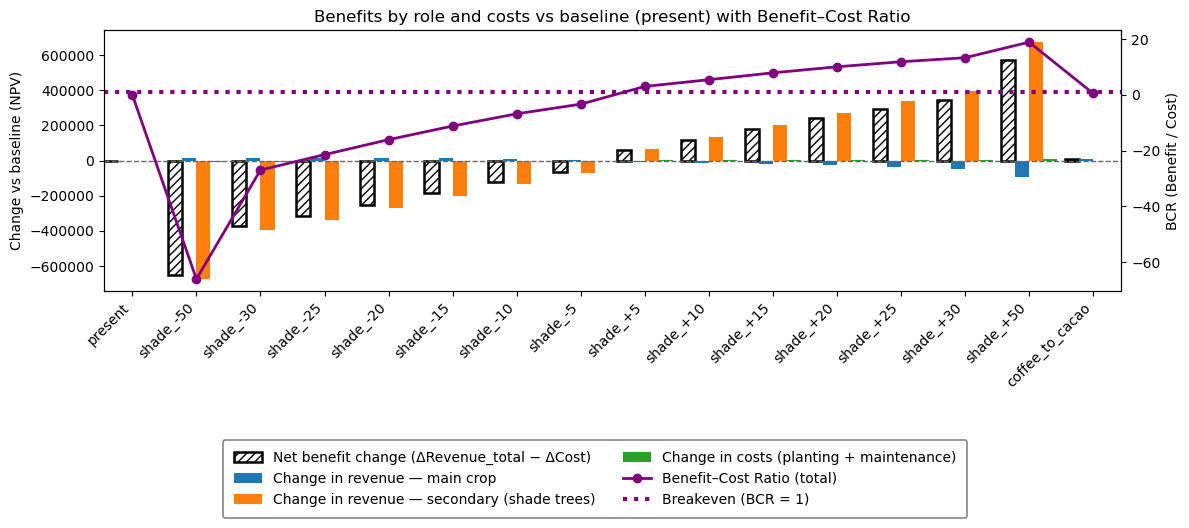

In [68]:
fig, ax, ax2 = plot_cb_roles_with_bcr(
    df_cb_metrics=df_cb_metrics,
    df_npv=df_npv,            # provide if role NPVs aren't already merged
    baseline="present",
    sort_by=None,
    
)
# Save the figure in the results folder OUTPUT_DIR
fig.savefig(f"{OUTPUT_DIR}/cb_roles_with_bcr_present.png", dpi=300, bbox_inches='tight')


## *8.5 – Extra: Add biodiversity as a metric*

Is found in *Balancing Act: Meta-analysis of ecological and economic outcomes in Latin American coffee agroforestry systems.* Master’s Thesis. **Contreras Fleury, M. (2025).** 

In [69]:
df_cb_metrics

Composition  Avg. canopy cover  Costs (NPV)  Revenue (NPV) – Total  \
0           present          39.339722     19625.32           1.982177e+06   
1         shade_-50          19.729722      9826.96           1.322704e+06   
2         shade_-30          27.657639     13808.08           1.603532e+06   
3         shade_-25          29.489028     14711.84           1.661395e+06   
4         shade_-20          31.445833     15695.68           1.725623e+06   
5         shade_-15          33.475139     16685.24           1.792253e+06   
6         shade_-10          35.465347     17689.10           1.859497e+06   
7          shade_-5          37.404444     18650.06           1.918575e+06   
8          shade_+5          41.275000     20676.88           2.045064e+06   
9         shade_+10          43.214097     21711.84           2.101732e+06   
10        shade_+15          45.204306     22794.20           2.164972e+06   
11        shade_+20          47.233611     23861.16           2.225889e+06   
12        shade_+25          49.190417     24921.30           2.282919e+06   
13        shade_+30          51.021806     25894.66           2.332659e+06   
14        shade_+50          58.949722     30186.88           2.562968e+06   
15  coffee_to_cacao          39.339722     19625.32           1.991696e+06   

    Revenue (NPV) – Main  Revenue (NPV) – Secondary  \
0          635684.553431               1.346023e+06   
1          649990.908592               6.719810e+05   
2          653041.996288               9.498266e+05   
3          652065.351621               1.008693e+06   
4          650385.572225               1.074634e+06   
5          647741.176125               1.143941e+06   
6          644478.424518               1.214484e+06   
7          640465.799897               1.277609e+06   
8          630191.327102               1.414437e+06   
9          623761.324994               1.477561e+06   
10         616488.722332               1.548105e+06   
11         608126.273314               1.617412e+06   
12         599237.420401               1.683353e+06   
13         590130.802640               1.742219e+06   
14         542665.199649               2.020064e+06   
15         645673.288043               1.346023e+06   

    Avg. Revenue – Total (today)  Avg. Revenue – Total (future)  \
0                   58000.200000                   57475.966578   
1                   38919.452205                   38172.865275   
2                   47060.647590                   46379.505603   
3                   48733.753128                   48074.070809   
4                   50589.393633                   49956.318480   
5                   52515.839867                   51907.783369   
6                   54457.775504                   53879.112178   
7                   56161.623148                   55612.962422   
8                   59816.580280                   59319.349885   
9                   61453.838456                   60979.987289   
10                  63282.164135                   62832.242760   
11                  65044.115536                   64615.822022   
12                  66696.327908                   66283.335313   
13                  68136.797561                   67738.142628   
14                  74816.800831                   74465.680018   
15                  57992.000000                   57992.000000   

    Avg. Revenue - Bad Year – Total (today)  \
0                              57560.221454   
1                              38292.945322   
2                              46487.314730   
3                              48180.015443   
4                              50063.101155   
5                              52005.599444   
6                              53970.855963   
7                              55700.440597   
8                              59397.839268   
9                              61049.765946   
10                             62885.996219   
11                             64658.5819

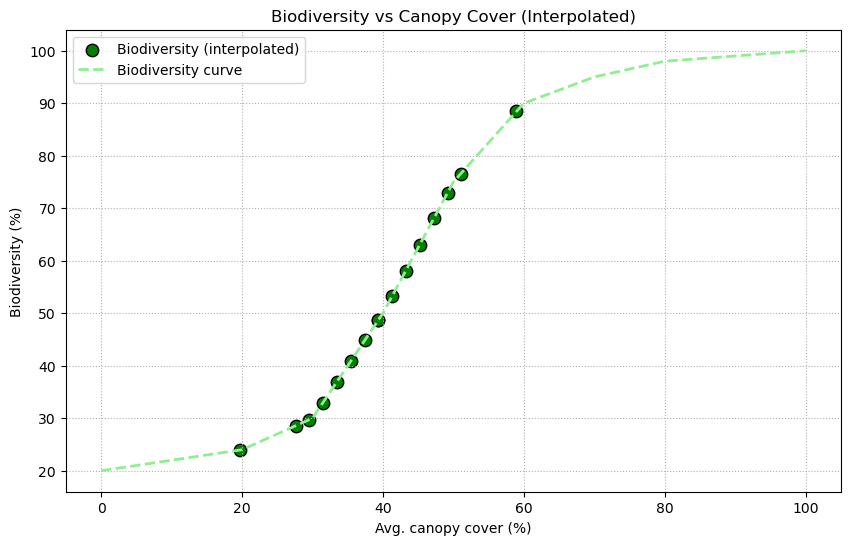

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load your two data sources
shade_biodiversity_df = pd.read_csv("Data/shade_biodiversity.csv")

# Interpolation function
def interpolate_biodiversity(canopy_value, shade_biodiversity_df):
    return np.interp(
        canopy_value,
        shade_biodiversity_df["Shade (%)"],
        shade_biodiversity_df["Biodiversity (%)"]
    )

# Apply smooth mapping
df_cb_metrics["Biodiversity (%)"] = df_cb_metrics["Avg. canopy cover"].apply(
    lambda v: interpolate_biodiversity(v, shade_biodiversity_df)
)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10,6))

# Scatter for actual data
ax.scatter(df_cb_metrics["Avg. canopy cover"], df_cb_metrics["Biodiversity (%)"],
           s=80, color="green", edgecolor="black", label="Biodiversity (interpolated)")

# Optionally, plot smooth reference biodiversity curve too
ax.plot(shade_biodiversity_df["Shade (%)"], shade_biodiversity_df["Biodiversity (%)"],
        color="lightgreen", linewidth=2, linestyle="--", label="Biodiversity curve")

plt.title("Biodiversity vs Canopy Cover (Interpolated)")
plt.xlabel("Avg. canopy cover (%)")
plt.ylabel("Biodiversity (%)")
plt.grid(True, linestyle=":")
plt.legend()
plt.show()

# Save the figure in the results folder OUTPUT_DIR
fig.savefig(f"{OUTPUT_DIR}/biodiversity_vs_canopy.png", dpi=300, bbox_inches='tight')


## 8.6 – Store the results as an excel file

In [71]:
print(tabulate(df_cb_metrics, headers='keys', tablefmt='psql'))

+----+-----------------+---------------------+---------------+-------------------------+------------------------+-----------------------------+--------------------------------+---------------------------------+-------------------------------------------+--------------------------------------------+-------------+------------+------------+------------------+-----------------------+--------------+-------------------+-------------------+------------------------+---------------+-----------------+--------------------+
|    | Composition     |   Avg. canopy cover |   Costs (NPV) |   Revenue (NPV) – Total |   Revenue (NPV) – Main |   Revenue (NPV) – Secondary |   Avg. Revenue – Total (today) |   Avg. Revenue – Total (future) |   Avg. Revenue - Bad Year – Total (today) |   Avg. Revenue - Bad Year – Total (future) |   Net (NPV) |    Benefit |        BCR |   Benefit (Main) |   Benefit (Secondary) |   BCR (Main) |   BCR (Secondary) |   ΔRev Main (NPV) |   ΔRev Secondary (NPV) |   ΔCost (NPV) |   B

In [72]:
import pandas as pd

output_file = OUTPUT_DIR / file_name.replace(".xlsx", "_cb_metrics.xlsx")

# Round numeric values
df_fmt = df_cb_metrics.copy()
numeric_cols = df_fmt.select_dtypes(include="number").columns
df_fmt[numeric_cols] = df_fmt[numeric_cols].round(2)

with pd.ExcelWriter(output_file, engine="xlsxwriter") as writer:
    df_fmt.to_excel(writer, index=False, sheet_name="CB Metrics")
    workbook  = writer.book
    worksheet = writer.sheets["CB Metrics"]

    # Formats
    money_fmt   = workbook.add_format({'num_format': '#,##0'})
    dec_fmt     = workbook.add_format({'num_format': '0.00'})
    header_fmt  = workbook.add_format({
        'bold': True, 'text_wrap': True, 'valign': 'top',
        'fg_color': '#D7E4BC', 'border': 1
    })

    # Apply header formatting
    for col_num, value in enumerate(df_fmt.columns.values):
        worksheet.write(0, col_num, value, header_fmt)

    # Define column widths and formats separately
    col_settings = {
        "Composition": (20, None),
        "Avg. canopy cover": (20, dec_fmt),
        "Costs (NPV)": (15, money_fmt),
        "Revenue (NPV) – Total": (20, money_fmt),
        "Revenue (NPV) – Main": (20, money_fmt),
        "Revenue (NPV) – Secondary": (22, money_fmt),
        "Avg. Revenue – Total (today)": (25, money_fmt),
        "Avg. Revenue – Total (future)": (25, money_fmt),
        "Avg. Revenue - Bad Year – Total (today)": (30, money_fmt),
        "Avg. Revenue - Bad Year – Total (future)": (30, money_fmt),
        "Net (NPV)": (15, money_fmt),
        "Benefit": (15, money_fmt),
        "BCR": (10, dec_fmt),
        "ΔRev Main (NPV)": (18, money_fmt),
        "ΔRev Secondary (NPV)": (22, money_fmt),
        "ΔCost (NPV)": (15, money_fmt),
        "Benefit_check": (18, money_fmt),
        "Biodiversity (%)": (15, dec_fmt),
    }

    # Apply widths and formats
    for i, col in enumerate(df_fmt.columns):
        width, fmt = col_settings.get(col, (max(12, len(col) + 2), None))
        worksheet.set_column(i, i, width, fmt)

    est_values_df.to_excel(writer, index=False, sheet_name="Estimated Values")
    est_values_sheet = writer.sheets["Estimated Values"]

    # Define column widths and formats for est_values_df
    est_col_settings = {
        "Composition": (20, None),
        "Avg. canopy cover": (20, dec_fmt),
        "Costs (NPV)": (15, money_fmt),
        "Avg. Revenue – Total (today)": (25, money_fmt),
        "AAL % – Total (today)": (15, dec_fmt),
        "AAL % – Total (future)": (15, dec_fmt),
        "Avg. Revenue - Bad Year – Total (today)": (30, money_fmt),
        "Avg. Revenue – Total (future)": (25, money_fmt),
        "Avg. Revenue - Bad Year – Total (future)": (30, money_fmt),
        "Avg. Revenue – Main (today)": (25, money_fmt),
        "AAL % – Main (today)": (15, dec_fmt),
        "AAL % – Main (future)": (15, dec_fmt),
        "Avg. Revenue – Main (future)": (25, money_fmt),
        "Avg. Revenue – Secondary (today)": (25, money_fmt),
        "AAL % – Secondary (today)": (15, dec_fmt),
        "AAL % – Secondary (future)": (15, dec_fmt),
        "Avg. Revenue – Secondary (future)": (25, money_fmt),
    }

    # Apply widths and formats for est_values_df
    for i, col in enumerate(est_values_df.columns):
        width, fmt = est_col_settings.get(col, (max(12, len(col) + 2), None))
        est_values_sheet.set_column(i, i, width, fmt)

# Plots

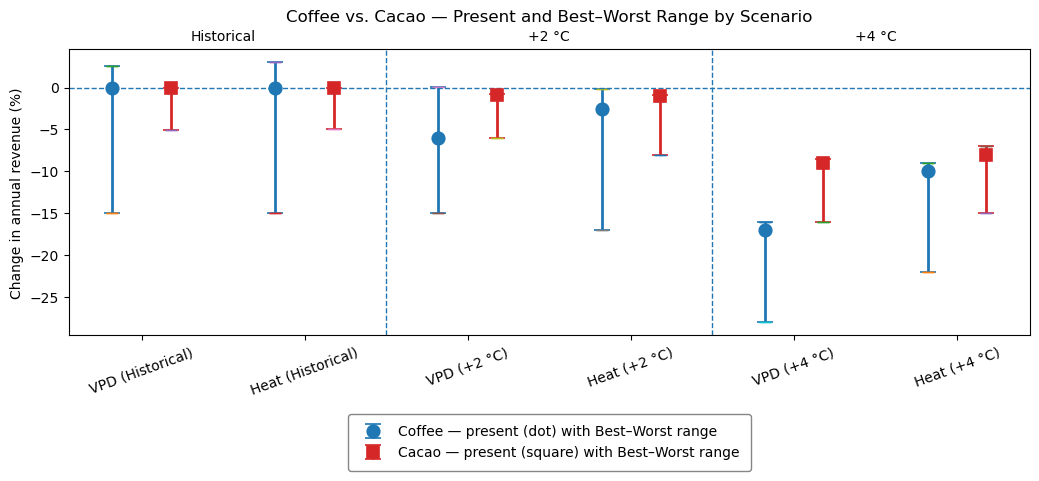

In [73]:
# Updated plot per user's requests:
# - Raise the title (add padding)
# - Increase the size of the "present" markers
#
# Still no seaborn, no explicit colors, and one clean figure.

import matplotlib.pyplot as plt
import numpy as np

# Scenarios grouped as: Historical | +2 °C | +4 °C, each with VPD and Heat
scenarios = [
    "VPD (Historical)",
    "Heat (Historical)",
    "VPD (+2 °C)",
    "Heat (+2 °C)",
    "VPD (+4 °C)",
    "Heat (+4 °C)",
]

# Coffee data (percent changes)
coffee_present = np.array([0.0, 0.0, -6.0, -2.6, -17.0, -10.0])
coffee_worst   = np.array([-15.0, -15.0, -15.0, -17.0, -28.0, -22.0])
coffee_best    = np.array([  2.6,   3.0,   0.1,  -0.2, -16.0,  -9.0])

# Cacao data (percent changes)
cacao_present = np.array([0.0, 0.0, -0.9, -1.0, -9.0, -8.0])
cacao_worst   = np.array([-5.1, -4.9, -6.0, -8.0, -16.0, -15.0])
cacao_best    = np.array([0.0,  0.0, -0.8, -0.9, -8.5,  -7.0])

# X positions
x = np.arange(len(scenarios))
offset = 0.18

# Helper to compute asymmetric errors around "present"
def asym_err(present, worst, best):
    lower = present - worst   # distance down to worst
    upper = best - present    # distance up to best
    lower = np.maximum(lower, 0.0)
    upper = np.maximum(upper, 0.0)
    return [lower, upper]

coffee_err = asym_err(coffee_present, coffee_worst, coffee_best)
cacao_err  = asym_err(cacao_present,  cacao_worst,  cacao_best)

# Build figure
fig, ax = plt.subplots(figsize=(10.5, 5.2))

# Coffee: error bars + present point (bigger markersize)
ax.errorbar(
    x - offset, coffee_present, yerr=coffee_err,
    fmt='o', markersize=9, capsize=6, linewidth=2, markeredgewidth=1.2,
    label="Coffee — present (dot) with Best–Worst range"
)

# Add short tick marks at the ends of the Coffee ranges for readability
for xi, p, wl, wu in zip(x - offset, coffee_present, coffee_err[0], coffee_err[1]):
    ax.plot([xi, xi], [p - wl, p - wl], marker='_', markersize=8)
    ax.plot([xi, xi], [p + wu, p + wu], marker='_', markersize=8)

# Cacao: error bars + present point (square, bigger markersize)
ax.errorbar(
    x + offset, cacao_present, yerr=cacao_err,
    fmt='s', markersize=9, capsize=6, linewidth=2, markeredgewidth=1.2,
    label="Cacao — present (square) with Best–Worst range"
)

# Add short tick marks at the ends of the Cacao ranges for readability
for xi, p, wl, wu in zip(x + offset, cacao_present, cacao_err[0], cacao_err[1]):
    ax.plot([xi, xi], [p - wl, p - wl], marker='_', markersize=8)
    ax.plot([xi, xi], [p + wu, p + wu], marker='_', markersize=8)

# Zero line
ax.axhline(0, linestyle='--', linewidth=1)

# Group separators (dashed vertical lines) between Historical | +2 °C | +4 °C
ax.axvline(1.5, linestyle='--', linewidth=1)
ax.axvline(3.5, linestyle='--', linewidth=1)

# Group labels above the x-axis
ax.text(0.5, 1.02, "Historical", transform=ax.get_xaxis_transform(), ha='center', va='bottom')
ax.text(2.5, 1.02, "+2 °C",      transform=ax.get_xaxis_transform(), ha='center', va='bottom')
ax.text(4.5, 1.02, "+4 °C",      transform=ax.get_xaxis_transform(), ha='center', va='bottom')

# X-axis labels
ax.set_xticks(x)
ax.set_xticklabels(scenarios, rotation=20)

# Labels and title (raise title with padding)
ax.set_ylabel("Change in annual revenue (%)")
ax.set_title("Coffee vs. Cacao — Present and Best–Worst Range by Scenario", pad=20)

# Legend put below the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=1, frameon=True, fancybox=True, framealpha=0.95, edgecolor="0.5", facecolor="white", borderpad=0.8, handlelength=2)

fig.tight_layout()
plt.show()

# Save the figure in the results folder OUTPUT_DIR
fig.savefig(f"{OUTPUT_DIR}/coffee_cacao_yield_changes.png", dpi=300, bbox_inches='tight')